<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/ArielChernyy/Inspectrum_clinic_new_dataset_230525.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [324]:
import numpy as np
import pandas as pd
import xlrd
import copy
import pickle
import os
import json
import re
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score

from scipy.spatial import distance

import xgboost as xgb
import lightgbm as lgbm

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import Accuracy, Precision, Recall

from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant

!pip install tensorflow-addons

import tensorflow_addons as tfa


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [323]:
pip install tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tfa (from versions: none)
ERROR: No matching distribution found for tfa


In [ ]:
from scikeras.wrappers import KerasClassifier

In [ ]:
#from google.colab import drive
#drive.mount('/content/Drive/')

# Загрузка и первичный анализ

In [ ]:
#data = pd.read_excel('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D1%81%D0%B5%D0%BC%D0%BF%D0%BB%20%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%D0%B0.xlsx')

# новый датасет
data = pd.read_excel('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx')

In [ ]:
data.shape

(1982, 4587)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 4587 entries, ДокументПрохождениеМедосмотра to Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
dtypes: bool(1), datetime64[ns](43), float64(1253), object(3290)
memory usage: 69.3+ MB


In [ ]:
data.head()

ДокументПрохождениеМедосмотра                                Клиент  \
0  7f41ca7e-7dac-11ec-80fc-0cc47aab8067  c91e3407-b81f-11e9-80cf-0cc47aab8067   
1  2ee1f9ac-83dd-11ec-80fc-0cc47aab8067  1a1a5fea-8b7f-11eb-80e8-0cc47aab8067   
2  9cbb191e-8e24-11ec-80fe-0cc47aab8067  7fe324e0-fa51-11eb-80f6-0cc47aab8067   
3  b8a33910-8eec-11ec-80fe-0cc47aab8067  98f9d761-8d65-11ec-80fe-0cc47aab8067   
4  0bb0d181-938c-11ec-80fe-0cc47aab8067  009aac7d-7bcf-11eb-80e8-0cc47aab8067   

  КлиентДатаРождения КлиентПол КлиентПолПредставление  \
0         1976-10-24   Женский                Женский   
1         1987-11-18   Мужской                Мужской   
2         1985-09-08   Мужской                Мужской   
3         1988-04-25   Мужской                Мужской   
4         1984-04-17   Мужской                Мужской   

  ДатаЗавершенияМедосмотра  ТипМедосмотра ТипМедосмотраПредставление  \
0               2022-01-25  Периодический              Периодический   
1               2022-02-02  Периодический              Периодический   
2               2022-02-15  Периодический              Периодический   
3               2022-02-16  Периодический              Периодический   
4               2022-02-22  Периодический              Периодический   

   ПсихОсвидетельствование                            Контрагент  ...  \
0                    False  23c173a7-30d9-11e7-80d8-708bcd7f83cd  ...   
1                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067  ...   
2                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067  ...   
3                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067  ...   
4                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067  ...   

  Оториноларингология3_Аудиометрия1_Значение  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

  Оториноларингология3_Аудиометрия1_ЗначениеПредставление  \
0                                                NaN        
1                                                NaN        
2                                                NaN        
3                                                NaN        
4                                                NaN        

  Оториноларингология1_ЖалобыДополнение_Значение  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

  Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление  \
0                                                NaN            
1                                                NaN            
2                                                NaN            
3                                                NaN            
4                                                NaN            

  Стоматология2_ВП2_Значение Стоматология2_ВП2_ЗначениеПредставление  \
0                        NaN                                     NaN   
1                        NaN                                     NaN   
2                        NaN                                     NaN   
3                        NaN                                     NaN   
4                        NaN                                     NaN   

  Терапия2_ЗаключениеФОГК_Значение  \
0                              NaN   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   

  Терапия2_ЗаключениеФОГК_ЗначениеПредставление  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                              

### Пустые значения

In [ ]:
n_na = data.isna().sum()

In [ ]:
print(n_na.sort_values())

ДокументПрохождениеМедосмотра                             0
Клиент                                                    0
КлиентДатаРождения                                        0
КлиентПол                                                 0
КлиентПолПредставление                                    0
                                                       ... 
ПсихиатрияНаркология1_Противопоказание2                1982
ПсихиатрияНаркология1_Классификация3Представление2     1982
ПсихиатрияНаркология1_Классификация32                  1982
УЗИДиагностика2_Классификация1Представление2           1982
ПроцедурнаяМедсестра1_ХР_Рекомендация2Представление    1982
Length: 4587, dtype: int64


In [ ]:
print(n_na.value_counts().sort_index(ascending=False))

1982    884
1981    350
1980    589
1979     79
1978     87
       ... 
241       5
240      11
237       1
236       3
0        12
Length: 291, dtype: int64


In [ ]:
data[n_na[n_na==0].index.tolist()].head()

ДокументПрохождениеМедосмотра                                Клиент  \
0  7f41ca7e-7dac-11ec-80fc-0cc47aab8067  c91e3407-b81f-11e9-80cf-0cc47aab8067   
1  2ee1f9ac-83dd-11ec-80fc-0cc47aab8067  1a1a5fea-8b7f-11eb-80e8-0cc47aab8067   
2  9cbb191e-8e24-11ec-80fe-0cc47aab8067  7fe324e0-fa51-11eb-80f6-0cc47aab8067   
3  b8a33910-8eec-11ec-80fe-0cc47aab8067  98f9d761-8d65-11ec-80fe-0cc47aab8067   
4  0bb0d181-938c-11ec-80fe-0cc47aab8067  009aac7d-7bcf-11eb-80e8-0cc47aab8067   

  КлиентДатаРождения КлиентПол КлиентПолПредставление  \
0         1976-10-24   Женский                Женский   
1         1987-11-18   Мужской                Мужской   
2         1985-09-08   Мужской                Мужской   
3         1988-04-25   Мужской                Мужской   
4         1984-04-17   Мужской                Мужской   

  ДатаЗавершенияМедосмотра  ТипМедосмотра ТипМедосмотраПредставление  \
0               2022-01-25  Периодический              Периодический   
1               2022-02-02  Периодический              Периодический   
2               2022-02-15  Периодический              Периодический   
3               2022-02-16  Периодический              Периодический   
4               2022-02-22  Периодический              Периодический   

   ПсихОсвидетельствование                            Контрагент  \
0                    False  23c173a7-30d9-11e7-80d8-708bcd7f83cd   
1                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067   
2                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067   
3                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067   
4                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067   

                                   Профессия ВредныеФакторы  
0  Ведущий специалист по организации обуения           11.4  
1                         Ведущий специалист          4.2.5  
2                           Главный менеджер          4.2.5  
3                         Главный специалист           11.1  
4                         Старший специалист           11.1

In [ ]:
print(f'{n_na.value_counts().sort_index(ascending=False)[1982]} колонок с только пустыми значениями',
      f'{n_na.value_counts().sort_index(ascending=False)[1981]} колонок с 1 непустым значением',
      f'{n_na.value_counts().sort_index(ascending=False)[1980]} колонок с 2 непустыми значениями', 
      sep = '\n')

884 колонок с только пустыми значениями
350 колонок с 1 непустым значением
589 колонок с 2 непустыми значениями


#### (!) в примере датасета много пустых или почти пустых (1 или 2 непустых значения) колонок. хотелось бы отбросить их, но неизвестно, будут ли они пустыми в полном датасете. 

#### (!) пока не удаляю пустые столбцы, т.к. хочу дальше поискать способ обработки столбцов по группам

In [ ]:
full_columns = n_na[n_na == 0].index.tolist()
full_columns

['ДокументПрохождениеМедосмотра',
 'Клиент',
 'КлиентДатаРождения',
 'КлиентПол',
 'КлиентПолПредставление',
 'ДатаЗавершенияМедосмотра',
 'ТипМедосмотра',
 'ТипМедосмотраПредставление',
 'ПсихОсвидетельствование',
 'Контрагент',
 'Профессия',
 'ВредныеФакторы']

# Группы факторов

буду собирать обработанные (готовые к подаче в нейронку) факторы в DataFrame X, обработанную зависимую переменную положу в DataFrame target

In [ ]:
X = pd.DataFrame(index=data.index)

In [ ]:
cols_no_digits = []
cols_w_digits = []
for x in data.columns:
  if len(re.findall(r'\d', x)) > 0:
    cols_w_digits.append(x)
  else:
    cols_no_digits.append(x)
print(len(cols_no_digits), len(cols_w_digits))

18 4569


In [ ]:
print(cols_no_digits)

['ДокументПрохождениеМедосмотра', 'Клиент', 'КлиентДатаРождения', 'КлиентПол', 'КлиентПолПредставление', 'ДатаЗавершенияМедосмотра', 'ТипМедосмотра', 'ТипМедосмотраПредставление', 'ПсихОсвидетельствование', 'Контрагент', 'Цех', 'Профессия', 'ЗаключениеМК', 'ЗаключениеМКПредставление', 'Заключение', 'ДиспансернаяГруппа', 'ДиспансернаяГруппаПредставление', 'ВредныеФакторы']


In [ ]:
data[cols_no_digits].head()

ДокументПрохождениеМедосмотра                                Клиент  \
0  7f41ca7e-7dac-11ec-80fc-0cc47aab8067  c91e3407-b81f-11e9-80cf-0cc47aab8067   
1  2ee1f9ac-83dd-11ec-80fc-0cc47aab8067  1a1a5fea-8b7f-11eb-80e8-0cc47aab8067   
2  9cbb191e-8e24-11ec-80fe-0cc47aab8067  7fe324e0-fa51-11eb-80f6-0cc47aab8067   
3  b8a33910-8eec-11ec-80fe-0cc47aab8067  98f9d761-8d65-11ec-80fe-0cc47aab8067   
4  0bb0d181-938c-11ec-80fe-0cc47aab8067  009aac7d-7bcf-11eb-80e8-0cc47aab8067   

  КлиентДатаРождения КлиентПол КлиентПолПредставление  \
0         1976-10-24   Женский                Женский   
1         1987-11-18   Мужской                Мужской   
2         1985-09-08   Мужской                Мужской   
3         1988-04-25   Мужской                Мужской   
4         1984-04-17   Мужской                Мужской   

  ДатаЗавершенияМедосмотра  ТипМедосмотра ТипМедосмотраПредставление  \
0               2022-01-25  Периодический              Периодический   
1               2022-02-02  Периодический              Периодический   
2               2022-02-15  Периодический              Периодический   
3               2022-02-16  Периодический              Периодический   
4               2022-02-22  Периодический              Периодический   

   ПсихОсвидетельствование                            Контрагент  \
0                    False  23c173a7-30d9-11e7-80d8-708bcd7f83cd   
1                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067   
2                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067   
3                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067   
4                    False  a6d559b0-7835-11eb-80e8-0cc47aab8067   

                                                 Цех  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3   Отдел техники и технологии строительства скважин   
4  Отдел технологий текущего и капитального ремон...   

                                   Профессия            ЗаключениеМК  \
0  Ведущий специалист по организации обуения                   Годен   
1                         Ведущий специалист                   Годен   
2                           Главный менеджер  ГоденСКоррекциейЗрения   
3                         Главный специалист                   Годен   
4                         Старший специалист  ГоденСКоррекциейЗрения   

                           ЗаключениеМКПредставление  \
0                Годен к работе в указанных условиях   
1                Годен к работе в указанных условиях   
2  Годен к работе в указанных условиях (с коррекц...   
3                Годен к работе в указанных условиях   
4  Годен к работе в указанных условиях (с коррекц...   

                                          Заключение ДиспансернаяГруппа  \
0                Годен к работе в указанных условиях                  I   
1                Годен к работе в указанных условиях               IIIа   
2  Годен к работе в указанных условиях (с коррекц...                 II   
3                Годен к работе в указанных условиях                  I   
4  Годен к работе в указанных условиях (с коррекц...                 II   

  ДиспансернаяГруппаПредставление ВредныеФакторы  
0                               I           11.4  
1                            IIIа          4.2.5  
2                              II          4.2.5  
3                               I           11.1  
4                              II           11.1

### обработка столбца "вредные факторы"

In [ ]:
factors_list = []
for elem in data['ВредныеФакторы']:
  factors_list += elem.split(',')
factors_list = list(set(factors_list))
factors_list

['4.8',
 '22',
 '2.4.3',
 '3.1.8.1',
 '1.45.1',
 '1.8.1.2',
 '25',
 '3.1.8.3',
 '1.49',
 '24',
 '1.8.1.1',
 '1.18.3',
 '1.37.1',
 '3.1.2',
 '23',
 '15',
 '11',
 '1.23',
 '4.2.5',
 '4.7',
 '1.8.3',
 '1.14.2',
 '1.24',
 '4.10',
 '6.2',
 '1.29',
 '11.3',
 '3.1',
 '1.15',
 '13',
 '18.2',
 '4.2.1',
 '11.1',
 '1.19.1',
 '1.8.3.1',
 '18',
 '5.2',
 '1.29.2',
 '6',
 '1.14.1',
 '1.8.3.2',
 '9',
 '6.1',
 '1.8.2.1',
 '11.2',
 '1.36.1',
 '1.37.1.1',
 '1.36',
 '1.8.1',
 '1.8.2.2',
 '18.1',
 '1.29.4',
 '5.2.1',
 '4.6',
 '10',
 '1.30.1',
 '4.5',
 '1.49.14',
 '4.4',
 '4.9',
 '17',
 '1.37.1.2',
 '27',
 '1.3',
 'II',
 '3.1.7',
 '26',
 '4.1',
 '12',
 '1.49.2',
 '14',
 '11.4',
 '1.1',
 '4.2',
 'Годен к работе в указанных условиях',
 '1.17',
 '2.4',
 '3.1.8.2',
 '1.39',
 '1.29.1',
 '1.48',
 '1.37',
 '1.8.2',
 '4.2.4',
 '4.3.2',
 'IIIа',
 '1.50',
 '3.4',
 '4.2.3',
 '1.34.1',
 '1.2',
 '8',
 '5.1',
 '1.46',
 '4.3.1']

#### (!) кажется, все-таки и в новом датасете есть ошибки в выгрузке.

In [ ]:
data[['Клиент', 'ЗаключениеМК', 'ЗаключениеМКПредставление', 'Заключение', 'ВредныеФакторы']][data['ВредныеФакторы'].str.contains('Годен к работе в указанных условиях')|data['ВредныеФакторы'].str.contains('II')|data['ВредныеФакторы'].str.contains('IIIа')]

Клиент         ЗаключениеМК  \
843   956edb54-4047-11ec-80fa-0cc47aab8067  машинист бульдозера   
851   725f3c56-e14d-11e7-80de-708bcd7f83cd        Газоспасатель   
1022  60653387-410f-11ec-80fa-0cc47aab8067        Газоспасатель   
1024  abe3549b-4042-11ec-80fa-0cc47aab8067        Газоспасатель   

     ЗаключениеМКПредставление  \
843                 тракторист   
851     ГоденСКоррекциейЗрения   
1022                     Годен   
1024                     Годен   

                                             Заключение  \
843                                         стропальщик   
851   Годен к работе в указанных условиях (с коррекц...   
1022                Годен к работе в указанных условиях   
1024                Годен к работе в указанных условиях   

                           ВредныеФакторы  
843   Годен к работе в указанных условиях  
851                                  IIIа  
1022                                   II  
1024                                   II

In [ ]:
# оставляю среди вредных факторов только правильно закодированные
factors_list = sorted([x for x in factors_list if len(re.findall(r'\d',x))>0], key = lambda x: [int(s) for s in x.split('.')])
print(len(factors_list))
factors_list

92


['1.1',
 '1.2',
 '1.3',
 '1.8.1',
 '1.8.1.1',
 '1.8.1.2',
 '1.8.2',
 '1.8.2.1',
 '1.8.2.2',
 '1.8.3',
 '1.8.3.1',
 '1.8.3.2',
 '1.14.1',
 '1.14.2',
 '1.15',
 '1.17',
 '1.18.3',
 '1.19.1',
 '1.23',
 '1.24',
 '1.29',
 '1.29.1',
 '1.29.2',
 '1.29.4',
 '1.30.1',
 '1.34.1',
 '1.36',
 '1.36.1',
 '1.37',
 '1.37.1',
 '1.37.1.1',
 '1.37.1.2',
 '1.39',
 '1.45.1',
 '1.46',
 '1.48',
 '1.49',
 '1.49.2',
 '1.49.14',
 '1.50',
 '2.4',
 '2.4.3',
 '3.1',
 '3.1.2',
 '3.1.7',
 '3.1.8.1',
 '3.1.8.2',
 '3.1.8.3',
 '3.4',
 '4.1',
 '4.2',
 '4.2.1',
 '4.2.3',
 '4.2.4',
 '4.2.5',
 '4.3.1',
 '4.3.2',
 '4.4',
 '4.5',
 '4.6',
 '4.7',
 '4.8',
 '4.9',
 '4.10',
 '5.1',
 '5.2',
 '5.2.1',
 '6',
 '6.1',
 '6.2',
 '8',
 '9',
 '10',
 '11',
 '11.1',
 '11.2',
 '11.3',
 '11.4',
 '12',
 '13',
 '14',
 '15',
 '17',
 '18',
 '18.1',
 '18.2',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27']

In [ ]:
X_adverse_factors = pd.DataFrame({'adverse_factor_' + elem: data['ВредныеФакторы'].apply(lambda x: 1 if elem in x.split(',') else 0) for elem in factors_list}, index = data.index)
print(X_adverse_factors.shape)
X_adverse_factors

(1982, 92)


adverse_factor_1.1  adverse_factor_1.2  adverse_factor_1.3  \
0                      0                   0                   0   
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                   0   
...                  ...                 ...                 ...   
1977                   0                   0                   0   
1978                   0                   0                   0   
1979                   0                   0                   0   
1980                   0                   0                   0   
1981                   0                   0                   0   

      adverse_factor_1.8.1  adverse_factor_1.8.1.1  adverse_factor_1.8.1.2  \
0                        0                       0                       0   
1                        0                       0                       0   
2                        0                       0                       0   
3                        0                       0                       0   
4                        0                       0                       0   
...                    ...                     ...                     ...   
1977                     0                       0                       0   
1978                     0                       0                       0   
1979                     0                       0                       0   
1980                     0                       0                       0   
1981                     0                       0                       0   

      adverse_factor_1.8.2  adverse_factor_1.8.2.1  adverse_factor_1.8.2.2  \
0                        0                       0                       0   
1                        0                       0                       0   
2                        0                       0                       0   
3                        0                       0                       0   
4                        0                       0                       0   
...                    ...                     ...                     ...   
1977                     0                       0                       0   
1978                     0                       0                       0   
1979                     0                       0                       0   
1980                     0                       0                       0   
1981                     0                       0                       0   

      adverse_factor_1.8.3  ...  adverse_factor_17  adverse_factor_18  \
0                        0  ...                  0                  0   
1                        0  ...                  0                  0   
2                        0  ...                  0                  0   
3                        0  ...                  0                  0   
4                        0  ...                  0                  0   
...                    ...  ...                ...                ...   
1977                     0  ...                  0                  0   
1978                     0  ...                  0                  0   
1979                     0  ...                  0                  0   
1980                     0  ...                  0                  0   
1981                     0  ...                  0                  0   

      adverse_factor_18.1  adverse_factor_18.2  adverse_factor_22  \
0                       0                    0                  0   
1                       0                    0                  0   
2                       0                    0                  0   
3                       0                    0                  0   
4                       0                    0                  0   
...                   ..

In [ ]:
X_adverse_factors.sum(axis=1)[X_adverse_factors.sum(axis=1)==0]

843     0
851     0
1022    0
1024    0
dtype: int64

In [ ]:
X_adverse_factors.sum().sort_values()

adverse_factor_1.8.3      1
adverse_factor_2.4        1
adverse_factor_2.4.3      1
adverse_factor_1.36       1
adverse_factor_1.46       1
                       ... 
adverse_factor_5.1      351
adverse_factor_6.1      351
adverse_factor_4.2.5    356
adverse_factor_4.4      432
adverse_factor_11.1     523
Length: 92, dtype: int64

In [ ]:
adverse_factors_aux_info = pd.DataFrame(X_adverse_factors.sum(), columns = ['n_occurences'])
adverse_factors_aux_info.sort_values('n_occurences')

n_occurences
adverse_factor_1.8.3             1
adverse_factor_2.4               1
adverse_factor_2.4.3             1
adverse_factor_1.36              1
adverse_factor_1.46              1
...                            ...
adverse_factor_5.1             351
adverse_factor_6.1             351
adverse_factor_4.2.5           356
adverse_factor_4.4             432
adverse_factor_11.1            523

[92 rows x 1 columns]

In [ ]:
for i in np.arange(0.1,1,0.1):
  print(f'{int(np.round(i*100,0))}% вредных факторов встречаются не более чем у {np.round(adverse_factors_aux_info.quantile(i).values[0]/len(data)*100,1)} % осмотренных')

10% вредных факторов встречаются не более чем у 0.1 % осмотренных
20% вредных факторов встречаются не более чем у 0.1 % осмотренных
30% вредных факторов встречаются не более чем у 0.3 % осмотренных
40% вредных факторов встречаются не более чем у 0.5 % осмотренных
50% вредных факторов встречаются не более чем у 0.9 % осмотренных
60% вредных факторов встречаются не более чем у 1.6 % осмотренных
70% вредных факторов встречаются не более чем у 2.6 % осмотренных
80% вредных факторов встречаются не более чем у 4.2 % осмотренных
90% вредных факторов встречаются не более чем у 9.5 % осмотренных


In [ ]:
X_adverse_factors.sum()[X_adverse_factors.sum()<0.009*len(data)]

adverse_factor_1.2          4
adverse_factor_1.8.1        1
adverse_factor_1.8.2        1
adverse_factor_1.8.2.1     15
adverse_factor_1.8.2.2      7
adverse_factor_1.8.3        1
adverse_factor_1.8.3.1      7
adverse_factor_1.8.3.2      7
adverse_factor_1.14.1       2
adverse_factor_1.15        10
adverse_factor_1.17         2
adverse_factor_1.18.3      11
adverse_factor_1.23         8
adverse_factor_1.24         3
adverse_factor_1.29         1
adverse_factor_1.29.4       9
adverse_factor_1.36         1
adverse_factor_1.37         4
adverse_factor_1.37.1.1     6
adverse_factor_1.37.1.2     2
adverse_factor_1.45.1       2
adverse_factor_1.46         1
adverse_factor_1.48        10
adverse_factor_1.49         7
adverse_factor_1.49.2       1
adverse_factor_1.49.14      3
adverse_factor_2.4          1
adverse_factor_2.4.3        1
adverse_factor_3.1          3
adverse_factor_3.1.2       11
adverse_factor_3.1.8.1      6
adverse_factor_3.1.8.2      9
adverse_factor_3.1.8.3      2
adverse_fa

#### (!) многие вредные факторы встречаются только один или несколько раз. можно было бы запихнуть их все в фичу "прочие". Правда непонятно, сохранятся ли пропорции в полном датасете 

In [ ]:
X_adverse_factors.head()

adverse_factor_1.1  adverse_factor_1.2  adverse_factor_1.3  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   adverse_factor_1.8.1  adverse_factor_1.8.1.1  adverse_factor_1.8.1.2  \
0                     0                       0                       0   
1                     0                       0                       0   
2                     0                       0                       0   
3                     0                       0                       0   
4                     0                       0                       0   

   adverse_factor_1.8.2  adverse_factor_1.8.2.1  adverse_factor_1.8.2.2  \
0                     0                       0                       0   
1                     0                       0                       0   
2                     0                       0                       0   
3                     0                       0                       0   
4                     0                       0                       0   

   adverse_factor_1.8.3  ...  adverse_factor_17  adverse_factor_18  \
0                     0  ...                  0                  0   
1                     0  ...                  0                  0   
2                     0  ...                  0                  0   
3                     0  ...                  0                  0   
4                     0  ...                  0                  0   

   adverse_factor_18.1  adverse_factor_18.2  adverse_factor_22  \
0                    0                    0                  0   
1                    0                    0                  0   
2                    0                    0                  0   
3                    0                    0                  0   
4                    0                    0                  0   

   adverse_factor_23  adverse_factor_24  adverse_factor_25  adverse_factor_26  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   adverse_factor_27  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 92 columns]

### Зависимая переменная

In [ ]:
data[['ЗаключениеМК', 'ЗаключениеМКПредставление','Заключение']]

ЗаключениеМК  \
0                      Годен   
1                      Годен   
2     ГоденСКоррекциейЗрения   
3                      Годен   
4     ГоденСКоррекциейЗрения   
...                      ...   
1977                     NaN   
1978                     NaN   
1979                     NaN   
1980                     NaN   
1981                   Годен   

                              ЗаключениеМКПредставление  \
0                   Годен к работе в указанных условиях   
1                   Годен к работе в указанных условиях   
2     Годен к работе в указанных условиях (с коррекц...   
3                   Годен к работе в указанных условиях   
4     Годен к работе в указанных условиях (с коррекц...   
...                                                 ...   
1977                                                NaN   
1978                                                NaN   
1979                                                NaN   
1980                                                NaN   
1981                Годен к работе в указанных условиях   

                                             Заключение  
0                   Годен к работе в указанных условиях  
1                   Годен к работе в указанных условиях  
2     Годен к работе в указанных условиях (с коррекц...  
3                   Годен к работе в указанных условиях  
4     Годен к работе в указанных условиях (с коррекц...  
...                                                 ...  
1977                                                NaN  
1978                                                NaN  
1979                                                NaN  
1980                                                NaN  
1981                                                NaN  

[1982 rows x 3 columns]

#### (!) значения na в "заключениях..." - вероятно, ошибки в выгрузке

In [ ]:
data[['ЗаключениеМК', 'ЗаключениеМКПредставление','Заключение']].isna().sum()

ЗаключениеМК                 407
ЗаключениеМКПредставление    407
Заключение                   419
dtype: int64

#### удаляю строки с na в "заключениях..."

In [ ]:
data = data[data['ЗаключениеМК'].notna()]
print(data.shape)

(1575, 4587)


#### (?) какое из "заключений" является нашей зависимой переменной?

In [ ]:
data[['ЗаключениеМК','ЗаключениеМКПредставление','Заключение']][(data['ЗаключениеМКПредставление']!=data['Заключение'])]

ЗаключениеМК  \
23    ГоденСКоррекциейЗрения   
115   ГоденБезРаботНаВысотах   
224   ГоденСКоррекциейЗрения   
341                    Годен   
342                    Годен   
343                    Годен   
391                    Годен   
393                    Годен   
394                    Годен   
438                    Годен   
479          ВременноНегоден   
494                    Годен   
495                    Годен   
497                    Годен   
498                    Годен   
566   ГоденСКоррекциейЗрения   
843      машинист бульдозера   
851            Газоспасатель   
895   ГоденСКоррекциейЗрения   
1022           Газоспасатель   
1024           Газоспасатель   
1091  ГоденСКоррекциейЗрения   
1906  ГоденСКоррекциейЗрения   
1921  ГоденСКоррекциейЗрения   
1947  ГоденСКоррекциейЗрения   
1981                   Годен   

                              ЗаключениеМКПредставление  \
23    Годен к работе в указанных условиях (с коррекц...   
115   Годен к работе в указанных условиях (без работ...   
224   Годен к работе в указанных условиях (с коррекц...   
341                 Годен к работе в указанных условиях   
342                 Годен к работе в указанных условиях   
343                 Годен к работе в указанных условиях   
391                 Годен к работе в указанных условиях   
393                 Годен к работе в указанных условиях   
394                 Годен к работе в указанных условиях   
438                 Годен к работе в указанных условиях   
479                                   Временно не годен   
494                 Годен к работе в указанных условиях   
495                 Годен к работе в указанных условиях   
497                 Годен к работе в указанных условиях   
498                 Годен к работе в указанных условиях   
566   Годен к работе в указанных условиях (с коррекц...   
843                                          тракторист   
851                              ГоденСКоррекциейЗрения   
895   Годен к работе в указанных условиях (с коррекц...   
1022                                              Годен   
1024                                              Годен   
1091  Годен к работе в указанных условиях (с коррекц...   
1906  Годен к работе в указанных условиях (с коррекц...   
1921  Годен к работе в указанных условиях (с коррекц...   
1947  Годен к работе в указанных условиях (с коррекц...   
1981                Годен к работе в указанных условиях   

                                             Заключение  
23    Годен к работе в указанных условиях (с коррекц...  
115   Годен к работе в указанных условиях (без работ...  
224   Годен к работе в указанных условиях (с коррекц...  
341                                                 NaN  
342                                                 NaN  
343                                                 NaN  
391    Годен к работе в указанных условиях, кроме п 6.2  
393                                                 NaN  
394                                                 NaN  
438                                                 NaN  
479                                                 NaN  
494                                                 NaN  
495                                                 NaN  
497                                                 NaN  
498                                                 NaN  
566   Годен к работе в указанных условиях (с коррекц...  
843                                         стропальщик  
851   Годен к работе в указанных условиях (с коррекц...  
895   Годен к работе в указанных условиях (с коррекц...  
1022                Годен к работе в указанных условиях  
1024                Годен к работе в указанных условиях  
1091  Годен к работе в указанных условиях (с коррекц...  
1906  Годен к работе в указанных условиях (с коррекц...  
1921  Годен к работе в указанных условиях (с коррекц...  
1947  Годен к работе в указанных условиях (с коррекц...  
1981                                             

In [ ]:
target_raw = data['ЗаключениеМК']

In [ ]:
target_raw.value_counts()

Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
Газоспасатель                          2
ГоденБезРаботНаВысотах                 1
машинист бульдозера                    1
 Газоспасатель                         1
Name: ЗаключениеМК, dtype: int64

#### удаляю строки с ошибками в выгрузке (которые ранее вылезли в обработке "вредных факторов")

In [ ]:
data = data[(~data['ЗаключениеМК'].str.contains('Газоспасатель'))&(~data['ЗаключениеМК'].str.contains('машинист бульдозера'))]
print(data.shape)

(1571, 4587)


In [ ]:
target_raw = data['ЗаключениеМК']
target_raw.value_counts()

Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
ГоденБезРаботНаВысотах                 1
Name: ЗаключениеМК, dtype: int64

#### (?)(!) в датасете очень мало примеров класса "не годен". Не может ли так получиться, что существует конечный перечень значений каких-то факторов (который было бы здорово получить от заказчика), при котором "не годен" ставится автоматически, т.е. на которые не надо именно обучать модель? в практическом применении это будет жесткий if-then еще до модели, а из обучения такие строки было бы правильно исключить, чтобы не переобучать модель.


In [ ]:
yes = np.where(target_raw=='Годен', 1, 0)
no = np.where((target_raw=='ВременноНегоден')|(target_raw=='НуждаетсяВДообследованииИЛечении'), 1, 0)
maybe = np.where((yes!=1)&(no!=1), 1,0)

target = pd.DataFrame({'yes':yes, 'maybe':maybe, 'no':no}, index = data.index)
target

yes  maybe  no
0       1      0   0
1       1      0   0
2       0      1   0
3       1      0   0
4       0      1   0
...   ...    ...  ..
1961    1      0   0
1962    1      0   0
1972    1      0   0
1973    1      0   0
1981    1      0   0

[1571 rows x 3 columns]

In [ ]:
target[(target['maybe']==1)|(target['no']==1)]

yes  maybe  no
2       0      1   0
4       0      1   0
6       0      1   0
10      0      1   0
19      0      1   0
...   ...    ...  ..
1906    0      1   0
1921    0      1   0
1945    0      1   0
1947    0      1   0
1949    0      0   1

[137 rows x 3 columns]

In [ ]:
target.sum()

yes      1434
maybe     126
no         11
dtype: int64

In [ ]:
target_stacked = np.select([target_raw=='Годен', 
                            (target_raw!='Годен')&(target_raw!='Временно не годен')&(target_raw!='НуждаетсяВДообследованииИЛечении'),
                            (target_raw=='ВременноНегоден')|(target_raw=='НуждаетсяВДообследованииИЛечении')],
                           ['Годен', 'Ограниченно годен', 'Не годен'])
target_stacked = pd.DataFrame(target_stacked, index = data.index, columns = ['Годность'])
target_stacked

Годность
0                 Годен
1                 Годен
2     Ограниченно годен
3                 Годен
4     Ограниченно годен
...                 ...
1961              Годен
1962              Годен
1972              Годен
1973              Годен
1981              Годен

[1571 rows x 1 columns]

#### на всякий случай сохраняю список колонок, в которых содержатся "не NA" для "не годных" или "ограниченно годных" - скорее всего, они содержат важную информацию.

In [ ]:
columns_aux_not_good = data[(target_stacked['Годность']=='Не годен')|(target_stacked['Годность']=='Ограниченно годен')].notna().sum()
columns_aux_not_good_w_data = columns_aux_not_good[columns_aux_not_good>0].index.tolist()
print(len(columns_aux_not_good_w_data))
columns_aux_not_good_w_data

2592


['ДокументПрохождениеМедосмотра',
 'Клиент',
 'КлиентДатаРождения',
 'КлиентПол',
 'КлиентПолПредставление',
 'ДатаЗавершенияМедосмотра',
 'ТипМедосмотра',
 'ТипМедосмотраПредставление',
 'ПсихОсвидетельствование',
 'Контрагент',
 'Цех',
 'Профессия',
 'ЗаключениеМК',
 'ЗаключениеМКПредставление',
 'Заключение',
 'ДиспансернаяГруппа',
 'ДиспансернаяГруппаПредставление',
 'ВредныеФакторы',
 'ЛабораторныеИсследования1_ДокументПрием',
 'ЛабораторныеИсследования1_ДатаПриема',
 'ЛабораторныеИсследования1_Салон',
 'ЛабораторныеИсследования1_СалонПредставление',
 'ЛабораторныеИсследования1_Специализация',
 'ЛабораторныеИсследования1_СпециализацияПредставление',
 'ЛабораторныеИсследования1_ОАК_Значение',
 'ЛабораторныеИсследования1_ОАК_ЗначениеПредставление',
 'ЛабораторныеИсследования1_Биохимия_Значение',
 'ЛабораторныеИсследования1_Биохимия_ЗначениеПредставление',
 'ЛабораторныеИсследования1_ОАМ_Значение',
 'ЛабораторныеИсследования1_ОАМ_ЗначениеПредставление',
 'ЛабораторныеИсследования1_Ма

## наконец-то сами группы факторов :)

In [ ]:
feature_groups = sorted(list(set([x[:re.search(r'\d', x).start()+1] for x in cols_w_digits])))
print(len(feature_groups))
feature_groups

43


['Гинекология1',
 'Гинекология2',
 'Гинекология3',
 'Гинекология4',
 'Дерматовенерология1',
 'Дерматовенерология2',
 'ЛабораторныеИсследования1',
 'ЛабораторныеИсследования2',
 'Неврология1',
 'Неврология2',
 'Оториноларингология1',
 'Оториноларингология2',
 'Оториноларингология3',
 'Офтальмология1',
 'Офтальмология2',
 'ПроцедурнаяМедсестра1',
 'Психиатрия1',
 'Психиатрия2',
 'Психиатрия3',
 'Психиатрия4',
 'ПсихиатрияНаркология1',
 'ПсихиатрияНаркология2',
 'Рентгенология1',
 'Рентгенология2',
 'Стоматология1',
 'Стоматология2',
 'ТерапевтНеИсп1',
 'Терапия1',
 'Терапия2',
 'Терапия3',
 'Терапия4',
 'УЗИДиагностика1',
 'УЗИДиагностика2',
 'ФункциональнаяДиагностика1',
 'ФункциональнаяДиагностика2',
 'ХирургНеИсп1',
 'ХирургНеИсп2',
 'Хирургия1',
 'Хирургия2',
 'Хирургия3',
 'ЭКГНеИсп1',
 'Эндоскопия1',
 'Эндоскопия2']

#### (!) в новом датасете 43 группы показателей по разным типам обследований. В перспективе можно будет подавать их в отдельные куски нейронки, чтобы на выходе из соответствующего куска получать агрегированный показатель по типу обследования

In [ ]:
n_columns = [len(data.columns[data.columns.str.contains(x)]) for x in feature_groups]
feature_groups_info = pd.DataFrame({'n_columns': n_columns}, index = feature_groups)
feature_groups_info

n_columns
Гинекология1                      171
Гинекология2                      127
Гинекология3                      109
Гинекология4                      109
Дерматовенерология1               105
Дерматовенерология2                71
ЛабораторныеИсследования1          55
ЛабораторныеИсследования2          53
Неврология1                       111
Неврология2                       107
Оториноларингология1              133
Оториноларингология2              123
Оториноларингология3               59
Офтальмология1                    159
Офтальмология2                    127
ПроцедурнаяМедсестра1              39
Психиатрия1                        95
Психиатрия2                        95
Психиатрия3                        95
Психиатрия4                        95
ПсихиатрияНаркология1             113
ПсихиатрияНаркология2              99
Рентгенология1                     45
Рентгенология2                     45
Стоматология1                     141
Стоматология2                     143
ТерапевтНеИсп1                    133
Терапия1                          235
Терапия2                          231
Терапия3                          137
Терапия4                          137
УЗИДиагностика1                   225
УЗИДиагностика2                   169
ФункциональнаяДиагностика1         53
ФункциональнаяДиагностика2         23
ХирургНеИсп1                      117
ХирургНеИсп2                       85
Хирургия1                         135
Хирургия2                         133
Хирургия3                          51
ЭКГНеИсп1                          27
Эндоскопия1                        37
Эндоскопия2                        17

## посмотрю на отдельные группы, чтобы выявить закономерности

In [ ]:
columns_to_keep = []

#### буду собирать столбцы, которые надо оставить в модели, в отдельный список. потом по столбцам в этом списке будет долгий preprocessing - one-hot encoding, возможно - создание категориальных переменных-диапазонов для непрерывных факторов (напр. вес, возраст), обработка текстовых колонок итд...

### - 'Гинекология1'

In [ ]:
q = data.columns[data.columns.str.contains('Гинекология1')].tolist()
print(len(q))
q

171


['Гинекология1_ДокументПрием',
 'Гинекология1_ДатаПриема',
 'Гинекология1_Салон',
 'Гинекология1_СалонПредставление',
 'Гинекология1_Специализация',
 'Гинекология1_СпециализацияПредставление',
 'Гинекология1_ХР_Рекомендация1',
 'Гинекология1_ХР_Рекомендация1Представление',
 'Гинекология1_ХР_Рекомендация2',
 'Гинекология1_ХР_Рекомендация2Представление',
 'Гинекология1_ХР_РекомендацияСтр',
 'Гинекология1_МКБ101',
 'Гинекология1_ДиагнозПредставление1',
 'Гинекология1_Детализация1',
 'Гинекология1_Классификация11',
 'Гинекология1_Классификация1Представление1',
 'Гинекология1_Классификация21',
 'Гинекология1_Классификация2Представление1',
 'Гинекология1_Классификация31',
 'Гинекология1_Классификация3Представление1',
 'Гинекология1_Противопоказание1',
 'Гинекология1_ПротивопоказаниеПредставление1',
 'Гинекология1_Профессиональное1',
 'Гинекология1_ПрофнепригодностьВременная1',
 'Гинекология1_ПрофнепригодностьВременнаяПредставление1',
 'Гинекология1_ДатаПриема_Значение',
 'Гинекология1_ДатаПр

In [ ]:
def check_one_to_one_rel(col_1, col_2, data):
  aux_1 = sum(data[col_1].notna() == data[col_2].notna())
  cond_1 = len(data)==aux_1
  aux_pivot = data[[col_1,col_2]].pivot_table( index = col_1, columns = col_2, aggfunc='size', dropna=False)
  #aux_2 = np.trace(aux_pivot.values)
  cond_2 = sum(aux_pivot.notna().sum())==sum(aux_pivot.notna().sum(axis=1))==len(aux_pivot)
  #cond_2 = aux_2 == sum(data[col_1].notna())
  if cond_1 & cond_2:
    res = True
  else:
    res = False
  return res
  
check_one_to_one_rel('Гинекология1_Салон', 'Гинекология1_СалонПредставление', data)

True

In [ ]:
aux = [(x.replace('Представление',''), x, check_one_to_one_rel(x.replace('Представление',''),x,data)) for x in q if (x.find('Представление')!=-1 and x.replace('Представление','') in q)]
print(len(aux))
aux_pd = pd.DataFrame(aux)
aux_pd

80


0  \
0                         Гинекология1_Салон   
1                 Гинекология1_Специализация   
2              Гинекология1_ХР_Рекомендация1   
3              Гинекология1_ХР_Рекомендация2   
4               Гинекология1_Классификация11   
..                                       ...   
75              Гинекология1_Классификация22   
76              Гинекология1_Классификация32   
77            Гинекология1_Противопоказание2   
78  Гинекология1_ПрофнепригодностьВременная2   
79          Гинекология1_ТелоМатки5_Значение   

                                                    1     2  
0                     Гинекология1_СалонПредставление  True  
1             Гинекология1_СпециализацияПредставление  True  
2          Гинекология1_ХР_Рекомендация1Представление  True  
3          Гинекология1_ХР_Рекомендация2Представление  True  
4           Гинекология1_Классификация1Представление1  True  
..                                                ...   ...  
75          Гинекология1_Классификация2Представление2  True  
76          Гинекология1_Классификация3Представление2  True  
77        Гинекология1_ПротивопоказаниеПредставление2  True  
78  Гинекология1_ПрофнепригодностьВременнаяПредста...  True  
79      Гинекология1_ТелоМатки5_ЗначениеПредставление  True  

[80 rows x 3 columns]

#### (!) все колонки вида хххххПредставлениехххх и аналогичные без слова Представление в названии имеют взаимно однозначное соответствие. то есть половину из этих колонок можно убрать из факторов.

In [ ]:
aux_pd[aux_pd[2]==False]

Empty DataFrame
Columns: [0, 1, 2]
Index: []

In [ ]:
aux = data[['Гинекология1_ХР_Рекомендация1', 'Гинекология1_ХР_Рекомендация1Представление']].pivot_table( index = 'Гинекология1_ХР_Рекомендация1', columns = 'Гинекология1_ХР_Рекомендация1Представление', aggfunc='size', dropna=False)

aux

Гинекология1_ХР_Рекомендация1Представление  Диспансерное наблюдение гинеколога  \
Гинекология1_ХР_Рекомендация1                                                    
0e75fef1-4da3-11ec-80fa-0cc47aab8067                                       NaN   
16ab2b83-4da3-11ec-80fa-0cc47aab8067                                       NaN   
1cfbb685-4da3-11ec-80fa-0cc47aab8067                                       NaN   
e5100d5a-4da2-11ec-80fa-0cc47aab8067                                      10.0   

Гинекология1_ХР_Рекомендация1Представление  Консультация маммолога  \
Гинекология1_ХР_Рекомендация1                                        
0e75fef1-4da3-11ec-80fa-0cc47aab8067                           8.0   
16ab2b83-4da3-11ec-80fa-0cc47aab8067                           NaN   
1cfbb685-4da3-11ec-80fa-0cc47aab8067                           NaN   
e5100d5a-4da2-11ec-80fa-0cc47aab8067                           NaN   

Гинекология1_ХР_Рекомендация1Представление  Проведение кольпоскопии  \
Гинекология1_ХР_Рекомендация1                                         
0e75fef1-4da3-11ec-80fa-0cc47aab8067                            NaN   
16ab2b83-4da3-11ec-80fa-0cc47aab8067                            NaN   
1cfbb685-4da3-11ec-80fa-0cc47aab8067                            3.0   
e5100d5a-4da2-11ec-80fa-0cc47aab8067                            NaN   

Гинекология1_ХР_Рекомендация1Представление  УЗИ органов малого таза на 6-10 день м.ц.  
Гинекология1_ХР_Рекомендация1                                                          
0e75fef1-4da3-11ec-80fa-0cc47aab8067                                              NaN  
16ab2b83-4da3-11ec-80fa-0cc47aab8067                                             26.0  
1cfbb685-4da3-11ec-80fa-0cc47aab8067                                              NaN  
e5100d5a-4da2-11ec-80fa-0cc47aab8067                                              NaN

In [ ]:
data[q]

Гинекология1_ДокументПрием Гинекология1_ДатаПриема  \
0     28030ab4-7db3-11ec-80fc-0cc47aab8067     2022-01-25 12:48:18   
1                                      NaN                     NaT   
2                                      NaN                     NaT   
3                                      NaN                     NaT   
4                                      NaN                     NaT   
...                                    ...                     ...   
1961                                   NaN                     NaT   
1962                                   NaN                     NaT   
1972                                   NaN                     NaT   
1973                                   NaN                     NaT   
1981                                   NaN                     NaT   

                        Гинекология1_Салон Гинекология1_СалонПредставление  \
0     1b071e3e-c87a-11e7-80de-708bcd7f83cd                            МЦ№2   
1                                      NaN                             NaN   
2                                      NaN                             NaN   
3                                      NaN                             NaN   
4                                      NaN                             NaN   
...                                    ...                             ...   
1961                                   NaN                             NaN   
1962                                   NaN                             NaN   
1972                                   NaN                             NaN   
1973                                   NaN                             NaN   
1981                                   NaN                             NaN   

                Гинекология1_Специализация  \
0     5d989b1b-aa57-11ea-80dd-0cc47aab8067   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
1961                                   NaN   
1962                                   NaN   
1972                                   NaN   
1973                                   NaN   
1981                                   NaN   

     Гинекология1_СпециализацияПредставление Гинекология1_ХР_Рекомендация1  \
0                                Гинекология                           NaN   
1                                        NaN                           NaN   
2                                        NaN                           NaN   
3                                        NaN                           NaN   
4                                        NaN                           NaN   
...                                      ...                           ...   
1961                                     NaN                           NaN   
1962                                     NaN                           NaN   
1972                                     NaN                           NaN   
1973                                     NaN                           NaN   
1981                                     NaN                           NaN   

     Гинекология1_ХР_Рекомендация1Представление Гинекология1_ХР_Рекомендация2  \
0                                           NaN                           NaN   
1                                           NaN                           NaN   
2                                           NaN                           NaN   
3                                           NaN                           NaN   
4                                           NaN                           NaN   
...                                         ...                           ...   
1961                                        NaN                           NaN   
1962                                        NaN                           NaN   
1972               

In [ ]:
data[q].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1981
Columns: 171 entries, Гинекология1_ДокументПрием to Гинекология1_ТелоМатки5_ЗначениеПредставление
dtypes: datetime64[ns](1), float64(47), object(123)
memory usage: 2.1+ MB


In [ ]:
data[q].notna().sum().sort_values(ascending=False)

Гинекология1_ДокументПрием                    402
Гинекология1_Жалобы_Значение                  402
Гинекология1_Анамнез_Значение                 402
Гинекология1_Анамнез_ЗначениеПредставление    402
Гинекология1_МазкиСданы_Значение              402
                                             ... 
Гинекология1_Классификация12                    0
Гинекология1_Детализация2                       0
Гинекология1_Классификация2Представление1       0
Гинекология1_Классификация11                    0
Гинекология1_Классификация2Представление2       0
Length: 171, dtype: int64

#### Подгруппы

In [ ]:
q_1 = [x for x in q if x.find('Представление')!=-1 and x.replace('Представление','') in q]
q_2 = [x.replace('Представление','') for x in q if x.find('Представление')!=-1 and x.replace('Представление','') in q]
q_special = list(filter(lambda x: x not in q_1 and x not in q_2, q))
q_special

['Гинекология1_ДокументПрием',
 'Гинекология1_ДатаПриема',
 'Гинекология1_ХР_РекомендацияСтр',
 'Гинекология1_МКБ101',
 'Гинекология1_ДиагнозПредставление1',
 'Гинекология1_Детализация1',
 'Гинекология1_Профессиональное1',
 'Гинекология1_МКБ102',
 'Гинекология1_ДиагнозПредставление2',
 'Гинекология1_Детализация2',
 'Гинекология1_Профессиональное2']

In [ ]:
data[q_1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1981
Data columns (total 80 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Гинекология1_СалонПредставление                                  402 non-null    object 
 1   Гинекология1_СпециализацияПредставление                          402 non-null    object 
 2   Гинекология1_ХР_Рекомендация1Представление                       47 non-null     object 
 3   Гинекология1_ХР_Рекомендация2Представление                       28 non-null     object 
 4   Гинекология1_Классификация1Представление1                        0 non-null      float64
 5   Гинекология1_Классификация2Представление1                        0 non-null      float64
 6   Гинекология1_Классификация3Представление1                        0 non-null      float64
 7   Гинекология1_ПротивопоказаниеПредставление

In [ ]:
data[q_2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1981
Data columns (total 80 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Гинекология1_Салон                                  402 non-null    object 
 1   Гинекология1_Специализация                          402 non-null    object 
 2   Гинекология1_ХР_Рекомендация1                       47 non-null     object 
 3   Гинекология1_ХР_Рекомендация2                       28 non-null     object 
 4   Гинекология1_Классификация11                        0 non-null      float64
 5   Гинекология1_Классификация21                        0 non-null      float64
 6   Гинекология1_Классификация31                        0 non-null      float64
 7   Гинекология1_Противопоказание1                      0 non-null      float64
 8   Гинекология1_ПрофнепригодностьВременная1            363 non-null    object 
 9

In [ ]:
q_1_n_na = data[q_1].notna().sum()
q_1_n_na[q_1_n_na>10].index.tolist()

columns_to_keep += q_1_n_na[q_1_n_na>10].index.tolist()

In [ ]:
data[q_special].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1981
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Гинекология1_ДокументПрием          402 non-null    object        
 1   Гинекология1_ДатаПриема             402 non-null    datetime64[ns]
 2   Гинекология1_ХР_РекомендацияСтр     9 non-null      object        
 3   Гинекология1_МКБ101                 363 non-null    object        
 4   Гинекология1_ДиагнозПредставление1  363 non-null    object        
 5   Гинекология1_Детализация1           5 non-null      object        
 6   Гинекология1_Профессиональное1      363 non-null    float64       
 7   Гинекология1_МКБ102                 19 non-null     object        
 8   Гинекология1_ДиагнозПредставление2  19 non-null     object        
 9   Гинекология1_Детализация2           0 non-null      float64       
 10  Гинекология1_Профессиона

In [ ]:
q_special_n_na = data[q_special].notna().sum()
q_special_n_na[q_special_n_na>10].index.tolist()

columns_to_keep += q_special_n_na[q_special_n_na>10].index.tolist()

In [ ]:
aux = data[q_special]
aux.notna().sum()

Гинекология1_ДокументПрием            402
Гинекология1_ДатаПриема               402
Гинекология1_ХР_РекомендацияСтр         9
Гинекология1_МКБ101                   363
Гинекология1_ДиагнозПредставление1    363
Гинекология1_Детализация1               5
Гинекология1_Профессиональное1        363
Гинекология1_МКБ102                    19
Гинекология1_ДиагнозПредставление2     19
Гинекология1_Детализация2               0
Гинекология1_Профессиональное2         19
dtype: int64

In [ ]:
aux[aux['Гинекология1_ДокументПрием'].notna()].notna().sum()

Гинекология1_ДокументПрием            402
Гинекология1_ДатаПриема               402
Гинекология1_ХР_РекомендацияСтр         9
Гинекология1_МКБ101                   363
Гинекология1_ДиагнозПредставление1    363
Гинекология1_Детализация1               5
Гинекология1_Профессиональное1        363
Гинекология1_МКБ102                    19
Гинекология1_ДиагнозПредставление2     19
Гинекология1_Детализация2               0
Гинекология1_Профессиональное2         19
dtype: int64

In [ ]:
data[['ЗаключениеМК']+q_special][target_stacked['Годность']=='Не годен']

ЗаключениеМК Гинекология1_ДокументПрием  \
177  НуждаетсяВДообследованииИЛечении                        NaN   
978  НуждаетсяВДообследованииИЛечении                        NaN   

    Гинекология1_ДатаПриема Гинекология1_ХР_РекомендацияСтр  \
177                     NaT                             NaN   
978                     NaT                             NaN   

    Гинекология1_МКБ101 Гинекология1_ДиагнозПредставление1  \
177                 NaN                                NaN   
978                 NaN                                NaN   

    Гинекология1_Детализация1  Гинекология1_Профессиональное1  \
177                       NaN                             NaN   
978                       NaN                             NaN   

    Гинекология1_МКБ102 Гинекология1_ДиагнозПредставление2  \
177                 NaN                                NaN   
978                 NaN                                NaN   

     Гинекология1_Детализация2  Гинекология1_Профессиональное2  
177                        NaN                             NaN  
978                        NaN                             NaN

In [ ]:
data[['ЗаключениеМК','Гинекология1_ДиагнозПредставление1']].pivot_table( index = 'ЗаключениеМК', columns = 'Гинекология1_ДиагнозПредставление1', aggfunc='size', dropna=False)

Гинекология1_ДиагнозПредставление1  Другие и неуточненные кисты яичника  \
ЗаключениеМК                                                              
ВременноНегоден                                                     NaN   
Годен                                                               1.0   
ГоденСКоррекциейЗрения                                              NaN   

Гинекология1_ДиагнозПредставление1  Лейомиома матки  \
ЗаключениеМК                                          
ВременноНегоден                                 NaN   
Годен                                           4.0   
ГоденСКоррекциейЗрения                          1.0   

Гинекология1_ДиагнозПредставление1  Лейомиома матки неуточненная  \
ЗаключениеМК                                                       
ВременноНегоден                                              NaN   
Годен                                                        4.0   
ГоденСКоррекциейЗрения                                       NaN   

Гинекология1_ДиагнозПредставление1  Общий медицинский осмотр  \
ЗаключениеМК                                                   
ВременноНегоден                                          1.0   
Годен                                                  317.0   
ГоденСКоррекциейЗрения                                  32.0   

Гинекология1_ДиагнозПредставление1  Фиброаденоз молочной железы  \
ЗаключениеМК                                                      
ВременноНегоден                                             NaN   
Годен                                                       1.0   
ГоденСКоррекциейЗрения                                      1.0   

Гинекология1_ДиагнозПредставление1  Эндометриоз матки  
ЗаключениеМК                                           
ВременноНегоден                                   NaN  
Годен                                             NaN  
ГоденСКоррекциейЗрения                            1.0

In [ ]:
data[['ЗаключениеМК','Гинекология1_ГоденНегоден_ЗначениеПредставление']].pivot_table( index = 'ЗаключениеМК', columns = 'Гинекология1_ГоденНегоден_ЗначениеПредставление', aggfunc='size', dropna=False)

Гинекология1_ГоденНегоден_ЗначениеПредставление  Годен  Не годен
ЗаключениеМК                                                    
ВременноНегоден                                    1.0       NaN
Годен                                            356.0       5.0
ГоденСКоррекциейЗрения                            39.0       1.0

In [ ]:
data[['ЗаключениеМК','Гинекология1_МКБ101']][data['Гинекология1_СалонПредставление'].notna()]

ЗаключениеМК Гинекология1_МКБ101
0                      Годен               Z00.0
16                     Годен                 NaN
17                     Годен               Z00.0
23    ГоденСКоррекциейЗрения                 NaN
24                     Годен               Z00.0
...                      ...                 ...
1946                   Годен               Z00.0
1951                   Годен               Z00.0
1952                   Годен               Z00.0
1956                   Годен               Z00.0
1957                   Годен               Z00.0

[402 rows x 2 columns]

In [ ]:
aux_feature = 'Гинекология1_МКБ101'
aux = data[['ЗаключениеМК',aux_feature]].pivot_table( index = 'ЗаключениеМК', columns = aux_feature, aggfunc='size', dropna=False)

aux

Гинекология1_МКБ101     D25  D25.9  N60.2  N80.0  N83.2  Z00.0
ЗаключениеМК                                                  
ВременноНегоден         NaN    NaN    NaN    NaN    NaN    1.0
Годен                   4.0    4.0    1.0    NaN    1.0  317.0
ГоденСКоррекциейЗрения  1.0    NaN    1.0    1.0    NaN   32.0

In [ ]:
aux_feature = 'Гинекология1_МКБ102'
aux = data[['ЗаключениеМК',aux_feature]].pivot_table( index = 'ЗаключениеМК', columns = aux_feature, aggfunc='size', dropna=False)

aux

Гинекология1_МКБ102     D25.9  H52.1  Z00.0
ЗаключениеМК                               
Годен                     2.0    1.0   14.0
ГоденСКоррекциейЗрения    NaN    NaN    2.0

In [ ]:
aux_feature ='Гинекология1_Профессиональное1'
aux = data[['ЗаключениеМК',aux_feature]].pivot_table( index = 'ЗаключениеМК', columns = aux_feature, aggfunc='size', dropna=False)

aux

Гинекология1_Профессиональное1  0.0
ЗаключениеМК                       
ВременноНегоден                   1
Годен                           327
ГоденСКоррекциейЗрения           35

In [ ]:
data['Гинекология1_Профессиональное1'].value_counts(dropna=False)

NaN    1208
0.0     363
Name: Гинекология1_Профессиональное1, dtype: int64

In [ ]:
data['Гинекология1_Профессиональное2'].value_counts(dropna=False)

NaN    1552
0.0      19
Name: Гинекология1_Профессиональное2, dtype: int64

#### (!) столбцы со словом "Профессиональное" в названии можно удалить - они дублируют столбцы с "МКБ" в названии (0 где МКБ не NA)

In [ ]:
print(len(columns_to_keep))
columns_to_keep = list(filter(lambda x: x.find('_Профессиональное')==-1, columns_to_keep))
print(len(columns_to_keep))

58
56


#### (!) столбцы со словом "ДиагнозПредставление" в названии можно удалить - это текстовое описание полей из столбцов с "МКБ" в названии

In [ ]:
print(len(columns_to_keep))
columns_to_keep = list(filter(lambda x: x.find('ДиагнозПредставление')==-1, columns_to_keep))
print(len(columns_to_keep))

56
54


### 'Терапия1'

In [ ]:
q = data.columns[data.columns.str.contains('Терапия1')].tolist()
print(len(q))
q

235


['Терапия1_ДокументПрием',
 'Терапия1_ДатаПриема',
 'Терапия1_Салон',
 'Терапия1_СалонПредставление',
 'Терапия1_Специализация',
 'Терапия1_СпециализацияПредставление',
 'Терапия1_ХР_Рекомендация1',
 'Терапия1_ХР_Рекомендация1Представление',
 'Терапия1_ХР_Рекомендация2',
 'Терапия1_ХР_Рекомендация2Представление',
 'Терапия1_ХР_РекомендацияСтр',
 'Терапия1_Температура_Значение',
 'Терапия1_Температура_ЗначениеПредставление',
 'Терапия1_АртериальноеДавление_Значение',
 'Терапия1_АртериальноеДавление_ЗначениеПредставление',
 'Терапия1_П_Значение',
 'Терапия1_П_ЗначениеПредставление',
 'Терапия1_ЧД_Значение',
 'Терапия1_ЧД_ЗначениеПредставление',
 'Терапия1_ДатаПриема_Значение',
 'Терапия1_ДатаПриема_ЗначениеПредставление',
 'Терапия1_АнамнезДополнение_Значение',
 'Терапия1_АнамнезДополнение_ЗначениеПредставление',
 'Терапия1_Миндалины_Значение',
 'Терапия1_Миндалины_ЗначениеПредставление',
 'Терапия1_Врач_Значение',
 'Терапия1_Врач_ЗначениеПредставление',
 'Терапия1_ГоденНегоден_Значение'

In [ ]:
aux = [(x.replace('Представление',''), x, check_one_to_one_rel(x.replace('Представление',''),x,data)) for x in q if (x.find('Представление')!=-1 and x.replace('Представление','') in q)]
print(len(aux))
aux_pd = pd.DataFrame(aux)
aux_pd

108


0  \
0                                       Терапия1_Салон   
1                               Терапия1_Специализация   
2                            Терапия1_ХР_Рекомендация1   
3                            Терапия1_ХР_Рекомендация2   
4                        Терапия1_Температура_Значение   
..                                                 ...   
103               Терапия1_ПрофнепригодностьВременная4   
104                          Терапия1_Диагноз_Значение   
105                  Терапия1_ОбщийХолестерин_Значение   
106  Терапия1_ЗаключениеТерапевтаПоФункциональнойДи...   
107                   Терапия1_ЗаключениеФОГК_Значение   

                                                     1     2  
0                          Терапия1_СалонПредставление  True  
1                  Терапия1_СпециализацияПредставление  True  
2               Терапия1_ХР_Рекомендация1Представление  True  
3               Терапия1_ХР_Рекомендация2Представление  True  
4           Терапия1_Температура_ЗначениеПредставление  True  
..                                                 ...   ...  
103  Терапия1_ПрофнепригодностьВременнаяПредставление4  True  
104             Терапия1_Диагноз_ЗначениеПредставление  True  
105     Терапия1_ОбщийХолестерин_ЗначениеПредставление  True  
106  Терапия1_ЗаключениеТерапевтаПоФункциональнойДи...  True  
107      Терапия1_ЗаключениеФОГК_ЗначениеПредставление  True  

[108 rows x 3 columns]

In [ ]:
aux_pd[aux_pd[2]==False]

0                                    1      2
52  Терапия1_Рост_Значение  Терапия1_Рост_ЗначениеПредставление  False
53   Терапия1_Вес_Значение   Терапия1_Вес_ЗначениеПредставление  False

In [ ]:
aux = data[['Терапия1_Рост_Значение','Терапия1_Рост_ЗначениеПредставление']][(data['Терапия1_Рост_Значение'].notna())|(data['Терапия1_Рост_ЗначениеПредставление'].notna())]
aux['check'] = aux['Терапия1_Рост_Значение']==aux['Терапия1_Рост_ЗначениеПредставление']
aux[aux['check']==False]

Терапия1_Рост_Значение  Терапия1_Рост_ЗначениеПредставление  check
478                     NaN                                168.0  False
551                     NaN                                168.0  False
689                     NaN                                184.0  False

#### (!) дополнение про колонки вида ххххПредставлениехххх - у них с "двойниками" может быть разное количество пропусков, тогда можно будет оставлять более "полный" столбец. 

#### Подгруппы

In [ ]:
q_1 = [x for x in q if x.find('Представление')!=-1 and x.replace('Представление','') in q]
q_1

['Терапия1_СалонПредставление',
 'Терапия1_СпециализацияПредставление',
 'Терапия1_ХР_Рекомендация1Представление',
 'Терапия1_ХР_Рекомендация2Представление',
 'Терапия1_Температура_ЗначениеПредставление',
 'Терапия1_АртериальноеДавление_ЗначениеПредставление',
 'Терапия1_П_ЗначениеПредставление',
 'Терапия1_ЧД_ЗначениеПредставление',
 'Терапия1_ДатаПриема_ЗначениеПредставление',
 'Терапия1_АнамнезДополнение_ЗначениеПредставление',
 'Терапия1_Миндалины_ЗначениеПредставление',
 'Терапия1_Врач_ЗначениеПредставление',
 'Терапия1_ГоденНегоден_ЗначениеПредставление',
 'Терапия1_Печень_ЗначениеПредставление',
 'Терапия1_Жалобы_ЗначениеПредставление',
 'Терапия1_Анамнез_ЗначениеПредставление',
 'Терапия1_ОбщееСостояние_ЗначениеПредставление',
 'Терапия1_ФизиологическойОкраскиИВлажности_ЗначениеПредставление',
 'Терапия1_Гиперемированы_ЗначениеПредставление',
 'Терапия1_СВысыпаниями_ЗначениеПредставление',
 'Терапия1_ПовышеннойВлажности_ЗначениеПредставление',
 'Терапия1_Сухие_ЗначениеПредставл

In [ ]:
q_2 = [x.replace('Представление','') for x in q if x.find('Представление')!=-1 and x.replace('Представление','') in q]
q_2

['Терапия1_Салон',
 'Терапия1_Специализация',
 'Терапия1_ХР_Рекомендация1',
 'Терапия1_ХР_Рекомендация2',
 'Терапия1_Температура_Значение',
 'Терапия1_АртериальноеДавление_Значение',
 'Терапия1_П_Значение',
 'Терапия1_ЧД_Значение',
 'Терапия1_ДатаПриема_Значение',
 'Терапия1_АнамнезДополнение_Значение',
 'Терапия1_Миндалины_Значение',
 'Терапия1_Врач_Значение',
 'Терапия1_ГоденНегоден_Значение',
 'Терапия1_Печень_Значение',
 'Терапия1_Жалобы_Значение',
 'Терапия1_Анамнез_Значение',
 'Терапия1_ОбщееСостояние_Значение',
 'Терапия1_ФизиологическойОкраскиИВлажности_Значение',
 'Терапия1_Гиперемированы_Значение',
 'Терапия1_СВысыпаниями_Значение',
 'Терапия1_ПовышеннойВлажности_Значение',
 'Терапия1_Сухие_Значение',
 'Терапия1_Бледные_Значение',
 'Терапия1_Чистый_Значение',
 'Терапия1_Влажный_Значение',
 'Терапия1_ОбложенБелым_Значение',
 'Терапия1_ОбложенЖелтоватоБелымНалетом_Значение',
 'Терапия1_ОбложенЖелтоватоЗеленымНалетом_Значение',
 'Терапия1_Гиперемированный_Значение',
 'Терапия1_О

In [ ]:
q_special = list(filter(lambda x: x not in q_1 and x not in q_2, q))
q_special

['Терапия1_ДокументПрием',
 'Терапия1_ДатаПриема',
 'Терапия1_ХР_РекомендацияСтр',
 'Терапия1_МКБ101',
 'Терапия1_ДиагнозПредставление1',
 'Терапия1_Детализация1',
 'Терапия1_Профессиональное1',
 'Терапия1_МКБ102',
 'Терапия1_ДиагнозПредставление2',
 'Терапия1_Детализация2',
 'Терапия1_Профессиональное2',
 'Терапия1_МКБ103',
 'Терапия1_ДиагнозПредставление3',
 'Терапия1_Детализация3',
 'Терапия1_Профессиональное3',
 'Терапия1_МКБ104',
 'Терапия1_ДиагнозПредставление4',
 'Терапия1_Детализация4',
 'Терапия1_Профессиональное4']

In [ ]:
data[q_special].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1981
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Терапия1_ДокументПрием          1397 non-null   object        
 1   Терапия1_ДатаПриема             1397 non-null   datetime64[ns]
 2   Терапия1_ХР_РекомендацияСтр     0 non-null      object        
 3   Терапия1_МКБ101                 1358 non-null   object        
 4   Терапия1_ДиагнозПредставление1  1358 non-null   object        
 5   Терапия1_Детализация1           17 non-null     object        
 6   Терапия1_Профессиональное1      1358 non-null   float64       
 7   Терапия1_МКБ102                 199 non-null    object        
 8   Терапия1_ДиагнозПредставление2  199 non-null    object        
 9   Терапия1_Детализация2           0 non-null      float64       
 10  Терапия1_Профессиональное2      199 non-null    float64       
 11  Тера

In [ ]:
aux_feature ='Терапия1_МКБ101'
aux = data[[aux_feature, 'ЗаключениеМК']].pivot_table( index = aux_feature, columns = 'ЗаключениеМК', aggfunc='size', dropna=False)

aux

ЗаключениеМК     ВременноНегоден  Годен  ГоденБезРаботНаВысотах  \
Терапия1_МКБ101                                                   
E10.9                        NaN    1.0                     NaN   
E11.8                        NaN    4.0                     NaN   
E11.9                        NaN    3.0                     NaN   
G90.8                        NaN   12.0                     NaN   
G90.9                        NaN    1.0                     NaN   
G99.0                        NaN    NaN                     NaN   
H52.1                        NaN    3.0                     NaN   
I11.9                        7.0  235.0                     NaN   
I25.2                        NaN    1.0                     NaN   
I25.9                        NaN    3.0                     NaN   
I70                          NaN    1.0                     NaN   
J45.9                        NaN    1.0                     NaN   
K26.7                        NaN    NaN                     NaN   
K26.9                        NaN    1.0                     NaN   
K29.3                        NaN   32.0                     NaN   
K29.4                        NaN    2.0                     NaN   
K29.5                        NaN    1.0                     NaN   
K29.6                        NaN    2.0                     NaN   
K29.7                        NaN    5.0                     NaN   
K29.8                        NaN    4.0                     NaN   
K81.9                        NaN    NaN                     NaN   
K82.9                        NaN    1.0                     NaN   
K86.1                        NaN    3.0                     NaN   
Z00.0                        1.0  911.0                     1.0   

ЗаключениеМК     ГоденСКоррекциейЗрения  НуждаетсяВДообследованииИЛечении  \
Терапия1_МКБ101                                                             
E10.9                               NaN                               NaN   
E11.8                               NaN                               NaN   
E11.9                               NaN                               NaN   
G90.8                               NaN                               NaN   
G90.9                               NaN                               NaN   
G99.0                               1.0                               NaN   
H52.1                               NaN                               NaN   
I11.9                              15.0                               1.0   
I25.2                               NaN                               NaN   
I25.9                               NaN                               NaN   
I70                                 NaN                               NaN   
J45.9                               NaN                               NaN   
K26.7                               1.0                               NaN   
K26.9                               NaN                               NaN   
K29.3                               1.0                               NaN   
K29.4                               NaN                               NaN   
K29.5                               NaN                               NaN   
K29.6                               2.0                               NaN   
K29.7                               NaN                               NaN   
K29.8                               NaN                               NaN   
K81.9                               1.0                               NaN   
K82.9                               NaN                               NaN   
K86.1                               1.0                               NaN   
Z00.0                              98.0                               NaN   

ЗаключениеМК     ОграниченноГоден  
Терапия1_МКБ101                    
E10.9                         NaN  
E11.8                         NaN  
E11.9                         NaN  
G90.8                         NaN  
G90.9                         NaN  
G9

In [ ]:
aux_feature ='Терапия1_ДиагнозПредставление1'
aux = data[[aux_feature, 'ЗаключениеМК']].pivot_table( index = aux_feature, columns = 'ЗаключениеМК', aggfunc='size', dropna=False)

aux

ЗаключениеМК                                        ВременноНегоден  Годен  \
Терапия1_ДиагнозПредставление1                                               
Астма неуточненная                                              NaN    1.0   
Атеросклероз                                                    NaN    1.0   
Болезнь желчного пузыря неуточненная                            NaN    1.0   
Вегетативная невропатия при эндокринных и метаб...              NaN    NaN   
Гастрит неуточненный                                            NaN    5.0   
Гипертензивная [гипертоническая] болезнь с преи...              7.0  235.0   
Другие гастриты                                                 NaN    2.0   
Другие расстройства вегетативной [автономной] н...              NaN   12.0   
Другие хронические панкреатиты                                  NaN    3.0   
Дуоденит                                                        NaN    4.0   
Инсулинзависимый сахарный диабет без осложнений                 NaN    1.0   
Инсулиннезависимый сахарный диабет без осложнений               NaN    3.0   
Инсулиннезависимый сахарный диабет с неуточненн...              NaN    4.0   
Миопия                                                          NaN    3.0   
Общий медицинский осмотр                                        1.0  911.0   
Перенесенный в прошлом инфаркт миокарда                         NaN    1.0   
Расстройство вегетативной [автономной] нервной ...              NaN    1.0   
Холецистит неуточненный                                         NaN    NaN   
Хроническая ишемическая болезнь сердца неуточне...              NaN    3.0   
Хронический атрофический гастрит                                NaN    2.0   
Хронический гастрит неуточненный                                NaN    1.0   
Хронический поверхностный гастрит                               NaN   32.0   
Язва двенадцатиперстной кишки неуточненная как ...              NaN    1.0   
Язва двенадцатиперстной кишки хроническая без к...              NaN    NaN   

ЗаключениеМК                                        ГоденБезРаботНаВысотах  \
Терапия1_ДиагнозПредставление1                                               
Астма неуточненная                                                     NaN   
Атеросклероз                                                           NaN   
Болезнь желчного пузыря неуточненная                                   NaN   
Вегетативная невропатия при эндокринных и метаб...                     NaN   
Гастрит неуточненный                                                   NaN   
Гипертензивная [гипертоническая] болезнь с преи...                     NaN   
Другие гастриты                                                        NaN   
Другие расстройства вегетативной [автономной] н...                     NaN   
Другие хронические панкреатиты                                         NaN   
Дуоденит                                                               NaN   
Инсулинзависимый сахарный диабет без осложнений                        NaN   
Инсулиннезависимый сахарный диабет без осложнений                      NaN   
Инсулиннезависимый сахарный диабет с неуточненн...                     NaN   
Миопия                                                                 NaN   
Общий медицинский осмотр                                               1.0   
Перенесенный в прошлом инфаркт миокарда                                NaN   
Расстройство вегетативной [автономной] нервной ...                     NaN   
Холецистит неуточненный                                                NaN   
Хроническая ишемическая болезнь сердца неуточне...                     NaN   
Хронический атрофический гастрит                                       NaN   
Хронический гастрит неуточненный                                       NaN   
Хронический поверхностный гастрит                                      NaN   
Язва двенадцатиперстной кишки неуточненная как ...                     NaN   
Язва двенадцатиперстн

In [ ]:
aux_feature ='Терапия1_МКБ102'
aux = data[[aux_feature, 'ЗаключениеМК']].pivot_table( index = aux_feature, columns = 'ЗаключениеМК', aggfunc='size', dropna=False)

aux

ЗаключениеМК     ВременноНегоден  Годен  ГоденСКоррекциейЗрения
Терапия1_МКБ102                                                
D35.2                        NaN    1.0                     NaN
H17.1                        NaN    1.0                     NaN
H52.0                        NaN    3.0                     NaN
H52.1                        NaN   21.0                     6.0
I11.9                        3.0   64.0                     2.0
I25.2                        NaN    1.0                     NaN
I49.8                        NaN    1.0                     NaN
J45.8                        NaN    1.0                     NaN
K29.3                        NaN    6.0                     NaN
K29.6                        NaN    2.0                     1.0
K29.8                        NaN    1.0                     NaN
K44.9                        NaN    NaN                     1.0
K86.1                        NaN    1.0                     NaN
M42.1                        NaN    1.0                     NaN
Z00.0                        1.0   70.0                    11.0

In [ ]:
data[['ЗаключениеМК', 'Терапия1_Детализация1']][data['Терапия1_Детализация1'].notna()]

ЗаключениеМК                   Терапия1_Детализация1
16              Годен                      Атеросклероз аорты
135             Годен                                НЕТ ФГДС
147             Годен                   Не годна у гинеколога
182   ВременноНегоден           ГБ 1ст               НЕТ ФГДС
1213            Годен                Консультация кардиолога.
1245            Годен                                  ГБ 1ст
1258            Годен                   Не годна у гинеколога
1260            Годен                                  ГБ 1ст
1263            Годен                                   ГБ1ст
1267            Годен                                   ГБ ст
1281            Годен            ИБС  ФК2 2  ПИКС 2010 ГБ 3ст
1736            Годен  Атрофический гиперпластический гастрит
1742            Годен                       Эрозивный гастрит
1744            Годен    Эрозивный гастрит.Эрозивный дуоденит
1746            Годен                    РВНС по гипотон типу
1782            Годен           РВНС по гипертоническому типу
1799            Годен            РВНС по гипотоническому типу

## общий подход к отбору окончательного списка факторов (draft)

#### (?) вероятно имеет смысл пока выкинуть колонки с "врачом", "салоном", "датой приема" итд. Хотя в итоге может выясниться что-то вроде "такой-то врач по понедельникам всех признает только годыми или только не годными" :)

In [ ]:
not_na_cutoff = 10

q_n_na = data.notna().sum()

# список колонок с более чем not_na_cutoff не NA значениями
q = q_n_na[q_n_na>not_na_cutoff].index.tolist()

# он же плюс колонки, содержащие хоть сколько-нибудь не NA в категориях "ограниченно годен" и "не годен"
q = list(set(q+columns_aux_not_good_w_data))
print(len(q))

# список колонок со словом "Представление" в названии, если существует полностью аналогичная колонка, но без "Представления" в названии
q_1 = [x for x in q if x.find('Представление')!=-1 and x.replace('Представление','') in q]

# список колонок без слова "Представление" в названии, если существует полностью аналогичная колонка со словом "Представление" в названии
q_2 = [x.replace('Представление','') for x in q if x.find('Представление')!=-1 and x.replace('Представление','') in q]

# Список прочих колонок
q_special = sorted(list(filter(lambda x: x not in q_1 and x not in q_2, q)))

# Оставляю только "специальные" колонки и колонки со словом "Представление" в названии, 
# если существует полностью аналогичная колонка, но без "Представления" в названии
columns_to_keep = q_special+q_1
columns_to_keep = sorted(list(filter(lambda x: (x.find('_Профессиональное')==-1)&
                              (x.find('ДиагнозПредставление')==-1)&
                              (x.find('_Детализация')==-1)&
                              (x.find('Документ')==-1)&
                              (x.find('_Врач')==-1)&
                              (x.find('_Салон')==-1)&
                              (x.find('Заключение')==-1)&
                              (x.find('ДатаПриема')==-1)&
                              (x.find('Контрагент')==-1)&
                              (x.find('Клиент')==-1), columns_to_keep)))


print(len(columns_to_keep))
columns_to_keep

2658
1164


['ВредныеФакторы',
 'Гинекология1_CтепеньЧистоты_ЗначениеПредставление',
 'Гинекология1_D1_ЗначениеПредставление',
 'Гинекология1_D2_ЗначениеПредставление',
 'Гинекология1_PSPV_ЗначениеПредставление',
 'Гинекология1_Абортов_ЗначениеПредставление',
 'Гинекология1_Анамнез_ЗначениеПредставление',
 'Гинекология1_АнамнезДополнение_ЗначениеПредставление',
 'Гинекология1_АтипичныеКлетки_ЗначениеПредставление',
 'Гинекология1_Беременностей_ЗначениеПредставление',
 'Гинекология1_Влагалище_ЗначениеПредставление',
 'Гинекология1_ВыделенияИзПоловыхПутей2_ЗначениеПредставление',
 'Гинекология1_ВыделенияИзПоловыхПутей_ЗначениеПредставление',
 'Гинекология1_Выкидышей_ЗначениеПредставление',
 'Гинекология1_ГоденНегоден_ЗначениеПредставление',
 'Гинекология1_ДатаПоследнейMensis_ЗначениеПредставление',
 'Гинекология1_Диагноз_ЗначениеПредставление',
 'Гинекология1_ДиагнозДополнение_ЗначениеПредставление',
 'Гинекология1_ДлительностьЦикла_ЗначениеПредставление',
 'Гинекология1_Жалобы_ЗначениеПредставление

## 20.04.23 Хочу посмотреть, какие значения по каждому из признаков присутствуют среди негодных, но отсутствуют среди годных и ограниченно годных (возможно, получится использовать их как "правила" для отсева "негодных" еще до модели)

In [ ]:
unique_not_good = dict()
for elem in columns_to_keep:
  aux_good = set(data[elem][(target['no']==0)&(data[elem].notna())].values.tolist())
  aux_not_good = set(data[elem][(target['no']==1)&(data[elem].notna())].values.tolist())
  aux_unique_not_good = list(set([x for x in aux_not_good if x not in aux_good]))
  if len(aux_unique_not_good) > 0:
    unique_not_good[elem] = aux_unique_not_good

print(len(unique_not_good.keys()), '\n')
unique_not_good.keys()

55 



dict_keys(['ВредныеФакторы', 'Гинекология1_ДиагнозДополнение_ЗначениеПредставление', 'Неврология1_АнамнезДополнение_ЗначениеПредставление', 'Неврология1_ГоденНегоденДополнение_ЗначениеПредставление', 'Неврология1_Дермографизм_ЗначениеПредставление', 'Неврология1_Диагноз_ЗначениеПредставление', 'Неврология1_Классификация2Представление1', 'Неврология1_Классификация2Представление2', 'Неврология1_МКБ101', 'Неврология1_МКБ102', 'Неврология1_ХР_РекомендацияСтр', 'Оториноларингология1_СлизистаяПолостиНосаДополнение_ЗначениеПредставление', 'Офтальмология1_АнамнезДополнение_ЗначениеПредставление', 'Офтальмология1_Диагноз_ЗначениеПредставление', 'Офтальмология1_ДиагнозДополнение_ЗначениеПредставление', 'Офтальмология1_МКБ101', 'Офтальмология1_МКБ102', 'Офтальмология1_ПоляЗренияСтрока_ЗначениеПредставление', 'Офтальмология1_РефракцияДополнение_ЗначениеПредставление', 'Офтальмология2_АнамнезДополнение_ЗначениеПредставление', 'Офтальмология2_Диагноз_ЗначениеПредставление', 'Офтальмология2_МКБ101', 

In [ ]:
unique_not_good_columns = list(unique_not_good.keys())
unique_not_good_columns

['ВредныеФакторы',
 'Гинекология1_ДиагнозДополнение_ЗначениеПредставление',
 'Неврология1_АнамнезДополнение_ЗначениеПредставление',
 'Неврология1_ГоденНегоденДополнение_ЗначениеПредставление',
 'Неврология1_Дермографизм_ЗначениеПредставление',
 'Неврология1_Диагноз_ЗначениеПредставление',
 'Неврология1_Классификация2Представление1',
 'Неврология1_Классификация2Представление2',
 'Неврология1_МКБ101',
 'Неврология1_МКБ102',
 'Неврология1_ХР_РекомендацияСтр',
 'Оториноларингология1_СлизистаяПолостиНосаДополнение_ЗначениеПредставление',
 'Офтальмология1_АнамнезДополнение_ЗначениеПредставление',
 'Офтальмология1_Диагноз_ЗначениеПредставление',
 'Офтальмология1_ДиагнозДополнение_ЗначениеПредставление',
 'Офтальмология1_МКБ101',
 'Офтальмология1_МКБ102',
 'Офтальмология1_ПоляЗренияСтрока_ЗначениеПредставление',
 'Офтальмология1_РефракцияДополнение_ЗначениеПредставление',
 'Офтальмология2_АнамнезДополнение_ЗначениеПредставление',
 'Офтальмология2_Диагноз_ЗначениеПредставление',
 'Офтальмология

In [ ]:
for elem in unique_not_good.keys():
  print(f'{elem}: {unique_not_good[elem]}')

ВредныеФакторы: ['1.14.2,1.23,3.1.7', '1.50,4.3.1,4.3.2,4.4,11.1,18', '1.50,4.3.2,4.4,18.1,18.2', '18.2,18.1,1.1,1.39,1.50,4.3.2,5.1,11.1,11.3,11.4', '4.4,6.1,11']
Гинекология1_ДиагнозДополнение_ЗначениеПредставление: ['ст.чистоты №2_x000D_\n']
Неврология1_АнамнезДополнение_ЗначениеПредставление: ['страдает сахарным диабетом,гипертонической болезнью,головокружение возникло при обследовании узи живота,когда приняла горизонтальное положение.сахар 1 месяц назад был 12,препараты не принимает.']
Неврология1_ГоденНегоденДополнение_ЗначениеПредставление: ['в сонании,адекватна,ориентирована.бледность кожных покровов,выраженная потливость,резкая общая слабость,тошнота,легкое головокружение. в позе ромберга устойчива.']
Неврология1_Дермографизм_ЗначениеПредставление: ['не выражен']
Неврология1_Диагноз_ЗначениеПредставление: ['[E14.8] Сахарный диабет неуточненный с неуточненными осложнениями_x000D_\nКлассификация: Обострение хронического, _x000D_\n']
Неврология1_Классификация2Представление1: ['Об

In [ ]:
unique_not_good_columns_MKB = [x for x in unique_not_good_columns if x.find('МКБ') !=-1]
unique_not_good_columns_MKB

['Неврология1_МКБ101',
 'Неврология1_МКБ102',
 'Офтальмология1_МКБ101',
 'Офтальмология1_МКБ102',
 'Офтальмология2_МКБ101',
 'Офтальмология2_МКБ102',
 'Терапия3_МКБ101',
 'Терапия3_МКБ102',
 'Терапия4_МКБ101',
 'Терапия4_МКБ102']

In [ ]:
for elem in unique_not_good_columns_MKB:
  print(f'{elem}: {unique_not_good[elem]}')

Неврология1_МКБ101: ['E14.8']
Неврология1_МКБ102: ['I67.9']
Офтальмология1_МКБ101: ['H50.9']
Офтальмология1_МКБ102: ['H50.9']
Офтальмология2_МКБ101: ['H50.9']
Офтальмология2_МКБ102: ['H50.9']
Терапия3_МКБ101: ['I11.9']
Терапия3_МКБ102: ['I11.9']
Терапия4_МКБ101: ['I11.9']
Терапия4_МКБ102: ['I11.9']


#### есть некоторые подозрительные диагнозы, например, E14.8 (Сахарный диабет неуточненный...), I67.9 (Цереброваскулярная болезнь неуточненная...) ,Н50.9 (Косоглазие неуточнённое), I11.9 (Гипертензивная [гипертоническая] болезнь...) которые могут автоматически означать негодность. Но для 4 из 11 негодных нет таких "уникальных" диагнозов

In [ ]:
data[unique_not_good_columns_MKB][target['no']==1]

Неврология1_МКБ101 Неврология1_МКБ102 Офтальмология1_МКБ101  \
177               Z00.0                NaN                 T90.4   
182               Z00.0                NaN                 Z00.0   
375               Z00.0              Z00.0                 H52.0   
388               Z00.0              Z00.0                 H50.9   
396               Z00.0              Z00.0                 H50.9   
479               E14.8              I67.9                 H52.1   
978               Z00.0                NaN                 Z00.0   
1228              Z00.0              Z00.0                 Z00.0   
1752              Z00.0                NaN                 H52.0   
1764              Z00.0                NaN                 H52.0   
1949              Z00.0                NaN                 H52.0   

     Офтальмология1_МКБ102 Офтальмология2_МКБ101 Офтальмология2_МКБ102  \
177                    NaN                   NaN                   NaN   
182                    NaN                   NaN                   NaN   
375                  H52.0                 H52.0                 H52.0   
388                  H50.9                 H50.9                 H50.9   
396                  H50.9                 H50.9                 H50.9   
479                    NaN                   NaN                   NaN   
978                    NaN                   NaN                   NaN   
1228                 Z00.0                 Z00.0                 Z00.0   
1752                   NaN                   NaN                   NaN   
1764                   NaN                   NaN                   NaN   
1949                   NaN                   NaN                   NaN   

     Терапия3_МКБ101 Терапия3_МКБ102 Терапия4_МКБ101 Терапия4_МКБ102  
177              NaN             NaN             NaN             NaN  
182              NaN             NaN             NaN             NaN  
375              NaN             NaN             NaN             NaN  
388            I11.9           I11.9           I11.9           I11.9  
396            I11.9           I11.9           I11.9           I11.9  
479              NaN             NaN             NaN             NaN  
978              NaN             NaN             NaN             NaN  
1228             NaN             NaN             NaN             NaN  
1752             NaN             NaN             NaN             NaN  
1764             NaN             NaN             NaN             NaN  
1949             NaN             NaN             NaN             NaN

## 20.04.23 хочу посчитать разницу в распределениях значений факторов в группах "годен" и "ограниченно годен" & "не годен". предполагаю, что факторы с наибольшими различиями в распределениях могут иметь большую пользу для модели

#### Janson-Shennen divergence

In [ ]:
data.shape

(1571, 4587)

In [ ]:
X_adverse_factors.loc[target.index].shape

(1571, 92)

In [ ]:
columns_to_keep_1 = X_adverse_factors.columns.tolist() + columns_to_keep[1:]
data_aux = pd.concat([X_adverse_factors.loc[target.index], data[columns_to_keep[1:]]],axis=1)
data_aux

adverse_factor_1.1  adverse_factor_1.2  adverse_factor_1.3  \
0                      0                   0                   0   
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                   0   
...                  ...                 ...                 ...   
1961                   0                   0                   0   
1962                   0                   0                   0   
1972                   0                   0                   0   
1973                   0                   0                   0   
1981                   0                   0                   0   

      adverse_factor_1.8.1  adverse_factor_1.8.1.1  adverse_factor_1.8.1.2  \
0                        0                       0                       0   
1                        0                       0                       0   
2                        0                       0                       0   
3                        0                       0                       0   
4                        0                       0                       0   
...                    ...                     ...                     ...   
1961                     0                       0                       0   
1962                     0                       0                       0   
1972                     0                       0                       0   
1973                     0                       0                       0   
1981                     0                       0                       0   

      adverse_factor_1.8.2  adverse_factor_1.8.2.1  adverse_factor_1.8.2.2  \
0                        0                       0                       0   
1                        0                       0                       0   
2                        0                       0                       0   
3                        0                       0                       0   
4                        0                       0                       0   
...                    ...                     ...                     ...   
1961                     0                       0                       0   
1962                     0                       0                       0   
1972                     0                       0                       0   
1973                     0                       0                       0   
1981                     0                       0                       0   

      adverse_factor_1.8.3  ...  Хирургия2_СпециализацияПредставление  \
0                        0  ...                                   NaN   
1                        0  ...                                   NaN   
2                        0  ...                                   NaN   
3                        0  ...                                   NaN   
4                        0  ...                                   NaN   
...                    ...  ...                                   ...   
1961                     0  ...                                   NaN   
1962                     0  ...                                   NaN   
1972                     0  ...                                   NaN   
1973                     0  ...                                   NaN   
1981                     0  ...                                   NaN   

      Хирургия2_Стул_ЗначениеПредставление  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
1961                                   NaN   
1962                                   NaN   
1972                    

In [ ]:
def jensenshannon(x, verbose=False):
  aux_1 = data_aux[x][target['yes']==1].value_counts(normalize=True, dropna=False)
  aux_2 = data_aux[x][target['yes']==0].value_counts(normalize=True, dropna=False)
  aux_freq = pd.merge(aux_1, aux_2, how = 'outer', left_index = True, right_index = True, suffixes = ('_good', '_not_good'))
  aux_freq = aux_freq.fillna(0)
  if verbose:
    print(aux_freq)
  return distance.jensenshannon(aux_freq.iloc[:,0],aux_freq.iloc[:,1])

jensenshannon(columns_to_keep_1[0])

0.055869330587572125

In [ ]:
JS_dist = []

for elem in columns_to_keep_1:
  JS_dist.append(jensenshannon(elem))


JS_dist_pd = pd.DataFrame(JS_dist, index = columns_to_keep_1, columns = ['jensen_shannon_dist'])
JS_dist_pd

jensen_shannon_dist
adverse_factor_1.1                                             0.055869
adverse_factor_1.2                                             0.031108
adverse_factor_1.3                                             0.023118
adverse_factor_1.8.1                                           0.015548
adverse_factor_1.8.1.1                                         0.056598
...                                                                 ...
ЭКГНеИсп1_ОбследованиеПроведено_ЗначениеПредста...             0.001524
ЭКГНеИсп1_СпециализацияПредставление                           0.001524
Эндоскопия1_АллергическиеРеакции_ЗначениеПредст...             0.060535
Эндоскопия1_ЖалобыДополнение_ЗначениеПредставление             0.206010
Эндоскопия1_СпециализацияПредставление                         0.060535

[1255 rows x 1 columns]

In [ ]:
JS_dist_pd=JS_dist_pd.sort_values('jensen_shannon_dist', ascending=False)
JS_dist_pd

jensen_shannon_dist
Терапия1_ИМТ_ЗначениеПредставление                             0.668456
Профессия                                                      0.639031
Офтальмология1_Диагноз_ЗначениеПредставление                   0.591787
Офтальмология1_ODДополнение_ЗначениеПредставление              0.535683
Офтальмология1_МКБ101                                          0.523506
...                                                                 ...
Оториноларингология1_ГоденНегоден_ЗначениеПредс...             0.000009
Оториноларингология1_ВСлуховыхПроходах_Значение...             0.000009
Оториноларингология1_БарабанныеПерепонки_Значен...             0.000009
Оториноларингология1_Анамнез_ЗначениеПредставление             0.000009
adverse_factor_5.2.1                                           0.000000

[1255 rows x 1 columns]

In [ ]:
np.arange(5)

array([0, 1, 2, 3, 4])

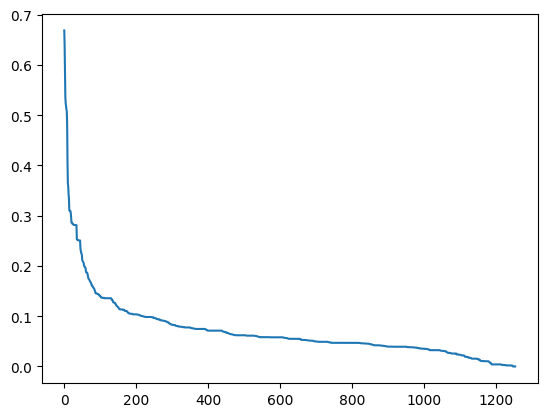

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(JS_dist_pd['jensen_shannon_dist'].values)

plt.show()

##### (!) существенные отличия в распределениях имеет не так много признаков

In [ ]:
JS_dist_pd[JS_dist_pd['jensen_shannon_dist']>0.2]

jensen_shannon_dist
Терапия1_ИМТ_ЗначениеПредставление                             0.668456
Профессия                                                      0.639031
Офтальмология1_Диагноз_ЗначениеПредставление                   0.591787
Офтальмология1_ODДополнение_ЗначениеПредставление              0.535683
Офтальмология1_МКБ101                                          0.523506
Офтальмология1_ХР_Рекомендация1Представление                   0.517350
Офтальмология1_OSДополнение_ЗначениеПредставление              0.511572
ДиспансернаяГруппаПредставление                                0.507783
Офтальмология1_АнамнезДополнение_ЗначениеПредст...             0.483008
Цех                                                            0.406711
Офтальмология1_РефракцияДополнение_ЗначениеПред...             0.364139
Офтальмология1_Рефракция1_ЗначениеПредставление                0.358444
Терапия1_Вес_ЗначениеПредставление                             0.342579
Терапия1_АнамнезДополнение_ЗначениеПредставление               0.334705
ПсихиатрияНаркология1_Внимание_ЗначениеПредстав...             0.310895
Офтальмология1_OS_ЗначениеПредставление                        0.309726
ДатаЗавершенияМедосмотра                                       0.309678
Терапия1_АртериальноеДавление_ЗначениеПредставл...             0.309353
Офтальмология1_OD_ЗначениеПредставление                        0.305922
Гинекология1_ДатаПоследнейMensis_ЗначениеПредст...             0.297652
Терапия1_АртериальноеДавление21_ЗначениеПредста...             0.286311
Офтальмология1_Анамнез_ЗначениеПредставление                   0.285969
УЗИДиагностика1_ЭндометрийТолщиной_ЗначениеПред...             0.285631
Офтальмология1_ПрофнепригодностьВременнаяПредст...             0.283569
Офтальмология1_Цветовосприятие_ЗначениеПредстав...             0.283408
Офтальмология1_ДвигательныйАппаратГлаз_Значение...             0.282384
Офтальмология1_Жалобы_ЗначениеПредставление                    0.281929
Офтальмология1_ДискиЗрительныхНервовБледноРозов...             0.281500
Офтальмология1_ГраницыЧеткие_ЗначениеПредставление             0.281500
Терапия2_ИМТ_ЗначениеПредставление                             0.281396
Офтальмология1_СпециализацияПредставление                      0.281357
Офтальмология1_СлезныеПути_ЗначениеПредставление               0.281357
Офтальмология1_ГоденНегоден_ЗначениеПредставление              0.281357
Офтальмология1_ПоляЗрения_ЗначениеПредставление                0.281177
Терапия1_П_ЗначениеПредставление                               0.281116
Офтальмология1_ЗащитныйАппаратГлаз_ЗначениеПред...             0.252558
Офтальмология1_Конъюнктива1_ЗначениеПредставление              0.252558
Офтальмология1_ГлазноеДно_ЗначениеПредставление                0.251872
Офтальмология1_Радужка_ЗначениеПредставление                   0.251296
Офтальмология1_Роговица_ЗначениеПредставление                  0.251296
Офтальмология1_СосудыСреднегоКалибра_ЗначениеПр...             0.250732
Офтальмология1_СетчаткаПрилежит_ЗначениеПредста...             0.250701
Офтальмология1_СтекловидноеТело_ЗначениеПредста...             0.250664
Офтальмология1_РеакцияНаСвет_ЗначениеПредставление             0.250664
Офтальмология1_ПередняяКамера_ЗначениеПредставл...             0.250664
УЗИДиагностика1_ЭхокартинаНаМоментОсмотра_Значе...             0.234536
Терапия2_Вес_ЗначениеПредставление                             0.229987
Терапия1_Рост_ЗначениеПредставление                            0.225732
Офтальмология1_МКБ102                                          0.224834
Терапия2_АртериальноеДавление_ЗначениеПредставл...             0.221881
ПсихиатрияНаркология1_ДиагнозДополнение_Значени...             0.211947
Гинекология1_ДиагнозДополнение_ЗначениеПредстав...             0.209828
Терапия2_Рост_ЗначениеПредставление                            0.208409
УЗИДиагностика1_Ширина_ЗначениеПредставление                   0.207111
Эндоскопия1_ЖалобыДополнение_ЗначениеПредставление             0.206010
Терапия1_МКБ101     

## Модели

## 03.05.23 Модели по набору факторов, имеющих потенциально хорошую объясняющую силу (по разнице распределения фактора на классах "годен" /"ограниченно годен")

#### оcтавлю все МКБ, "вредные факторы", возраст и потенциально важные факторы

In [ ]:

cutoff = 0.2
q = JS_dist_pd[JS_dist_pd['jensen_shannon_dist']>cutoff].index.tolist()
print(len(q))

q = sorted(list(set(q + data.columns[data.columns.str.contains('МКБ')].tolist())))
print(len(q))
q

56
145


['Гинекология1_ДатаПоследнейMensis_ЗначениеПредставление',
 'Гинекология1_ДиагнозДополнение_ЗначениеПредставление',
 'Гинекология1_МКБ101',
 'Гинекология1_МКБ102',
 'Гинекология2_МКБ101',
 'Гинекология2_МКБ102',
 'Гинекология3_МКБ101',
 'Гинекология3_МКБ102',
 'Гинекология4_МКБ101',
 'Гинекология4_МКБ102',
 'ДатаЗавершенияМедосмотра',
 'Дерматовенерология1_МКБ101',
 'Дерматовенерология1_МКБ102',
 'Дерматовенерология2_МКБ101',
 'Дерматовенерология2_МКБ102',
 'ДиспансернаяГруппаПредставление',
 'ЛабораторныеИсследования1_МКБ101',
 'ЛабораторныеИсследования1_МКБ102',
 'ЛабораторныеИсследования2_МКБ101',
 'ЛабораторныеИсследования2_МКБ102',
 'Неврология1_МКБ101',
 'Неврология1_МКБ102',
 'Неврология2_МКБ101',
 'Неврология2_МКБ102',
 'Оториноларингология1_МКБ101',
 'Оториноларингология1_МКБ102',
 'Оториноларингология1_МКБ103',
 'Оториноларингология1_МКБ104',
 'Оториноларингология2_МКБ101',
 'Оториноларингология2_МКБ102',
 'Оториноларингология2_МКБ103',
 'Оториноларингология2_МКБ104',
 'Отори

In [ ]:
q.remove('ДатаЗавершенияМедосмотра')
q.remove('Профессия')
q.remove('Цех')


In [ ]:
print(len(q))

142


In [ ]:
q

['Гинекология1_ДатаПоследнейMensis_ЗначениеПредставление',
 'Гинекология1_ДиагнозДополнение_ЗначениеПредставление',
 'Гинекология1_МКБ101',
 'Гинекология1_МКБ102',
 'Гинекология2_МКБ101',
 'Гинекология2_МКБ102',
 'Гинекология3_МКБ101',
 'Гинекология3_МКБ102',
 'Гинекология4_МКБ101',
 'Гинекология4_МКБ102',
 'Дерматовенерология1_МКБ101',
 'Дерматовенерология1_МКБ102',
 'Дерматовенерология2_МКБ101',
 'Дерматовенерология2_МКБ102',
 'ДиспансернаяГруппаПредставление',
 'ЛабораторныеИсследования1_МКБ101',
 'ЛабораторныеИсследования1_МКБ102',
 'ЛабораторныеИсследования2_МКБ101',
 'ЛабораторныеИсследования2_МКБ102',
 'Неврология1_МКБ101',
 'Неврология1_МКБ102',
 'Неврология2_МКБ101',
 'Неврология2_МКБ102',
 'Оториноларингология1_МКБ101',
 'Оториноларингология1_МКБ102',
 'Оториноларингология1_МКБ103',
 'Оториноларингология1_МКБ104',
 'Оториноларингология2_МКБ101',
 'Оториноларингология2_МКБ102',
 'Оториноларингология2_МКБ103',
 'Оториноларингология2_МКБ104',
 'Оториноларингология3_МКБ101',
 'Оф

##### разбиение признаков на количественные и качественные

In [ ]:
aux = data[q].dtypes
columns_float = aux[aux!='object'].index.tolist()
columns_float

['Терапия1_АртериальноеДавление21_ЗначениеПредставление',
 'Терапия1_Вес_ЗначениеПредставление',
 'Терапия1_ИМТ_ЗначениеПредставление',
 'Терапия1_П_ЗначениеПредставление',
 'Терапия1_Рост_ЗначениеПредставление',
 'Терапия2_Вес_ЗначениеПредставление',
 'Терапия2_ИМТ_ЗначениеПредставление',
 'Терапия2_Рост_ЗначениеПредставление']

In [ ]:
aux = data[q].dtypes
columns_str = aux[aux=='object'].index.tolist()
columns_str

['Гинекология1_ДатаПоследнейMensis_ЗначениеПредставление',
 'Гинекология1_ДиагнозДополнение_ЗначениеПредставление',
 'Гинекология1_МКБ101',
 'Гинекология1_МКБ102',
 'Гинекология2_МКБ101',
 'Гинекология2_МКБ102',
 'Гинекология3_МКБ101',
 'Гинекология3_МКБ102',
 'Гинекология4_МКБ101',
 'Гинекология4_МКБ102',
 'Дерматовенерология1_МКБ101',
 'Дерматовенерология1_МКБ102',
 'Дерматовенерология2_МКБ101',
 'Дерматовенерология2_МКБ102',
 'ДиспансернаяГруппаПредставление',
 'ЛабораторныеИсследования1_МКБ101',
 'ЛабораторныеИсследования1_МКБ102',
 'ЛабораторныеИсследования2_МКБ101',
 'ЛабораторныеИсследования2_МКБ102',
 'Неврология1_МКБ101',
 'Неврология1_МКБ102',
 'Неврология2_МКБ101',
 'Неврология2_МКБ102',
 'Оториноларингология1_МКБ101',
 'Оториноларингология1_МКБ102',
 'Оториноларингология1_МКБ103',
 'Оториноларингология1_МКБ104',
 'Оториноларингология2_МКБ101',
 'Оториноларингология2_МКБ102',
 'Оториноларингология2_МКБ103',
 'Оториноларингология2_МКБ104',
 'Оториноларингология3_МКБ101',
 'Оф

In [ ]:
columns_MKB = [elem for elem in columns_str if elem.find('МКБ')!=-1]
columns_MKB

['Гинекология1_МКБ101',
 'Гинекология1_МКБ102',
 'Гинекология2_МКБ101',
 'Гинекология2_МКБ102',
 'Гинекология3_МКБ101',
 'Гинекология3_МКБ102',
 'Гинекология4_МКБ101',
 'Гинекология4_МКБ102',
 'Дерматовенерология1_МКБ101',
 'Дерматовенерология1_МКБ102',
 'Дерматовенерология2_МКБ101',
 'Дерматовенерология2_МКБ102',
 'ЛабораторныеИсследования1_МКБ101',
 'ЛабораторныеИсследования1_МКБ102',
 'ЛабораторныеИсследования2_МКБ101',
 'ЛабораторныеИсследования2_МКБ102',
 'Неврология1_МКБ101',
 'Неврология1_МКБ102',
 'Неврология2_МКБ101',
 'Неврология2_МКБ102',
 'Оториноларингология1_МКБ101',
 'Оториноларингология1_МКБ102',
 'Оториноларингология1_МКБ103',
 'Оториноларингология1_МКБ104',
 'Оториноларингология2_МКБ101',
 'Оториноларингология2_МКБ102',
 'Оториноларингология2_МКБ103',
 'Оториноларингология2_МКБ104',
 'Оториноларингология3_МКБ101',
 'Офтальмология1_МКБ101',
 'Офтальмология1_МКБ102',
 'Офтальмология1_МКБ103',
 'Офтальмология1_МКБ104',
 'Офтальмология2_МКБ101',
 'Офтальмология2_МКБ102',


##### one-hot encoding кодов МКБ

In [ ]:
X_MKB_onehot = pd.concat([pd.get_dummies(data[elem], dummy_na=True, prefix=elem) for elem in columns_MKB],axis=1)
X_MKB_onehot

Гинекология1_МКБ101_D25  Гинекология1_МКБ101_D25.9  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   
...                       ...                        ...   
1961                        0                          0   
1962                        0                          0   
1972                        0                          0   
1973                        0                          0   
1981                        0                          0   

      Гинекология1_МКБ101_N60.2  Гинекология1_МКБ101_N80.0  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
...                         ...                        ...   
1961                          0                          0   
1962                          0                          0   
1972                          0                          0   
1973                          0                          0   
1981                          0                          0   

      Гинекология1_МКБ101_N83.2  Гинекология1_МКБ101_Z00.0  \
0                             0                          1   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
...                         ...                        ...   
1961                          0                          0   
1962                          0                          0   
1972                          0                          0   
1973                          0                          0   
1981                          0                          0   

      Гинекология1_МКБ101_nan  Гинекология1_МКБ102_D25.9  \
0                           0                          0   
1                           1                          0   
2                           1                          0   
3                           1                          0   
4                           1                          0   
...                       ...                        ...   
1961                        1                          0   
1962                        1                          0   
1972                        1                          0   
1973                        1                          0   
1981                        1                          0   

      Гинекология1_МКБ102_H52.1  Гинекология1_МКБ102_Z00.0  ...  \
0                             0                          0  ...   
1                             0                          0  ...   
2                             0                          0  ...   
3                             0                          0  ...   
4                             0                          0  ...   
...                         ...                        ...  ...   
1961                          0                          0  ...   
1962                          0                          0  ...   
1972                          0                          0  ...   
1973                          0                          0  ...   
1981                          0                          0  ...   

      Хирургия2_МКБ101_nan  Хирургия2_МКБ102_K40.9  Хирургия2_МКБ102_Z00.0  \
0                        1                       0                       0   
1                        1                       0                       0   
2                        1         

##### очистка и/или отбрасывание новых (предположительно) качественных столбцов

In [ ]:
columns_no_MKB = [elem for elem in columns_str if elem.find('МКБ')==-1]
print(len(columns_no_MKB))
columns_no_MKB

42


['Гинекология1_ДатаПоследнейMensis_ЗначениеПредставление',
 'Гинекология1_ДиагнозДополнение_ЗначениеПредставление',
 'ДиспансернаяГруппаПредставление',
 'Офтальмология1_OD_ЗначениеПредставление',
 'Офтальмология1_ODДополнение_ЗначениеПредставление',
 'Офтальмология1_OS_ЗначениеПредставление',
 'Офтальмология1_OSДополнение_ЗначениеПредставление',
 'Офтальмология1_Анамнез_ЗначениеПредставление',
 'Офтальмология1_АнамнезДополнение_ЗначениеПредставление',
 'Офтальмология1_ГлазноеДно_ЗначениеПредставление',
 'Офтальмология1_ГоденНегоден_ЗначениеПредставление',
 'Офтальмология1_ГраницыЧеткие_ЗначениеПредставление',
 'Офтальмология1_ДвигательныйАппаратГлаз_ЗначениеПредставление',
 'Офтальмология1_Диагноз_ЗначениеПредставление',
 'Офтальмология1_ДискиЗрительныхНервовБледноРозовые_ЗначениеПредставление',
 'Офтальмология1_Жалобы_ЗначениеПредставление',
 'Офтальмология1_ЗащитныйАппаратГлаз_ЗначениеПредставление',
 'Офтальмология1_Конъюнктива1_ЗначениеПредставление',
 'Офтальмология1_ПередняяКамер

###### 'Гинекология1_ДатаПоследнейMensis_ЗначениеПредставление'

In [ ]:
X_no_MKB = pd.DataFrame()

In [ ]:
data['Гинекология1_ДатаПоследнейMensis_ЗначениеПредставление'].value_counts(dropna=False)

NaN           1341
04.11.2022       9
01.11.2022       7
20.10.2022       7
13.11.2022       6
              ... 
081022           1
09 10 22         1
18 10 22         1
05 10 22         1
16/11/2022       1
Name: Гинекология1_ДатаПоследнейMensis_ЗначениеПредставление, Length: 128, dtype: int64

удалить

In [ ]:
columns_no_MKB.remove('Гинекология1_ДатаПоследнейMensis_ЗначениеПредставление')

###### 'Гинекология1_ДиагнозДополнение_ЗначениеПредставление'

In [ ]:
data['Гинекология1_ДиагнозДополнение_ЗначениеПредставление'].value_counts(dropna=False)

NaN                                                    1485
1. узи омт 2. обследование и лечение гинеколога          10
1. УЗИ ОМТ 2. ОБСЛЕДОВАНИЕ И ЛЕЧЕНИЕ ГИНЕКОЛОГА           7
ст.чистоты №4_x000D_\nцитология №4                        4
ст.чистоты №1_x000D_\nцитология №1                        3
                                                       ... 
предметное стекло №4                                      1
предметное стекло №7                                      1
предметное стекло №16                                     1
предметное стекло № 3_x000D_\nРекомендации:УЗИ ОМТ.       1
ампутация матки без придатков в 2009г                     1
Name: Гинекология1_ДиагнозДополнение_ЗначениеПредставление, Length: 63, dtype: int64

???????

In [ ]:
aux = pd.DataFrame(np.where(data['Гинекология1_ДиагнозДополнение_ЗначениеПредставление'].isna(),1,0), columns = ['Гинекология1_ДиагнозДополнение_ЗначениеПредставление'+'_na'], index=data.index)
aux['Гинекология1_ДиагнозДополнение_ЗначениеПредставление'+'_other'] = np.where(data['Гинекология1_ДиагнозДополнение_ЗначениеПредставление'].isna(),0,1)
aux

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  
0                                                     0           
1                                                     0           
2                                                     0           
3                                                     0           
4                                                     0           
...                                                 ...           
1961                                                  0           
1962                                                  0           
1972                                                  0           
1973                                                  0           
1981                                                  0           

[1571 rows x 2 columns]

In [ ]:
X_no_MKB = pd.concat([X_no_MKB, aux])
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  
0                                                     0           
1                                                     0           
2                                                     0           
3                                                     0           
4                                                     0           
...                                                 ...           
1961                                                  0           
1962                                                  0           
1972                                                  0           
1973                                                  0           
1981                                                  0           

[1571 rows x 2 columns]

###### 'ДиспансернаяГруппаПредставление'

In [ ]:
data['ДиспансернаяГруппаПредставление'].value_counts(dropna=False)

I       779
II      389
IIIа    369
IIIб     25
NaN       9
Name: ДиспансернаяГруппаПредставление, dtype: int64

оставить

In [ ]:
aux = pd.get_dummies(data['ДиспансернаяГруппаПредставление'], prefix='ДиспансернаяГруппаПредставление', dummy_na=True)
aux

ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  
...                                   ...  
1961                                    0  
1962                                    0  
1972                                    0  
1973                                    0  
1981                                    1  

[1571 rows x 5 columns]

In [ ]:
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  
...                                   ...  
1961                                    0  
1

###### 'Офтальмология1_OD_ЗначениеПредставление'

In [ ]:
data['Офтальмология1_OD_ЗначениеПредставление'].value_counts(dropna=False)

прозрачный    982
NaN           561
помутнение     16
1,0             5
в/о             3
N               1
0,9             1
20              1
-1,50           1
Name: Офтальмология1_OD_ЗначениеПредставление, dtype: int64

???????


In [ ]:
aux = pd.DataFrame(np.where(data['Офтальмология1_OD_ЗначениеПредставление'].isna(),1,0), columns = ['Офтальмология1_OD_ЗначениеПредставление'+'_na'], index=data.index)
aux['Офтальмология1_OD_ЗначениеПредставление'+'_прозрачный'] = np.where(data['Офтальмология1_OD_ЗначениеПредставление']=='прозрачный',1,0)
aux['Офтальмология1_OD_ЗначениеПредставление'+'_other'] = np.where((data['Офтальмология1_OD_ЗначениеПредставление']!='прозрачный')&(data['Офтальмология1_OD_ЗначениеПредставление'].notna()),1,0)
aux

Офтальмология1_OD_ЗначениеПредставление_na  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
1961                                           0   
1962                                           1   
1972                                           0   
1973                                           0   
1981                                           1   

      Офтальмология1_OD_ЗначениеПредставление_прозрачный  \
0                                                     0    
1                                                     0    
2                                                     0    
3                                                     0    
4                                                     0    
...                                                 ...    
1961                                                  1    
1962                                                  0    
1972                                                  1    
1973                                                  1    
1981                                                  0    

      Офтальмология1_OD_ЗначениеПредставление_other  
0                                                 1  
1                                                 1  
2                                                 1  
3                                                 1  
4                                                 1  
...                                             ...  
1961                                              0  
1962                                              0  
1972                                              0  
1973                                              0  
1981                                              0  

[1571 rows x 3 columns]

In [ ]:
aux.sum()

Офтальмология1_OD_ЗначениеПредставление_na            561
Офтальмология1_OD_ЗначениеПредставление_прозрачный    982
Офтальмология1_OD_ЗначениеПредставление_other          28
dtype: int64

In [ ]:
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_ODДополнение_ЗначениеПредставление'

In [ ]:
data['Офтальмология1_ODДополнение_ЗначениеПредставление'].value_counts(dropna=False)

NaN      1256
1.0       110
1,0       101
0,9        23
0,8        14
0.9        14
0,7        11
0,5        10
0,6         8
0.8         4
0.7         3
0,4         3
0.5         3
0.6         2
0.3         2
0,3         2
0,2         1
0.4         1
0.1         1
0,3нк       1
в/о         1
Name: Офтальмология1_ODДополнение_ЗначениеПредставление, dtype: int64

In [ ]:
data['Офтальмология1_ODДополнение_ЗначениеПредставление'] = data['Офтальмология1_ODДополнение_ЗначениеПредставление'].str.replace(',', '.')
data['Офтальмология1_ODДополнение_ЗначениеПредставление'].value_counts(dropna=False)

NaN      1256
1.0       211
0.9        37
0.8        18
0.7        14
0.5        13
0.6        10
0.4         4
0.3         4
в/о         1
0.2         1
0.1         1
0.3нк       1
Name: Офтальмология1_ODДополнение_ЗначениеПредставление, dtype: int64

In [ ]:
feature = 'Офтальмология1_ODДополнение_ЗначениеПредставление'
aux = pd.DataFrame(np.where(data[feature].isna(),1,0), columns = [feature+'_na'], index=data.index)
aux[feature+'_1'] = np.where(data[feature]=='1.0',1,0)
aux[feature+'_0.9'] = np.where(data[feature]=='0.9',1,0)
aux[feature+'_0.8'] = np.where(data[feature]=='0.8',1,0)
aux[feature+'_0.7'] = np.where(data[feature]=='0.7',1,0)
aux[feature+'_0.5'] = np.where(data[feature]=='0.5',1,0)
aux[feature+'_0.6'] = np.where(data[feature]=='0.6',1,0)
aux[feature+'_other'] = 1-aux.sum(axis=1)
aux

Офтальмология1_ODДополнение_ЗначениеПредставление_na  \
0                                                     1      
1                                                     1      
2                                                     0      
3                                                     1      
4                                                     0      
...                                                 ...      
1961                                                  1      
1962                                                  1      
1972                                                  1      
1973                                                  1      
1981                                                  1      

      Офтальмология1_ODДополнение_ЗначениеПредставление_1  \
0                                                     0     
1                                                     0     
2                                                     1     
3                                                     0     
4                                                     0     
...                                                 ...     
1961                                                  0     
1962                                                  0     
1972                                                  0     
1973                                                  0     
1981                                                  0     

      Офтальмология1_ODДополнение_ЗначениеПредставление_0.9  \
0                                                     0       
1                                                     0       
2                                                     0       
3                                                     0       
4                                                     1       
...                                                 ...       
1961                                                  0       
1962                                                  0       
1972                                                  0       
1973                                                  0       
1981                                                  0       

      Офтальмология1_ODДополнение_ЗначениеПредставление_0.8  \
0                                                     0       
1                                                     0       
2                                                     0       
3                                                     0       
4                                                     0       
...                                                 ...       
1961                                                  0       
1962                                                  0       
1972                                                  0       
1973                                                  0       
1981                                                  0       

      Офтальмология1_ODДополнение_ЗначениеПредставление_0.7  \
0                                                     0       
1                                                     0       
2                                                     0       
3                                                     0       
4                                                     0       
...                                                 ...       
1961                                                  0       
1962                                                  0       
1972                                                  0       
1973                                                  0       
1981                                                  0       

      Офтальмология1_ODДополнение_ЗначениеПредставление_0.5  \
0                                                     0       
1                                                     0       
2                                                     0       
3    

In [ ]:
aux.sum()

Офтальмология1_ODДополнение_ЗначениеПредставление_na       1256
Офтальмология1_ODДополнение_ЗначениеПредставление_1         211
Офтальмология1_ODДополнение_ЗначениеПредставление_0.9        37
Офтальмология1_ODДополнение_ЗначениеПредставление_0.8        18
Офтальмология1_ODДополнение_ЗначениеПредставление_0.7        14
Офтальмология1_ODДополнение_ЗначениеПредставление_0.5        13
Офтальмология1_ODДополнение_ЗначениеПредставление_0.6        10
Офтальмология1_ODДополнение_ЗначениеПредставление_other      12
dtype: int64

In [ ]:
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### Офтальмология1_OS_ЗначениеПредставление

In [ ]:
feature = 'Офтальмология1_OS_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

прозрачный    982
NaN           561
помутнение     15
1,0             4
в/о             3
N               1
+1,50           1
0,9             1
21              1
-1,50           1
афакия          1
Name: Офтальмология1_OS_ЗначениеПредставление, dtype: int64

повторяет 'Офтальмология1_OD_ЗначениеПредставление'.
удалить

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_OSДополнение_ЗначениеПредставление'



In [ ]:
feature = 'Офтальмология1_OSДополнение_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN        1264
1.0         111
1,0          97
0,7          24
0,9          17
0,8          14
0.7           7
0,6           6
0.9           6
0.8           6
0,3           3
0,2           2
0,5           2
0.5           2
0,1-0,2       2
0,2 нк        1
0,4           1
0,            1
0.6           1
0,8нк         1
0,3нк         1
0.4           1
0.3           1
Name: Офтальмология1_OSДополнение_ЗначениеПредставление, dtype: int64

почти повторяет 'Офтальмология1_OS_ЗначениеПредставление'.
удалить

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_Анамнез_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_Анамнез_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

не отягощен    1007
NaN             561
отягощен          3
Name: Офтальмология1_Анамнез_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)

In [ ]:
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_АнамнезДополнение_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_АнамнезДополнение_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN                                                          1414
носит очки -1.50                                                7
носит очки -1.0                                                 5
носит очки -2.50                                                4
очки для чтения +1.5                                            4
                                                             ... 
носит очки -1.50/-1.50                                          1
носит очки -4.50                                                1
носит мкл -2.75 с астигматизмом, склеропластика в детстве       1
ласик в начале окт 2022, было -1.0                              1
2019г Лазик (-3.0)                                              1
Name: Офтальмология1_АнамнезДополнение_ЗначениеПредставление, Length: 115, dtype: int64

удалить

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_ГлазноеДно_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_ГлазноеДно_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

не подлежит обследованию    771
NaN                         573
осмотрено                   227
Name: Офтальмология1_ГлазноеДно_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_ГоденНегоден_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_ГоденНегоден_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

Годен    1010
NaN       561
Name: Офтальмология1_ГоденНегоден_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_ГраницыЧеткие_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_ГраницыЧеткие_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

Нет    957
NaN    561
Да      53
Name: Офтальмология1_ГраницыЧеткие_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_ДвигательныйАппаратГлаз_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_ДвигательныйАппаратГлаз_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

без патологии      1007
NaN                 561
с особенностями       3
Name: Офтальмология1_ДвигательныйАппаратГлаз_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_Диагноз_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_Диагноз_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                 568
[Z00.0] Общий медицинский осмотр_x000D_\n                                                                                                                                                                                           563
[H52.1] Миопия_x000D_\n                                                                                                                                                                                                             108
[H52.0] Гиперметропия_x000D_\n                                                                                                                                                                                                       45
[H52.1] Миопия_x000D_\nОписание: Миопия сл ст ОИ_x000D_\n               

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_ДискиЗрительныхНервовБледноРозовые_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_ДискиЗрительныхНервовБледноРозовые_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

Нет    957
NaN    561
Да      53
Name: Офтальмология1_ДискиЗрительныхНервовБледноРозовые_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_Жалобы_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_Жалобы_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

не предъявляет    1009
NaN                561
предъявляет          1
Name: Офтальмология1_Жалобы_ЗначениеПредставление, dtype: int64

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_ЗащитныйАппаратГлаз_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_ЗащитныйАппаратГлаз_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

без патологии      995
NaN                573
с особенностями      3
Name: Офтальмология1_ЗащитныйАппаратГлаз_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_Конъюнктива1_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_Конъюнктива1_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

бледно – розовая    995
NaN                 573
птеригиум             2
гиперемирована        1
Name: Офтальмология1_Конъюнктива1_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_ПередняяКамера_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_ПередняяКамера_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

средней глубины    998
NaN                573
Name: Офтальмология1_ПередняяКамера_ЗначениеПредставление, dtype: int64

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_ПоляЗрения_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_ПоляЗрения_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

без патологии               583
NaN                         573
не подлежит обследованию    413
с особенностями               2
Name: Офтальмология1_ПоляЗрения_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_ПрофнепригодностьВременнаяПредставление1'

In [ ]:
feature = 'Офтальмология1_ПрофнепригодностьВременнаяПредставление1'
data[feature].value_counts(dropna=False)

Годен              981
NaN                578
Годен, кроме п.     10
Не годен             2
Name: Офтальмология1_ПрофнепригодностьВременнаяПредставление1, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_Радужка_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_Радужка_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

без патологии      997
NaN                573
с особенностями      1
Name: Офтальмология1_Радужка_ЗначениеПредставление, dtype: int64

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_РеакцияНаСвет_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_РеакцияНаСвет_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

живая    998
NaN      573
Name: Офтальмология1_РеакцияНаСвет_ЗначениеПредставление, dtype: int64

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_Рефракция1_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_Рефракция1_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

эмметропическая       641
NaN                   573
миопическая           160
астигматическая       102
гиперметропическая     95
Name: Офтальмология1_Рефракция1_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_РефракцияДополнение_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_РефракцияДополнение_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN                              1348
+0,50/+0,25                         4
-0,75/-0,75                         3
-1,25/-1,25                         3
+0,75/+1,25                         3
                                 ... 
-0,50/-0,75                         1
+1,00 -1,25 64/+0,75 -1,50 96       1
-0,50/-0,25                         1
+0,25 -0,25/+0,50 -0,50             1
-0,75 -0,50/-0,50                   1
Name: Офтальмология1_РефракцияДополнение_ЗначениеПредставление, Length: 198, dtype: int64

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_Роговица_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_Роговица_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

прозрачная    997
NaN           573
помутнение      1
Name: Офтальмология1_Роговица_ЗначениеПредставление, dtype: int64

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_СетчаткаПрилежит_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_СетчаткаПрилежит_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

Нет    947
NaN    573
Да      51
Name: Офтальмология1_СетчаткаПрилежит_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_СлезныеПути_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_СлезныеПути_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

проходимы    1010
NaN           561
Name: Офтальмология1_СлезныеПути_ЗначениеПредставление, dtype: int64

###### 'Офтальмология1_СосудыСреднегоКалибра_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_СосудыСреднегоКалибра_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

Нет    946
NaN    573
Да      52
Name: Офтальмология1_СосудыСреднегоКалибра_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_СпециализацияПредставление'

In [ ]:
feature = 'Офтальмология1_СпециализацияПредставление'
data[feature].value_counts(dropna=False)

Офтальмология    1010
NaN               561
Name: Офтальмология1_СпециализацияПредставление, dtype: int64

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_СтекловидноеТело_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_СтекловидноеТело_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

прозрачное    998
NaN           573
Name: Офтальмология1_СтекловидноеТело_ЗначениеПредставление, dtype: int64

In [ ]:
columns_no_MKB.remove(feature)

###### 'Офтальмология1_ХР_Рекомендация1Представление'

In [ ]:
feature = 'Офтальмология1_ХР_Рекомендация1Представление'
data[feature].value_counts(dropna=False)

NaN                                                      1229
Использование средств оптической коррекции зрения         139
Наблюдение офтальмолога по мж                              92
Допуск с ношением средств оптической коррекции зрения      87
набдюдение по месту жительства                             20
Обследование и лечение офтальмолога                         3
Осмотр глазного дна 1 р/год                                 1
Name: Офтальмология1_ХР_Рекомендация1Представление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Офтальмология1_Цветовосприятие_ЗначениеПредставление'

In [ ]:
feature = 'Офтальмология1_Цветовосприятие_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

не подлежит обследованию    801
NaN                         561
нормальный трихромат        207
с особенностями               2
Name: Офтальмология1_Цветовосприятие_ЗначениеПредставление, dtype: int64

In [ ]:
aux = pd.get_dummies(data[feature], dummy_na=True, prefix=feature)
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'ПсихиатрияНаркология1_Внимание_ЗначениеПредставление'

In [ ]:
feature = 'ПсихиатрияНаркология1_Внимание_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

устойчивое                                                    821
NaN                                                           356
т. Шульте 35 сек., счет по Крепелину выполняет                 21
т. Шульте 35  сек., счет по Крепелину выполняет                19
т. Шульте 55  сек., счет по Крепелину выполняет                18
                                                             ... 
т. Шульте 65  сек., счет по Крепелину выполняет с ошибками      1
т.Шульте 33 сек., счет по Крепелину выполняет                   1
т.Шульте 63 сек., счет по Крепелину выполняет с ошибками        1
т.Шульте  42  сек., счет по Крепелину выполняет                 1
т.Шульте 73 сек., счет по Крепелину выполняет с ошибками        1
Name: ПсихиатрияНаркология1_Внимание_ЗначениеПредставление, Length: 170, dtype: int64

In [ ]:
data[feature] = data[feature].str.replace(r'  *', ' ', regex=True)
data[feature].value_counts(dropna=False)


устойчивое                                                   821
NaN                                                          356
т. Шульте 35 сек., счет по Крепелину выполняет                40
т. Шульте 55 сек., счет по Крепелину выполняет                35
т. Шульте 37 сек., счет по Крепелину выполняет                15
                                                            ... 
т. Шульте 31 сек., счет по Крепелину выполняет                 1
т. Шульте 92 сек., счет по Крепелину выполняет с ошибками      1
т. Шульте 65 сек., счет по Крепелину выполняет с ошибками      1
т.Шульте 63 сек., счет по Крепелину выполняет с ошибками       1
т.Шульте 73 сек., счет по Крепелину выполняет с ошибками       1
Name: ПсихиатрияНаркология1_Внимание_ЗначениеПредставление, Length: 128, dtype: int64

In [ ]:
aux = pd.DataFrame(np.where(data[feature].isna(),1,0), columns = [feature+'_na'], index=data.index)
aux[feature+'_устойчивое'] = np.where(data[feature]=='устойчивое',1,0)
aux[feature+'_с ошибками'] = np.where(data[feature].str.contains('с ошибками')&data[feature].notna(),1,0)
aux[feature+'_other'] = 1-aux.sum(axis=1)
aux

ПсихиатрияНаркология1_Внимание_ЗначениеПредставление_na  \
0                                                     0         
1                                                     0         
2                                                     0         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  0         
1962                                                  0         
1972                                                  0         
1973                                                  0         
1981                                                  0         

      ПсихиатрияНаркология1_Внимание_ЗначениеПредставление_устойчивое  \
0                                                     1                 
1                                                     1                 
2                                                     1                 
3                                                     0                 
4                                                     0                 
...                                                 ...                 
1961                                                  1                 
1962                                                  1                 
1972                                                  1                 
1973                                                  0                 
1981                                                  1                 

      ПсихиатрияНаркология1_Внимание_ЗначениеПредставление_с ошибками  \
0                                                     0                 
1                                                     0                 
2                                                     0                 
3                                                     0                 
4                                                     0                 
...                                                 ...                 
1961                                                  0                 
1962                                                  0                 
1972                                                  0                 
1973                                                  0                 
1981                                                  0                 

      ПсихиатрияНаркология1_Внимание_ЗначениеПредставление_other  
0                                                     0           
1                                                     0           
2                                                     0           
3                                                     0           
4                                                     0           
...                                                 ...           
1961                                                  0           
1962                                                  0           
1972                                                  0           
1973                                                  1           
1981                                                  0           

[1571 rows x 4 columns]

In [ ]:
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'ПсихиатрияНаркология1_ДиагнозДополнение_ЗначениеПредставление'

In [ ]:
feature = 'ПсихиатрияНаркология1_ДиагнозДополнение_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN                                                                                                                                                                      1177
Тесты на обобщение и исключение выполняет. В бытовых вопросах ориентируется. Критика достаточная.                                                                         160
Тесты на обобщение и исключение выполняет. В бытовых вопросах ориентируется. Критика достаточная._x000D_\n                                                                 42
Тесты на обобщение и исключение выполняет в простых вариантах. В бытовых вопросах ориентируется. Критика достаточная.                                                      35
Тесты на обобщение и исключение выполняет. В бытовых вопросах ориентируется. критика достаточная.                                                                          24
                                                                                                                                  

In [ ]:
columns_no_MKB.remove(feature)

###### 'Терапия1_АнамнезДополнение_ЗначениеПредставление'

In [ ]:
feature = 'Терапия1_АнамнезДополнение_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN                                                                                                                                    1306
АГ                                                                                                                                       13
Курит                                                                                                                                     8
Гипертоническая болезнь.                                                                                                                  7
Заключение: Патологии со стороны слизистой пищевода, желудка и 12 п.к. не выявлено.                                                       5
                                                                                                                                       ... 
Заключение: Субатрофический гастрит. Панкреатогастростомия.                                                                               1
Компрессионный перел

In [ ]:
columns_no_MKB.remove(feature)

###### 'Терапия1_АртериальноеДавление_ЗначениеПредставление'

In [ ]:
feature = 'Терапия1_АртериальноеДавление_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

120       443
NaN       182
130       147
125       122
110       100
         ... 
125/85      1
140/80      1
120/70      1
105/70      1
101         1
Name: Терапия1_АртериальноеДавление_ЗначениеПредставление, Length: 93, dtype: int64

In [ ]:
aux = data[data.columns[data.columns.str.contains('АртериальноеДавление')&data.columns.str.contains('ЗначениеПредставление')]]
aux

Терапия1_АртериальноеДавление_ЗначениеПредставление  \
0                                               140/100    
1                                               150/100    
2                                                120/80    
3                                                120\80    
4                                                110/70    
...                                                 ...    
1961                                                120    
1962                                                120    
1972                                                125    
1973                                                131    
1981                                                130    

     Терапия2_АртериальноеДавление_ЗначениеПредставление  \
0                                                   NaN    
1                                                   NaN    
2                                                   NaN    
3                                                   NaN    
4                                                   NaN    
...                                                 ...    
1961                                                NaN    
1962                                                NaN    
1972                                                NaN    
1973                                                NaN    
1981                                                NaN    

      Терапия1_АртериальноеДавление21_ЗначениеПредставление  \
0                                                   NaN       
1                                                   NaN       
2                                                   NaN       
3                                                   NaN       
4                                                   NaN       
...                                                 ...       
1961                                               70.0       
1962                                               70.0       
1972                                               80.0       
1973                                               71.0       
1981                                               80.0       

      Терапия2_АртериальноеДавление21_ЗначениеПредставление  \
0                                                   NaN       
1                                                   NaN       
2                                                   NaN       
3                                                   NaN       
4                                                   NaN       
...                                                 ...       
1961                                                NaN       
1962                                                NaN       
1972                                                NaN       
1973                                                NaN       
1981                                                NaN       

      Терапия3_АртериальноеДавление_ЗначениеПредставление  \
0                                                   NaN     
1                                                   NaN     
2                                                   NaN     
3                                                   NaN     
4                                                   NaN     
...                                                 ...     
1961                                                NaN     
1962                                                NaN     
1972                                                NaN     
1973                                                NaN     
1981                                                NaN     

      Терапия3_АртериальноеДавление21_ЗначениеПредставление  \
0                                                   NaN       
1                                                   NaN       
2                                                   NaN       
3                                                   NaN       
4

In [ ]:
aux.notna().sum()

Терапия1_АртериальноеДавление_ЗначениеПредставление            1389
Терапия2_АртериальноеДавление_ЗначениеПредставление             159
Терапия1_АртериальноеДавление21_ЗначениеПредставление          1371
Терапия2_АртериальноеДавление21_ЗначениеПредставление           158
Терапия3_АртериальноеДавление_ЗначениеПредставление               6
Терапия3_АртериальноеДавление21_ЗначениеПредставление             6
Терапия4_АртериальноеДавление_ЗначениеПредставление               6
Терапия4_АртериальноеДавление21_ЗначениеПредставление             6
ТерапевтНеИсп1_АртериальноеДавление_ЗначениеПредставление         7
ТерапевтНеИсп1_АртериальноеДавление21_ЗначениеПредставление       7
dtype: int64

In [ ]:
aux[['Терапия1_АртериальноеДавление_ЗначениеПредставление', 'Терапия1_АртериальноеДавление21_ЗначениеПредставление']]

Терапия1_АртериальноеДавление_ЗначениеПредставление  \
0                                               140/100    
1                                               150/100    
2                                                120/80    
3                                                120\80    
4                                                110/70    
...                                                 ...    
1961                                                120    
1962                                                120    
1972                                                125    
1973                                                131    
1981                                                130    

      Терапия1_АртериальноеДавление21_ЗначениеПредставление  
0                                                   NaN      
1                                                   NaN      
2                                                   NaN      
3                                                   NaN      
4                                                   NaN      
...                                                 ...      
1961                                               70.0      
1962                                               70.0      
1972                                               80.0      
1973                                               71.0      
1981                                               80.0      

[1571 rows x 2 columns]

In [ ]:
aux[['Терапия1_АртериальноеДавление_ЗначениеПредставление', 'Терапия1_АртериальноеДавление21_ЗначениеПредставление']][data['Терапия1_АртериальноеДавление21_ЗначениеПредставление'].isna()&data['Терапия1_АртериальноеДавление_ЗначениеПредставление'].notna()]

Терапия1_АртериальноеДавление_ЗначениеПредставление  \
0                                               140/100    
1                                               150/100    
2                                                120/80    
3                                                120\80    
4                                                110/70    
5                                                110/70    
6                                                105/70    
7                                                120/70    
8                                                140/80    
9                                                120/80    
10                                               120\80    
11                                               130\80    
12                                               125/85    
13                                               130\80    
14                                               120\80    
45                                               120/80    
489                                              120/80    
1148                                             130080    

      Терапия1_АртериальноеДавление21_ЗначениеПредставление  
0                                                   NaN      
1                                                   NaN      
2                                                   NaN      
3                                                   NaN      
4                                                   NaN      
5                                                   NaN      
6                                                   NaN      
7                                                   NaN      
8                                                   NaN      
9                                                   NaN      
10                                                  NaN      
11                                                  NaN      
12                                                  NaN      
13                                                  NaN      
14                                                  NaN      
45                                                  NaN      
489                                                 NaN      
1148                                                NaN

In [ ]:
data.loc[1148, 'Терапия1_АртериальноеДавление_ЗначениеПредставление']='130/80'

##### (!) в датасете некорректно выгружены данные по артериальному давлению

In [ ]:
columns_no_MKB.remove(feature)

###### 'Терапия2_АртериальноеДавление_ЗначениеПредставление'

In [ ]:
feature = 'Терапия2_АртериальноеДавление_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN       1412
120         31
140         17
110         11
115         10
130          9
133          6
125          6
169          4
108          4
159          4
136          4
113          4
100          3
138          2
167          2
180          2
106          2
148          2
186          2
175          2
107          2
161          2
147          2
172          2
141          2
198          2
118          2
129          2
189          2
126          2
182          2
166          2
152          2
119          2
120/70       1
137          1
150          1
145          1
Name: Терапия2_АртериальноеДавление_ЗначениеПредставление, dtype: int64

In [ ]:
columns_no_MKB.remove(feature)

###### 'УЗИДиагностика1_Ширина_ЗначениеПредставление'

In [ ]:
feature = 'УЗИДиагностика1_Ширина_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN                                                                 1330
51                                                                    28
50                                                                    16
52                                                                    13
45                                                                    11
53                                                                    10
40                                                                    10
36                                                                    10
46                                                                     9
39                                                                     8
42                                                                     7
41                                                                     7
49                                                                     6
47                                                 

это тоже неправильно выгруженный количественный признак

In [ ]:
columns_no_MKB.remove(feature)

###### 'УЗИДиагностика1_ЭндометрийТолщиной_ЗначениеПредставление'

In [ ]:
feature = 'УЗИДиагностика1_ЭндометрийТолщиной_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN                                                                                                                                                       1334
8                                                                                                                                                           14
5                                                                                                                                                           13
7                                                                                                                                                           11
2                                                                                                                                                           10
                                                                                                                                                          ... 
3,4                                           

и это тоже неправильно выгруженный количественный признак

###### 'УЗИДиагностика1_ЭхокартинаНаМоментОсмотра_ЗначениеПредставление'

In [ ]:
feature = 'УЗИДиагностика1_ЭхокартинаНаМоментОсмотра_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN                                                                                                              1261
На момент осмотра патологии не выявлено                                                                           127
патологии не обнаружено                                                                                            31
Кисты шейки матки.                                                                                                 13
УЗ - признаки миомы матки.                                                                                          8
                                                                                                                 ... 
УЗ - признаки миомы матки, кисты шейки матки. Рекомендовано: консультация гинеколога.                               1
узи признаки множественных миом матки                                                                               1
УЗ - признаки гиперплазии эндометрия, миомы матки. Кисты

In [ ]:
aux = pd.DataFrame(np.where(data[feature].isna(), 1,0), columns = [feature + '_na'], index=data.index)
aux[feature+'_нет_патологии'] = np.where(data[feature].str.contains('патологии не выявлено')|data[feature].str.contains('патологии не обнаружено'),1,0)
aux[feature+'_other'] = 1-aux.sum(axis=1)
aux

УЗИДиагностика1_ЭхокартинаНаМоментОсмотра_ЗначениеПредставление_na  \
0                                                     1                    
1                                                     1                    
2                                                     1                    
3                                                     1                    
4                                                     1                    
...                                                 ...                    
1961                                                  1                    
1962                                                  1                    
1972                                                  1                    
1973                                                  1                    
1981                                                  1                    

      УЗИДиагностика1_ЭхокартинаНаМоментОсмотра_ЗначениеПредставление_нет_патологии  \
0                                                     0                               
1                                                     0                               
2                                                     0                               
3                                                     0                               
4                                                     0                               
...                                                 ...                               
1961                                                  0                               
1962                                                  0                               
1972                                                  0                               
1973                                                  0                               
1981                                                  0                               

      УЗИДиагностика1_ЭхокартинаНаМоментОсмотра_ЗначениеПредставление_other  
0                                                     0                      
1                                                     0                      
2                                                     0                      
3                                                     0                      
4                                                     0                      
...                                                 ...                      
1961                                                  0                      
1962                                                  0                      
1972                                                  0                      
1973                                                  0                      
1981                                                  0                      

[1571 rows x 3 columns]

In [ ]:
aux.sum()

УЗИДиагностика1_ЭхокартинаНаМоментОсмотра_ЗначениеПредставление_na               1261
УЗИДиагностика1_ЭхокартинаНаМоментОсмотра_ЗначениеПредставление_нет_патологии     163
УЗИДиагностика1_ЭхокартинаНаМоментОсмотра_ЗначениеПредставление_other             147
dtype: int64

In [ ]:
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

###### 'Эндоскопия1_ЖалобыДополнение_ЗначениеПредставление'

In [ ]:
feature = 'Эндоскопия1_ЖалобыДополнение_ЗначениеПредставление'
data[feature].value_counts(dropna=False)

NaN                                                                                                                                                                            1382
Патологии со стороны слизистой пищевода, желудка и 12 п.к. не выявлено.                                                                                                          65
 Поверхостный гастрит.                                                                                                                                                           15
Эрозивный гастрит.                                                                                                                                                               14
Скользящая грыжа пищеводного отверстия диафрагмы.                                                                                                                                 7
Субатрофический гастрит.                                                                            

In [ ]:
aux = pd.DataFrame(np.where(data[feature].isna(), 1,0), columns = [feature + '_na'], index=data.index)
aux[feature+'_нет_патологии'] = np.where(data[feature].str.contains('не выявлено')|data[feature].str.contains('Без патологии'),1,0)
aux[feature+'_other'] = 1-aux.sum(axis=1)
aux

Эндоскопия1_ЖалобыДополнение_ЗначениеПредставление_na  \
0                                                     0       
1                                                     1       
2                                                     1       
3                                                     0       
4                                                     0       
...                                                 ...       
1961                                                  1       
1962                                                  1       
1972                                                  1       
1973                                                  1       
1981                                                  1       

      Эндоскопия1_ЖалобыДополнение_ЗначениеПредставление_нет_патологии  \
0                                                     0                  
1                                                     0                  
2                                                     0                  
3                                                     1                  
4                                                     1                  
...                                                 ...                  
1961                                                  0                  
1962                                                  0                  
1972                                                  0                  
1973                                                  0                  
1981                                                  0                  

      Эндоскопия1_ЖалобыДополнение_ЗначениеПредставление_other  
0                                                     1         
1                                                     0         
2                                                     0         
3                                                     0         
4                                                     0         
...                                                 ...         
1961                                                  0         
1962                                                  0         
1972                                                  0         
1973                                                  0         
1981                                                  0         

[1571 rows x 3 columns]

In [ ]:
X_no_MKB = pd.concat([X_no_MKB, aux],axis=1)
X_no_MKB

Гинекология1_ДиагнозДополнение_ЗначениеПредставление_na  \
0                                                     1         
1                                                     1         
2                                                     1         
3                                                     1         
4                                                     1         
...                                                 ...         
1961                                                  1         
1962                                                  1         
1972                                                  1         
1973                                                  1         
1981                                                  1         

      Гинекология1_ДиагнозДополнение_ЗначениеПредставление_other  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1961                                                  0            
1962                                                  0            
1972                                                  0            
1973                                                  0            
1981                                                  0            

      ДиспансернаяГруппаПредставление_I  ДиспансернаяГруппаПредставление_II  \
0                                     1                                   0   
1                                     0                                   0   
2                                     0                                   1   
3                                     1                                   0   
4                                     0                                   1   
...                                 ...                                 ...   
1961                                  1                                   0   
1962                                  1                                   0   
1972                                  1                                   0   
1973                                  1                                   0   
1981                                  0                                   0   

      ДиспансернаяГруппаПредставление_IIIа  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_IIIб  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1961                                     0   
1962                                     0   
1972                                     0   
1973                                     0   
1981                                     0   

      ДиспансернаяГруппаПредставление_nan  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
1961                                  

##### Обработка количественных признаков

In [ ]:
columns_float

['Терапия1_АртериальноеДавление21_ЗначениеПредставление',
 'Терапия1_Вес_ЗначениеПредставление',
 'Терапия1_ИМТ_ЗначениеПредставление',
 'Терапия1_П_ЗначениеПредставление',
 'Терапия1_Рост_ЗначениеПредставление',
 'Терапия2_Вес_ЗначениеПредставление',
 'Терапия2_ИМТ_ЗначениеПредставление',
 'Терапия2_Рост_ЗначениеПредставление']

In [ ]:
data[columns_float].describe()

Терапия1_АртериальноеДавление21_ЗначениеПредставление  \
count                                        1371.000000       
mean                                           80.594457       
std                                            29.364169       
min                                            20.000000       
25%                                            71.000000       
50%                                            80.000000       
75%                                            84.000000       
max                                           805.000000       

       Терапия1_Вес_ЗначениеПредставление  Терапия1_ИМТ_ЗначениеПредставление  \
count                         1333.000000                         1313.000000   
mean                            77.426632                           26.170061   
std                             16.234509                            4.943937   
min                              8.000000                            0.190000   
25%                             66.000000                           22.940000   
50%                             76.000000                           25.780000   
75%                             87.000000                           29.050000   
max                            153.000000                           49.380000   

       Терапия1_П_ЗначениеПредставление  Терапия1_Рост_ЗначениеПредставление  \
count                       1380.000000                          1335.000000   
mean                          75.055072                           173.517603   
std                           10.065479                            49.448998   
min                            2.000000                           142.000000   
25%                           69.000000                           165.000000   
50%                           75.000000                           172.000000   
75%                           80.000000                           178.000000   
max                          134.000000                          1633.000000   

       Терапия2_Вес_ЗначениеПредставление  Терапия2_ИМТ_ЗначениеПредставление  \
count                          153.000000                          151.000000   
mean                            79.647059                           27.346623   
std                             15.400560                            4.989987   
min                             43.000000                           17.670000   
25%                             70.000000                           23.830000   
50%                             79.000000                           26.670000   
75%                             90.000000                           30.690000   
max                            115.000000                           39.440000   

       Терапия2_Рост_ЗначениеПредставление  
count                           153.000000  
mean                            170.967320  
std                               8.659812  
min                             152.000000  
25%                             165.000000  
50%                             170.000000  
75%                             176.000000  
max                             190.000000

In [ ]:
X_float = pd.DataFrame()

###### 'АртериальноеДавление'

In [ ]:
pressure_max = data['Терапия1_АртериальноеДавление_ЗначениеПредставление'].apply(lambda x: str(x)[:max(str(x).find('/'),str(x).find('\\'))] if max(str(x).find('/'),str(x).find('\\')) > -1 else str(x))
pressure_max
pressure_min = np.where(data['Терапия1_АртериальноеДавление21_ЗначениеПредставление'].notna(), data['Терапия1_АртериальноеДавление21_ЗначениеПредставление'],
                        data['Терапия1_АртериальноеДавление_ЗначениеПредставление'].apply(lambda x: str(x)[max(str(x).find('/'),str(x).find('\\'))+1:]))
aux = pd.DataFrame({'АртериальноеДавление_верхнее': pressure_max,
                    'АртериальноеДавление_нижнее': pressure_min}, index = data.index)
#aux = aux.astype('int')
aux


АртериальноеДавление_верхнее АртериальноеДавление_нижнее
0                             140                         100
1                             150                         100
2                             120                          80
3                             120                          80
4                             110                          70
...                           ...                         ...
1961                          120                        70.0
1962                          120                        70.0
1972                          125                        80.0
1973                          131                        71.0
1981                          130                        80.0

[1571 rows x 2 columns]

In [ ]:
aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1981
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   АртериальноеДавление_верхнее  1571 non-null   object
 1   АртериальноеДавление_нижнее   1571 non-null   object
dtypes: object(2)
memory usage: 69.1+ KB


In [ ]:
aux['АртериальноеДавление_верхнее'] = pd.to_numeric(aux['АртериальноеДавление_верхнее'], errors='coerce')
aux['АртериальноеДавление_нижнее'] = pd.to_numeric(aux['АртериальноеДавление_нижнее'], errors='coerce')

In [ ]:
aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1981
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   АртериальноеДавление_верхнее  1389 non-null   float64
 1   АртериальноеДавление_нижнее   1389 non-null   float64
dtypes: float64(2)
memory usage: 69.1 KB


In [ ]:
aux.describe()

АртериальноеДавление_верхнее  АртериальноеДавление_нижнее
count                   1389.000000                  1389.000000
mean                     126.994240                    80.590353
std                       15.055899                    29.188273
min                       90.000000                    20.000000
25%                      120.000000                    71.000000
50%                      120.000000                    80.000000
75%                      131.000000                    84.000000
max                      198.000000                   805.000000

In [ ]:
aux[aux['АртериальноеДавление_нижнее']>120]

АртериальноеДавление_верхнее  АртериальноеДавление_нижнее
268                         120.0                        801.0
644                         130.0                        805.0

In [ ]:
aux['АртериальноеДавление_нижнее'][aux['АртериальноеДавление_нижнее']>120] = aux['АртериальноеДавление_нижнее'][aux['АртериальноеДавление_нижнее']>120]/10

In [ ]:
aux.loc[[268, 644]]

АртериальноеДавление_верхнее  АртериальноеДавление_нижнее
268                         120.0                         80.1
644                         130.0                         80.5

In [ ]:
aux.describe()

АртериальноеДавление_верхнее  АртериальноеДавление_нижнее
count                   1389.000000                  1389.000000
mean                     126.994240                    79.549748
std                       15.055899                     9.944032
min                       90.000000                    20.000000
25%                      120.000000                    71.000000
50%                      120.000000                    80.000000
75%                      131.000000                    84.000000
max                      198.000000                   120.000000

In [ ]:
X_float = pd.concat([X_float, aux], axis=1)
X_float

АртериальноеДавление_верхнее  АртериальноеДавление_нижнее
0                            140.0                        100.0
1                            150.0                        100.0
2                            120.0                         80.0
3                            120.0                         80.0
4                            110.0                         70.0
...                            ...                          ...
1961                         120.0                         70.0
1962                         120.0                         70.0
1972                         125.0                         80.0
1973                         131.0                         71.0
1981                         130.0                         80.0

[1571 rows x 2 columns]

###### 'Терапия1_Вес_ЗначениеПредставление'

In [ ]:
feature = 'Терапия1_Вес_ЗначениеПредставление'
data[feature].describe()

count    1333.000000
mean       77.426632
std        16.234509
min         8.000000
25%        66.000000
50%        76.000000
75%        87.000000
max       153.000000
Name: Терапия1_Вес_ЗначениеПредставление, dtype: float64

In [ ]:
X_float = pd.concat([X_float, data[feature]], axis=1)
X_float

АртериальноеДавление_верхнее  АртериальноеДавление_нижнее  \
0                            140.0                        100.0   
1                            150.0                        100.0   
2                            120.0                         80.0   
3                            120.0                         80.0   
4                            110.0                         70.0   
...                            ...                          ...   
1961                         120.0                         70.0   
1962                         120.0                         70.0   
1972                         125.0                         80.0   
1973                         131.0                         71.0   
1981                         130.0                         80.0   

      Терапия1_Вес_ЗначениеПредставление  
0                                    NaN  
1                                   68.0  
2                                    NaN  
3                                   81.0  
4                                  112.0  
...                                  ...  
1961                                95.0  
1962                                80.0  
1972                                75.0  
1973                                73.0  
1981                                80.0  

[1571 rows x 3 columns]

###### 'Терапия1_П_ЗначениеПредставление'

In [ ]:
feature = 'Терапия1_П_ЗначениеПредставление'
data[feature].describe()

count    1380.000000
mean       75.055072
std        10.065479
min         2.000000
25%        69.000000
50%        75.000000
75%        80.000000
max       134.000000
Name: Терапия1_П_ЗначениеПредставление, dtype: float64

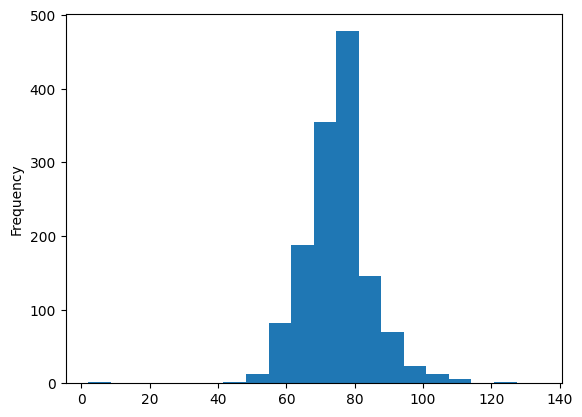

In [ ]:
data[feature].plot(kind='hist', bins=20)
plt.show()

In [ ]:
aux = data[feature].copy()

In [ ]:
aux[aux<40]

279     8.0
1789    2.0
Name: Терапия1_П_ЗначениеПредставление, dtype: float64

In [ ]:
aux.loc[[279, 1789]] = aux[aux<40]*10

In [ ]:
aux.describe()

count    1380.000000
mean       75.120290
std         9.818071
min        20.000000
25%        69.000000
50%        75.000000
75%        80.000000
max       134.000000
Name: Терапия1_П_ЗначениеПредставление, dtype: float64

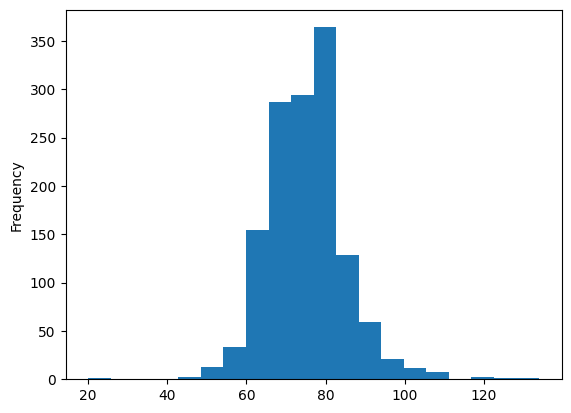

In [ ]:
aux.plot(kind='hist', bins=20)
plt.show()

In [ ]:
X_float = pd.concat([X_float, aux], axis=1)
X_float

АртериальноеДавление_верхнее  АртериальноеДавление_нижнее  \
0                            140.0                        100.0   
1                            150.0                        100.0   
2                            120.0                         80.0   
3                            120.0                         80.0   
4                            110.0                         70.0   
...                            ...                          ...   
1961                         120.0                         70.0   
1962                         120.0                         70.0   
1972                         125.0                         80.0   
1973                         131.0                         71.0   
1981                         130.0                         80.0   

      Терапия1_Вес_ЗначениеПредставление  Терапия1_П_ЗначениеПредставление  
0                                    NaN                              76.0  
1                                   68.0                              65.0  
2                                    NaN                              66.0  
3                                   81.0                              80.0  
4                                  112.0                              70.0  
...                                  ...                               ...  
1961                                95.0                              73.0  
1962                                80.0                              61.0  
1972                                75.0                              90.0  
1973                                73.0                              57.0  
1981                                80.0                              97.0  

[1571 rows x 4 columns]

###### 'Терапия1_Рост_ЗначениеПредставление'

In [ ]:
feature = 'Терапия1_Рост_ЗначениеПредставление'
data[feature].describe()

count    1335.000000
mean      173.517603
std        49.448998
min       142.000000
25%       165.000000
50%       172.000000
75%       178.000000
max      1633.000000
Name: Терапия1_Рост_ЗначениеПредставление, dtype: float64

In [ ]:
aux = data[feature].copy()
aux

0         NaN
1       174.0
2         NaN
3       180.0
4       175.0
        ...  
1961    185.0
1962    178.0
1972    168.0
1973    170.0
1981    182.0
Name: Терапия1_Рост_ЗначениеПредставление, Length: 1571, dtype: float64

In [ ]:
aux[aux>200]

1302    1633.0
1308    1183.0
Name: Терапия1_Рост_ЗначениеПредставление, dtype: float64

In [ ]:
aux[aux>200] = aux[aux>200]/10

In [ ]:
aux.loc[[1302,1308]]

1302    163.3
1308    118.3
Name: Терапия1_Рост_ЗначениеПредставление, dtype: float64

In [ ]:
aux.describe()

count    1335.000000
mean      171.619176
std         9.125962
min       118.300000
25%       165.000000
50%       172.000000
75%       178.000000
max       200.000000
Name: Терапия1_Рост_ЗначениеПредставление, dtype: float64

In [ ]:
X_float = pd.concat([X_float, aux], axis=1)
X_float

АртериальноеДавление_верхнее  АртериальноеДавление_нижнее  \
0                            140.0                        100.0   
1                            150.0                        100.0   
2                            120.0                         80.0   
3                            120.0                         80.0   
4                            110.0                         70.0   
...                            ...                          ...   
1961                         120.0                         70.0   
1962                         120.0                         70.0   
1972                         125.0                         80.0   
1973                         131.0                         71.0   
1981                         130.0                         80.0   

      Терапия1_Вес_ЗначениеПредставление  Терапия1_П_ЗначениеПредставление  \
0                                    NaN                              76.0   
1                                   68.0                              65.0   
2                                    NaN                              66.0   
3                                   81.0                              80.0   
4                                  112.0                              70.0   
...                                  ...                               ...   
1961                                95.0                              73.0   
1962                                80.0                              61.0   
1972                                75.0                              90.0   
1973                                73.0                              57.0   
1981                                80.0                              97.0   

      Терапия1_Рост_ЗначениеПредставление  
0                                     NaN  
1                                   174.0  
2                                     NaN  
3                                   180.0  
4                                   175.0  
...                                   ...  
1961                                185.0  
1962                                178.0  
1972                                168.0  
1973                                170.0  
1981                                182.0  

[1571 rows x 5 columns]

###### 'Терапия1_ИМТ_ЗначениеПредставление'

In [ ]:
feature = 'Терапия1_ИМТ_ЗначениеПредставление'
aux = data[feature].copy()
aux.describe()

count    1313.000000
mean       26.170061
std         4.943937
min         0.190000
25%        22.940000
50%        25.780000
75%        29.050000
max        49.380000
Name: Терапия1_ИМТ_ЗначениеПредставление, dtype: float64

In [ ]:
X_float['Терапия1_ИМТ_ЗначениеПредставление'] = X_float['Терапия1_Вес_ЗначениеПредставление']/(X_float['Терапия1_Рост_ЗначениеПредставление']/100)**2

In [ ]:
X_float['Терапия1_ИМТ_ЗначениеПредставление'].describe()

count    1333.000000
mean       26.235109
std         4.987625
min         2.524934
25%        22.992624
50%        25.777778
75%        29.053288
max        68.596466
Name: Терапия1_ИМТ_ЗначениеПредставление, dtype: float64

###### 'Терапия2_Вес_ЗначениеПредставление'

In [ ]:
feature = 'Терапия2_Вес_ЗначениеПредставление'
aux = data[feature].copy()
aux.describe()

count    153.000000
mean      79.647059
std       15.400560
min       43.000000
25%       70.000000
50%       79.000000
75%       90.000000
max      115.000000
Name: Терапия2_Вес_ЗначениеПредставление, dtype: float64

In [ ]:
data[['Терапия1_Вес_ЗначениеПредставление','Терапия2_Вес_ЗначениеПредставление']][data['Терапия2_Вес_ЗначениеПредставление'].notna()&data['Терапия1_Вес_ЗначениеПредставление'].isna()]

Терапия1_Вес_ЗначениеПредставление  Терапия2_Вес_ЗначениеПредставление
29                                   NaN                                56.0
56                                   NaN                                48.0
147                                  NaN                                63.0
741                                  NaN                                53.0
770                                  NaN                                90.0
1063                                 NaN                                98.0
1376                                 NaN                                60.0
1752                                 NaN                                96.0

In [ ]:
X_float['Терапия1_Вес_ЗначениеПредставление'][data['Терапия2_Вес_ЗначениеПредставление'].notna()&data['Терапия1_Вес_ЗначениеПредставление'].isna()]=data['Терапия2_Вес_ЗначениеПредставление']

In [ ]:
X_float['Терапия1_Вес_ЗначениеПредставление'].describe()

count    1341.000000
mean       77.385309
std        16.263192
min         8.000000
25%        66.000000
50%        76.000000
75%        87.000000
max       153.000000
Name: Терапия1_Вес_ЗначениеПредставление, dtype: float64

###### 'Терапия2_Рост_ЗначениеПредставление'

In [ ]:
feature = 'Терапия2_Рост_ЗначениеПредставление'
aux = data[feature].copy()
aux.describe()

count    153.000000
mean     170.967320
std        8.659812
min      152.000000
25%      165.000000
50%      170.000000
75%      176.000000
max      190.000000
Name: Терапия2_Рост_ЗначениеПредставление, dtype: float64

In [ ]:
data[['Терапия1_Рост_ЗначениеПредставление','Терапия2_Рост_ЗначениеПредставление']][data['Терапия2_Рост_ЗначениеПредставление'].notna()&data['Терапия1_Рост_ЗначениеПредставление'].isna()]

Терапия1_Рост_ЗначениеПредставление  Терапия2_Рост_ЗначениеПредставление
29                                    NaN                                153.0
56                                    NaN                                155.0
147                                   NaN                                168.0
741                                   NaN                                164.0
770                                   NaN                                173.0
1063                                  NaN                                178.0
1376                                  NaN                                166.0
1752                                  NaN                                178.0

In [ ]:
X_float['Терапия1_Рост_ЗначениеПредставление'][data['Терапия2_Рост_ЗначениеПредставление'].notna()&data['Терапия1_Рост_ЗначениеПредставление'].isna()]=data['Терапия2_Рост_ЗначениеПредставление']

In [ ]:
X_float['Терапия1_Рост_ЗначениеПредставление'].describe()

count    1343.000000
mean      171.590916
std         9.131741
min       118.300000
25%       165.000000
50%       172.000000
75%       178.000000
max       200.000000
Name: Терапия1_Рост_ЗначениеПредставление, dtype: float64

In [ ]:
X_float['Терапия1_ИМТ_ЗначениеПредставление'] = X_float['Терапия1_Вес_ЗначениеПредставление']/(X_float['Терапия1_Рост_ЗначениеПредставление']/100)**2

###### Возраст (пока не бью его на группы)

In [ ]:
X_age = (data['ДатаЗавершенияМедосмотра']-data['КлиентДатаРождения']).apply(lambda x: np.round(x.total_seconds()/60/60/24/365.25,2))
#X_age.apply(lambda x: x.total_seconds()/60/60/24/365.25)
X_age

0       45.25
1       34.21
2       36.44
3       33.81
4       37.85
        ...  
1961    28.92
1962    33.39
1972    35.82
1973    29.82
1981    51.22
Length: 1571, dtype: float64

In [ ]:
X_float['Возраст'] = X_age
X_float

АртериальноеДавление_верхнее  АртериальноеДавление_нижнее  \
0                            140.0                        100.0   
1                            150.0                        100.0   
2                            120.0                         80.0   
3                            120.0                         80.0   
4                            110.0                         70.0   
...                            ...                          ...   
1961                         120.0                         70.0   
1962                         120.0                         70.0   
1972                         125.0                         80.0   
1973                         131.0                         71.0   
1981                         130.0                         80.0   

      Терапия1_Вес_ЗначениеПредставление  Терапия1_П_ЗначениеПредставление  \
0                                    NaN                              76.0   
1                                   68.0                              65.0   
2                                    NaN                              66.0   
3                                   81.0                              80.0   
4                                  112.0                              70.0   
...                                  ...                               ...   
1961                                95.0                              73.0   
1962                                80.0                              61.0   
1972                                75.0                              90.0   
1973                                73.0                              57.0   
1981                                80.0                              97.0   

      Терапия1_Рост_ЗначениеПредставление  Терапия1_ИМТ_ЗначениеПредставление  \
0                                     NaN                                 NaN   
1                                   174.0                           22.460034   
2                                     NaN                                 NaN   
3                                   180.0                           25.000000   
4                                   175.0                           36.571429   
...                                   ...                                 ...   
1961                                185.0                           27.757487   
1962                                178.0                           25.249337   
1972                                168.0                           26.573129   
1973                                170.0                           25.259516   
1981                                182.0                           24.151673   

      Возраст  
0       45.25  
1       34.21  
2       36.44  
3       33.81  
4       37.85  
...       ...  
1961    28.92  
1962    33.39  
1972    35.82  
1973    29.82  
1981    51.22  

[1571 rows x 7 columns]

### binary target

In [ ]:
X_adv_factors = X_adverse_factors.loc[data.index]

In [ ]:
X = pd.concat([X_MKB_onehot, X_no_MKB, X_float, X_adv_factors], axis=1)
X.shape

(1571, 544)

In [ ]:
target_binary = target['maybe'] + target['no']
target_binary

0       0
1       0
2       1
3       0
4       1
       ..
1961    0
1962    0
1972    0
1973    0
1981    0
Length: 1571, dtype: int64

In [ ]:
target_binary.value_counts()

0    1434
1     137
dtype: int64

In [ ]:
model = xgb.XGBClassifier()
cv = RepeatedStratifiedKFold(n_repeats=3, random_state=42)
res = cross_validate(estimator = model, X=X.values, y=target_binary.values, cv=cv, scoring = ('accuracy', 'roc_auc', 'f1'))
res = pd.DataFrame({'accuracy': res['test_accuracy'], 'roc_auc': res['test_roc_auc'], 'f1': res['test_f1']})
print(res.mean())
res

accuracy    0.932946
roc_auc     0.917679
f1          0.565354
dtype: float64


accuracy   roc_auc        f1
0   0.939683  0.927700  0.654545
1   0.923567  0.911343  0.520000
2   0.929936  0.927539  0.541667
3   0.945860  0.931733  0.585366
4   0.945860  0.890984  0.638298
5   0.942857  0.958064  0.625000
6   0.920382  0.890179  0.561404
7   0.939490  0.907601  0.612245
8   0.926752  0.929797  0.530612
9   0.923567  0.879496  0.500000
10  0.939683  0.949726  0.627451
11  0.929936  0.909537  0.476190
12  0.929936  0.906310  0.576923
13  0.926752  0.911989  0.530612
14  0.929936  0.933192  0.500000

In [ ]:
model = lgbm.LGBMClassifier(class_weight='balanced')
cv = RepeatedStratifiedKFold(n_repeats=3, random_state=42)
res = cross_validate(estimator = model, X=X.values, y=target_binary.values, cv=cv, scoring = ('accuracy', 'roc_auc', 'f1'))
res = pd.DataFrame({'accuracy': res['test_accuracy'], 'roc_auc': res['test_roc_auc'], 'f1': res['test_f1']})
print(res.mean())
res

accuracy    0.929342
roc_auc     0.926505
f1          0.600876
dtype: float64


accuracy   roc_auc        f1
0   0.926984  0.945495  0.622951
1   0.926752  0.908246  0.610169
2   0.929936  0.932572  0.592593
3   0.939490  0.924894  0.612245
4   0.926752  0.923951  0.596491
5   0.936508  0.968766  0.655172
6   0.904459  0.889534  0.516129
7   0.936306  0.909408  0.629630
8   0.923567  0.927604  0.571429
9   0.936306  0.909965  0.615385
10  0.936508  0.953708  0.677419
11  0.923567  0.921409  0.520000
12  0.939490  0.914570  0.677966
13  0.923567  0.921022  0.555556
14  0.929936  0.946429  0.560000

In [ ]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

#### LGBM

##### accuracy

In [ ]:
base_model = lgbm.LGBMClassifier()

param_gridsearch_0 = {
    'max_depth': [5,7,9],
    'scale_pos_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = 'accuracy')
model.fit(X.values, target_binary.values)

print(model.best_score_)
print(model.best_params_)

0.9348142756040846
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 50, 'scale_pos_weight': 5, 'subsample': 0.7}


In [ ]:
base_model = lgbm.LGBMClassifier()

param_gridsearch_0 = {
    'max_depth': [8,9,10],
    'scale_pos_weight': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.75],
    'colsample_bytree': [0.6, 0.7, 0.75],
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.025, 0.05, 0.075]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = 'accuracy')
model.fit(X.values, target_binary.values)

print(model.best_score_)
print(model.best_params_)

0.9369806895157214
{'colsample_bytree': 0.75, 'learning_rate': 0.075, 'max_depth': 9, 'n_estimators': 25, 'scale_pos_weight': 3, 'subsample': 0.6}


In [ ]:
base_model = lgbm.LGBMClassifier(colsample_bytree=0.75, max_depth=9)

param_gridsearch_0 = {
    'scale_pos_weight': [2, 3, 4],
    'subsample': [0.55, 0.6, 0.65],
    'n_estimators': [20, 25, 30],
    'learning_rate': [0.07, 0.075, 0.08]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = 'accuracy')
model.fit(X.values, target_binary.values)

print(model.best_score_)
print(model.best_params_)

0.9369806895157214
{'learning_rate': 0.075, 'n_estimators': 25, 'scale_pos_weight': 3, 'subsample': 0.55}


##### f1 score

In [ ]:
base_model = lgbm.LGBMClassifier()

param_gridsearch_0 = {
    'max_depth': [5,7,9],
    'scale_pos_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = ['accuracy', 'f1'], refit = 'f1')
model.fit(X.values, target_binary.values)

best_f1 = model.cv_results_['mean_test_f1'].max()
best_f1_split_number = np.argmax(model.cv_results_['mean_test_f1'])
best_f1_accuracy = model.cv_results_['mean_test_accuracy'][best_f1_split_number]

print(best_f1)
print(best_f1_accuracy)
print(model.best_params_)

0.6513173489012816
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 50, 'scale_pos_weight': 5, 'subsample': 0.7}


In [ ]:
base_model = lgbm.LGBMClassifier()

param_gridsearch_0 = {
    'max_depth': [8,9,10],
    'scale_pos_weight': [4, 5, 6],
    'subsample': [0.65, 0.7, 0.75],
    'colsample_bytree': [0.65, 0.7, 0.75],
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.025, 0.05, 0.075]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = ['accuracy', 'f1'], refit = 'f1')
model.fit(X.values, target_binary.values)

best_f1 = model.cv_results_['mean_test_f1'].max()
best_f1_split_number = np.argmax(model.cv_results_['mean_test_f1'])
best_f1_accuracy = model.cv_results_['mean_test_accuracy'][best_f1_split_number]

print(best_f1)
print(best_f1_accuracy)
print(model.best_params_)

0.6630672676269795
0.9365985239106257
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'max_depth': 8, 'n_estimators': 75, 'scale_pos_weight': 5, 'subsample': 0.65}


In [ ]:
base_model = lgbm.LGBMClassifier(max_depth=8, scale_pos_weight=5, n_estimators=75)

param_gridsearch_0 = {
    'subsample': [0.55, 0.6, 0.65],
    'colsample_bytree': [0.55, 0.6, 0.65],
    'learning_rate': [0.015, 0.02, 0.025]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = ['accuracy', 'f1'], refit = 'f1')
model.fit(X.values, target_binary.values)

best_f1 = model.cv_results_['mean_test_f1'].max()
best_f1_split_number = np.argmax(model.cv_results_['mean_test_f1'])
best_f1_accuracy = model.cv_results_['mean_test_accuracy'][best_f1_split_number]

print(best_f1)
print(best_f1_accuracy)
print(model.best_params_)

0.6630672676269795
0.9365985239106257
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'subsample': 0.55}


#### XGBoost

##### accuracy

In [ ]:
base_model = xgb.XGBClassifier()

param_gridsearch_0 = {
    'max_depth': [5,7,9],
    'scale_pos_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = 'accuracy')
model.fit(X.values, target_binary.values)

print(model.best_score_)
print(model.best_params_)

In [ ]:
base_model = lgbm.LGBMClassifier()

param_gridsearch_0 = {
    'max_depth': [5,7,9],
    'scale_pos_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.65, 0.7, 0.75],
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.025, 0.05, 0.075]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = 'accuracy')
model.fit(X.values, target_binary.values)

print(model.best_score_)
print(model.best_params_)

In [ ]:
len(model.cv_results_['split0_test_accuracy'])

729

In [ ]:
model.cv_results_['params'][0]

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 50,
 'scale_pos_weight': 1,
 'subsample': 0.7}

In [ ]:
print(np.argmax(model.cv_results_['mean_test_accuracy']), max(model.cv_results_['mean_test_accuracy']))

57 0.9336706096451318


In [ ]:
print(np.argmax(model.cv_results_['mean_test_f1']), max(model.cv_results_['mean_test_f1']))
model.cv_results_['mean_test_accuracy'][np.argmax(model.cv_results_['mean_test_f1'])]

57 0.6513173489012816


0.9336706096451318

##### расширенная обработка категориальных признаков

In [ ]:
X_float

АртериальноеДавление_верхнее  АртериальноеДавление_нижнее  \
0                            140.0                        100.0   
1                            150.0                        100.0   
2                            120.0                         80.0   
3                            120.0                         80.0   
4                            110.0                         70.0   
...                            ...                          ...   
1961                         120.0                         70.0   
1962                         120.0                         70.0   
1972                         125.0                         80.0   
1973                         131.0                         71.0   
1981                         130.0                         80.0   

      Терапия1_Вес_ЗначениеПредставление  Терапия1_П_ЗначениеПредставление  \
0                                    NaN                              76.0   
1                                   68.0                              65.0   
2                                    NaN                              66.0   
3                                   81.0                              80.0   
4                                  112.0                              70.0   
...                                  ...                               ...   
1961                                95.0                              73.0   
1962                                80.0                              61.0   
1972                                75.0                              90.0   
1973                                73.0                              57.0   
1981                                80.0                              97.0   

      Терапия1_Рост_ЗначениеПредставление  Терапия1_ИМТ_ЗначениеПредставление  \
0                                     NaN                                 NaN   
1                                   174.0                           22.460034   
2                                     NaN                                 NaN   
3                                   180.0                           25.000000   
4                                   175.0                           36.571429   
...                                   ...                                 ...   
1961                                185.0                           27.757487   
1962                                178.0                           25.249337   
1972                                168.0                           26.573129   
1973                                170.0                           25.259516   
1981                                182.0                           24.151673   

      Возраст  
0       45.25  
1       34.21  
2       36.44  
3       33.81  
4       37.85  
...       ...  
1961    28.92  
1962    33.39  
1972    35.82  
1973    29.82  
1981    51.22  

[1571 rows x 7 columns]

In [ ]:
X_float_dummies = pd.DataFrame()
qnum=5
for elem in X_float.columns:
  qbins = pd.qcut(X_float[elem],qnum, duplicates='drop')
  qbins = pd.Series(qbins)
  dummies = pd.get_dummies(qbins, prefix=elem)
  X_float_dummies = pd.concat([X_float_dummies, dummies], axis=1)
X_float_dummies

АртериальноеДавление_верхнее_(89.999, 120.0]  \
0                                                0   
1                                                0   
2                                                1   
3                                                1   
4                                                1   
...                                            ...   
1961                                             1   
1962                                             1   
1972                                             0   
1973                                             0   
1981                                             0   

      АртериальноеДавление_верхнее_(120.0, 125.0]  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   
...                                           ...   
1961                                            0   
1962                                            0   
1972                                            1   
1973                                            0   
1981                                            0   

      АртериальноеДавление_верхнее_(125.0, 135.0]  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   
...                                           ...   
1961                                            0   
1962                                            0   
1972                                            0   
1973                                            1   
1981                                            1   

      АртериальноеДавление_верхнее_(135.0, 198.0]  \
0                                               1   
1                                               1   
2                                               0   
3                                               0   
4                                               0   
...                                           ...   
1961                                            0   
1962                                            0   
1972                                            0   
1973                                            0   
1981                                            0   

      АртериальноеДавление_нижнее_(19.999, 70.0]  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              1   
...                                          ...   
1961                                           1   
1962                                           1   
1972                                           0   
1973                                           0   
1981                                           0   

      АртериальноеДавление_нижнее_(70.0, 80.0]  \
0                                            0   
1                                            0   
2                                            1   
3                                            1   
4                                            0   
...                                        ...   
1961                                         0   
1962                                         0   
1972                                         1   
1973                                         1   
1981                                         1   

      АртериальноеДавление_нижнее_(80.0, 85.0]  \
0                                            0   
1                                            0   
2                                            0   
3                   

In [ ]:
X_broad = pd.concat([X_MKB_onehot, X_no_MKB, X_float, X_float_dummies], axis=1)
X_broad.shape

(1571, 485)

In [ ]:
model_broad = lgbm.LGBMClassifier(class_weight='balanced')
cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)

res = cross_val_score(model_broad, X_broad.values, target_binary.values, cv=cv)

print(res.mean())
res

0.9275595996360328


array([0.93333333, 0.92675159, 0.91082803, 0.94267516, 0.93949045,
       0.94285714, 0.92038217, 0.93949045, 0.92038217, 0.92675159,
       0.94285714, 0.92993631, 0.93630573, 0.92675159, 0.92675159,
       0.91746032, 0.91401274, 0.92038217, 0.92675159, 0.93630573,
       0.92063492, 0.93312102, 0.89490446, 0.91719745, 0.94267516])

In [ ]:
base_model = lgbm.LGBMClassifier()

param_gridsearch_0 = {
    'max_depth': [5,7,9],
    'scale_pos_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model_broad = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = 'accuracy')
model_broad.fit(X_broad.values, target_binary.values)

print(model_broad.best_score_)
print(model_broad.best_params_)

0.9369806895157214
{'learning_rate': 0.075, 'n_estimators': 25, 'scale_pos_weight': 3, 'subsample': 0.55}


In [ ]:
print(model_broad.best_score_)
print(model_broad.best_params_)

0.9316360327570519
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 50, 'scale_pos_weight': 5, 'subsample': 0.7}


In [ ]:
base_model = lgbm.LGBMClassifier()

param_gridsearch_0 = {
    'max_depth': [8,9,10],
    'scale_pos_weight': [3, 5, 7],
    'subsample': [0.65, 0.7, 0.75],
    'colsample_bytree': [0.65, 0.7, 0.75],
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.025, 0.05, 0.075]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model_broad = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = 'accuracy')
model_broad.fit(X_broad.values, target_binary.values)

print(model_broad.best_score_)
print(model_broad.best_params_)

0.9367251036295623
{'colsample_bytree': 0.7, 'learning_rate': 0.025, 'max_depth': 9, 'n_estimators': 50, 'scale_pos_weight': 5, 'subsample': 0.65}


In [ ]:
base_model = lgbm.LGBMClassifier(colsample_bytree=0.7, max_depth=9, n_estimators=50, scale_pos_weight=5)

param_gridsearch_0 = {

    'subsample': [0.55, 0.6, 0.65],
    'learning_rate': [0.02, 0.025, 0.03]

}

cv = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
model_broad = GridSearchCV(estimator = base_model, param_grid = param_gridsearch_0, cv = cv, n_jobs = 3, scoring = 'accuracy')
model_broad.fit(X_broad.values, target_binary.values)

print(model_broad.best_score_)
print(model_broad.best_params_)

0.9367251036295623
{'learning_rate': 0.025, 'subsample': 0.55}


###### Лучшая точность ML: 0.937

#### Neural network

In [ ]:
X_MKB_onehot.isna().sum().sum()

0

In [ ]:
X_no_MKB.isna().sum().sum()

0

In [ ]:
X_float.isna().sum().sum()

1243

In [ ]:
rep_dict = {elem: X_float[elem].mean() for elem in X_float.columns}
rep_dict

{'АртериальноеДавление_верхнее': 126.99424046076314,
 'АртериальноеДавление_нижнее': 79.54974802015839,
 'Терапия1_Вес_ЗначениеПредставление': 77.38530947054437,
 'Терапия1_П_ЗначениеПредставление': 75.12028985507246,
 'Терапия1_Рост_ЗначениеПредставление': 171.5909158600149,
 'Терапия1_ИМТ_ЗначениеПредставление': 26.226997222568986,
 'Возраст': 41.43281985996181}

In [ ]:
X_float = X_float.fillna(value=rep_dict)

###### функция для создания модели

In [313]:
# define baseline model
def get_model(input_dim, layers, lr, metrics = ['accuracy'], output_bias = None, loss = 'binary_crossentropy'):
  # layers (only Dense layers so far) = {'layer_number': [n_neurons, activation, dropout_rate, batchnormalization]}
	# create model

  model = Sequential()
  for n in layers.keys():
    if n == 0:
      model.add(Dense(layers[n][0], input_dim=input_dim, activation=layers[n][1]))
      if layers[n][2] > 0:
        model.add(Dropout(layers[n][2]))
      if layers[n][3]:
        model.add(BatchNormalization())
    else:
      model.add(Dense(layers[n][0], activation=layers[n][1]))
      if layers[n][2] > 0:
        model.add(Dropout(layers[n][2]))
      if layers[n][3]:
        model.add(BatchNormalization())      
  if output_bias is not None:
    bias_initializer = Constant(output_bias)
    model.add(Dense(1, activation='sigmoid', bias_initializer=bias_initializer))
  else:
    model.add(Dense(1, activation='sigmoid'))
  #m_f1 = F1Score(num_classes=2)
	# Compile model
  #model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = lr), metrics=['accuracy', m_f1])

  model.compile(loss=loss, optimizer=Adam(learning_rate = lr), metrics=metrics)
  return model

In [ ]:
layers = {0: [500, 'relu', 0.25, True],
          1: [100, 'relu', 0.25, True],
          2: [10, 'relu', 0, False]}
input_dim = 500
lr = 0.0001

test_model = get_model(input_dim, layers, lr, metrics = 'accuracy', output_bias = 1)
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               250500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 batch_normalization (BatchN  (None, 500)              2000      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                        

In [ ]:
type(target_binary)

pandas.core.series.Series

In [ ]:
target_binary

0       0
1       0
2       1
3       0
4       1
       ..
1961    0
1962    0
1972    0
1973    0
1981    0
Length: 1571, dtype: int64

###### функция для оценки качества модели

In [314]:
def evaluate_nn_new(cv, layers, lr, batch, epochs, class_weight = None, plots=True, metric_to_monitor = 'val_accuracy', output_bias=None, loss = 'binary_crossentropy'):
  history_train_loss = pd.DataFrame()
  history_test_loss = pd.DataFrame()
  history_train_acc = pd.DataFrame()
  history_test_acc = pd.DataFrame()
  history_train_precision = pd.DataFrame()
  history_test_precision = pd.DataFrame()
  history_train_recall = pd.DataFrame()
  history_test_recall = pd.DataFrame()
  history_train_f1 = pd.DataFrame()
  history_test_f1 = pd.DataFrame()  
  mean_confusion_matrix = np.zeros((2,2))


  best_acc = []
  best_precision = []
  best_recall = []
  best_f1 = []
  for i, (train_ind, test_ind) in enumerate(cv.split(np.zeros(len(target_binary)),target_binary)):
    y_train = target_binary.iloc[train_ind]
    y_test = target_binary.iloc[test_ind]
    
    X_MKB_onehot_train = X_MKB_onehot.iloc[train_ind] 
    X_MKB_onehot_test = X_MKB_onehot.iloc[test_ind] 
    X_no_MKB_train = X_no_MKB.iloc[train_ind] 
    X_no_MKB_test = X_no_MKB.iloc[test_ind]
    X_adv_factors_train = X_adv_factors.iloc[train_ind] 
    X_adv_factors_test = X_adv_factors.iloc[test_ind] 
    
    X_float_train = X_float.iloc[train_ind]
    X_float_test = X_float.iloc[test_ind]
    scaler = StandardScaler()
    X_float_train_norm = scaler.fit_transform(X_float_train)
    X_float_test_norm = scaler.transform(X_float_test)
    X_nn_train = np.concatenate((X_MKB_onehot_train, X_no_MKB_train, X_adv_factors_train, X_float_train_norm), axis=1)
    X_nn_test = np.concatenate((X_MKB_onehot_test, X_no_MKB_test, X_adv_factors_test, X_float_test_norm), axis=1)

    model = get_model(input_dim = X_nn_train.shape[1], layers = layers, lr=lr, 
                      metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')], output_bias = output_bias, loss=loss)
    
    callback_path = '/content/aux_weights.hdf5'
    model_checkpoint_callback = ModelCheckpoint(
      filepath=callback_path,
      save_weights_only=True,
      monitor=metric_to_monitor,
      mode='max',
      save_best_only=True)  
    fit_results = model.fit(X_nn_train, y_train, class_weight = class_weight, batch_size = batch, epochs = epochs, 
                            validation_data = (X_nn_test, y_test), verbose=0, callbacks=[model_checkpoint_callback])
    model.load_weights(callback_path)

    history_train_loss = pd.concat([history_train_loss, pd.DataFrame(fit_results.history['loss'], columns = [i])],axis=1)
    history_test_loss = pd.concat([history_test_loss, pd.DataFrame(fit_results.history['val_loss'], columns = [i])],axis=1)
    train_acc = pd.DataFrame(fit_results.history['accuracy'], columns = [i])
    test_acc = pd.DataFrame(fit_results.history['val_accuracy'], columns = [i])    
    history_train_acc = pd.concat([history_train_acc, train_acc],axis=1)
    history_test_acc = pd.concat([history_test_acc, test_acc],axis=1)
    best_test_acc = np.round(test_acc.max().values[0],4)

    train_precision = pd.DataFrame(fit_results.history['precision'], columns = [i])
    test_precision = pd.DataFrame(fit_results.history['val_precision'], columns = [i])
    history_train_precision = pd.concat([history_train_precision, train_precision],axis=1)
    history_test_precision = pd.concat([history_test_precision, test_precision],axis=1)
    best_test_precision = np.round(test_precision.max().values[0],4)

    train_recall = pd.DataFrame(fit_results.history['recall'], columns = [i])
    test_recall = pd.DataFrame(fit_results.history['val_recall'], columns = [i])
    history_train_recall = pd.concat([history_train_recall, train_recall],axis=1)
    history_test_recall = pd.concat([history_test_recall, test_recall],axis=1)    
    best_test_recall = np.round(test_recall.max().values[0],4)
    
    train_f1 = 2*train_precision*train_recall/(train_precision+train_recall)
    test_f1 = 2*test_precision*test_recall/(test_precision+test_recall)
    history_train_f1 = pd.concat([history_train_f1, train_f1],axis=1)
    history_test_f1 = pd.concat([history_test_f1, test_f1],axis=1)
    best_test_f1 = np.round(test_f1.max().values[0],4)


    y_pred_probs = model.predict(X_nn_test)
    y_pred = np.where(y_pred_probs >= 0.5, 1, 0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print('best_test_acc', best_test_acc)
    print('best_test_precision', best_test_precision)
    print('best_test_recall', best_test_recall)
    print('best_test_f1', best_test_f1)

    print(pd.DataFrame(conf_matrix, columns = ['pred_0', 'pred_1'], index = ['actual_0', 'actual_1']))
    print('calc_accuracy:', np.round((conf_matrix[0,0]+conf_matrix[1,1])/(conf_matrix[0,0]+conf_matrix[0,1]+conf_matrix[1,0]+conf_matrix[1,1]),4))
    print('calc_precision:', np.round((conf_matrix[1,1])/(conf_matrix[0,1]+conf_matrix[1,1]),4))
    print('calc_recall:', np.round((conf_matrix[1,1])/(conf_matrix[1,0]+conf_matrix[1,1]),4))
    print('\n')
    mean_confusion_matrix += conf_matrix

    os.remove(callback_path)
    del model
  mean_confusion_matrix= pd.DataFrame(mean_confusion_matrix, columns = ['pred_0', 'pred_1'], index = ['actual_0', 'actual_1'])

  history_train_loss['mean'] = history_train_loss.mean(axis=1)
  history_test_loss['mean'] = history_test_loss.mean(axis=1)

  history_train_acc['mean'] = history_train_acc.mean(axis=1)
  history_test_acc['mean'] = history_test_acc.mean(axis=1)
  history_train_precision['mean'] = history_train_precision.mean(axis=1)
  history_test_precision['mean'] = history_test_precision.mean(axis=1)
  history_train_recall['mean'] = history_train_recall.mean(axis=1)
  history_test_recall['mean'] = history_test_recall.mean(axis=1)
  history_train_f1['mean'] = history_train_f1.mean(axis=1)
  history_test_f1['mean'] = history_test_f1.mean(axis=1)

  if plots:
    fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(16,4))

    ax1.plot(history_train_loss['mean'], label = 'ошибка на обучающей выборке')
    ax1.plot(history_test_loss['mean'], label = 'ошибка на проверочной выборке')
    #ax1.ylabel('ошибка')
    ax1.legend()

    ax2.plot(history_train_acc['mean'], label = 'точность на обучающей выборке')
    ax2.plot(history_test_acc['mean'], label = 'точность на проверочной выборке')
    #ax2.ylabel('точность')
    ax2.legend()

    ax3.plot(history_train_f1['mean'], label = 'f1 на обучающей выборке')
    ax3.plot(history_test_f1['mean'], label = 'f1 на проверочной выборке')
    ax3.legend()

    plt.show()

  mean_best_test_accuracy = np.round(np.mean(history_test_acc.iloc[:,:i+1].max()),4)
  mean_best_test_precision = np.round(np.mean(history_test_precision.iloc[:,:i+1].max()),4)
  mean_best_test_recall = np.round(np.mean(history_test_recall.iloc[:,:i+1].max()),4)
  mean_best_test_f1 = np.round(np.mean(history_test_f1.iloc[:,i+1].max()),4)

#  print('лучшая средняя точность на проверочной выборке: ', np.round(max(history_test_acc['mean']),4))
#  print('лучшая средняя precision на проверочной выборке: ', np.round(max(history_test_precision['mean']),4))
#  print('лучший средний recall на проверочной выборке: ', np.round(max(history_test_recall['mean']),4))
#  print('лучший средний f1 на проверочной выборке: ', np.round(max(history_test_f1['mean']),4))
#  print('\n')

  print('лучшая средняя точность на проверочной выборке: ', mean_best_test_accuracy)
  print('лучшая средняя precision на проверочной выборке: ', mean_best_test_precision)
  print('лучший средний recall на проверочной выборке: ', mean_best_test_recall)
  print('лучший средний f1 на проверочной выборке: ', mean_best_test_f1)

  print(mean_confusion_matrix)
  print('calc_accuracy:', (mean_confusion_matrix.iloc[0,0]+mean_confusion_matrix.iloc[1,1])/(mean_confusion_matrix.iloc[0,0]+mean_confusion_matrix.iloc[0,1]+mean_confusion_matrix.iloc[1,0]+mean_confusion_matrix.iloc[1,1]))
  print('calc_precision:', (mean_confusion_matrix.iloc[1,1])/(mean_confusion_matrix.iloc[0,1]+mean_confusion_matrix.iloc[1,1]))
  print('calc_recall:', (mean_confusion_matrix.iloc[1,1])/(mean_confusion_matrix.iloc[1,0]+mean_confusion_matrix.iloc[1,1]))
  
  
  return {'history_test_acc': history_test_acc, 
          'history_test_precision': history_test_precision, 
          'history_test_recall': history_test_recall, 
          'history_test_f1': history_test_f1, 
          'confusion_matrix': mean_confusion_matrix}

###### сохранение результатов

In [ ]:
os.listdir()

['.config', 'sample_data']

In [ ]:
results = dict()
# просто сохраняю модели и результаты по порядку


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9365
best_test_precision 0.7222
best_test_recall 0.7857
best_test_f1 0.6769
          pred_0  pred_1
actual_0     282       5
actual_1      15      13
calc_accuracy: 0.9365
calc_precision: 0.7222
calc_recall: 0.4643


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9427
best_test_precision 1.0
best_test_recall 0.6296
best_test_f1 0.6296
          pred_0  pred_1
actual_0     283       4
actual_1      14      13
calc_accuracy: 0.9427
calc_precision: 0.7647
calc_recall: 0.4815


10/10 [==============================] - 0s 5ms/step
best_test_acc 0.9459
best_test_precision 0.75
best_test_recall 0.7037
best_test_f1 0.6667
          pred_0  pred_1
actual_0     282       5
actual_1      12      15
calc_accuracy: 0.9459
calc_precision: 0.75
calc_recall: 0.5556


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9395
best_test_precision 1.0
best_test_recall 0.5556
best_test_f1 0.6
       

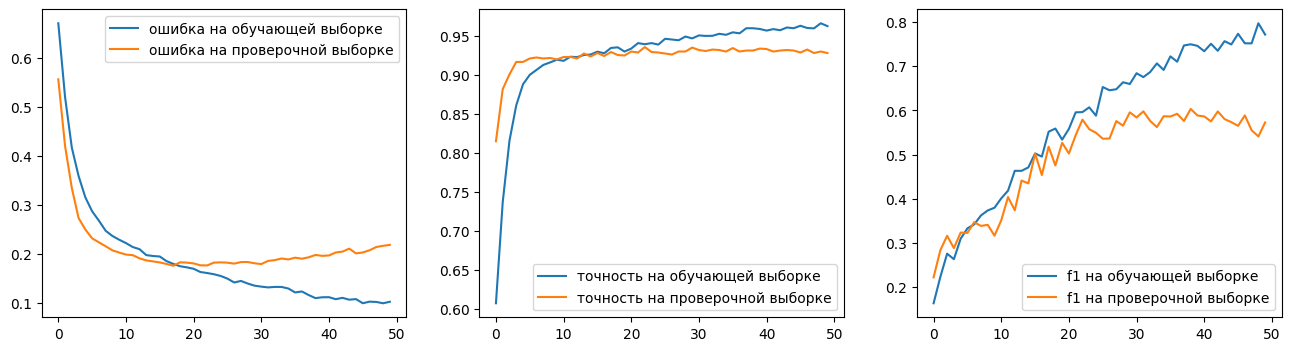

лучшая средняя точность на проверочной выборке:  0.9421
лучшая средняя precision на проверочной выборке:  0.8944
лучший средний recall на проверочной выборке:  0.6635
лучший средний f1 на проверочной выборке:  0.603
          pred_0  pred_1
actual_0  1411.0    23.0
actual_1    68.0    69.0
calc_accuracy: 0.9420751113940166
calc_precision: 0.75
calc_recall: 0.5036496350364964


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, False]}
lr = 0.0001
batch = 10
epochs = 50
metric_to_monitor = 'val_accuracy'
output_bias = None
res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9365
best_test_precision 1.0
best_test_recall 0.8214
best_test_f1 0.6875
          pred_0  pred_1
actual_0     273      14
actual_1       6      22
calc_accuracy: 0.9365
calc_precision: 0.6111
calc_recall: 0.7857


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9522
best_test_precision 0.9231
best_test_recall 0.7778
best_test_f1 0.6667
          pred_0  pred_1
actual_0     284       3
actual_1      12      15
calc_accuracy: 0.9522
calc_precision: 0.8333
calc_recall: 0.5556


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9395
best_test_precision 0.75
best_test_recall 0.963
best_test_f1 0.6182
          pred_0  pred_1
actual_0     280       7
actual_1      12      15
calc_accuracy: 0.9395
calc_precision: 0.6818
calc_recall: 0.5556


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9427
best_test_precision 0.8889
best_test_recall 0.7407
best_test_f1 0.5957


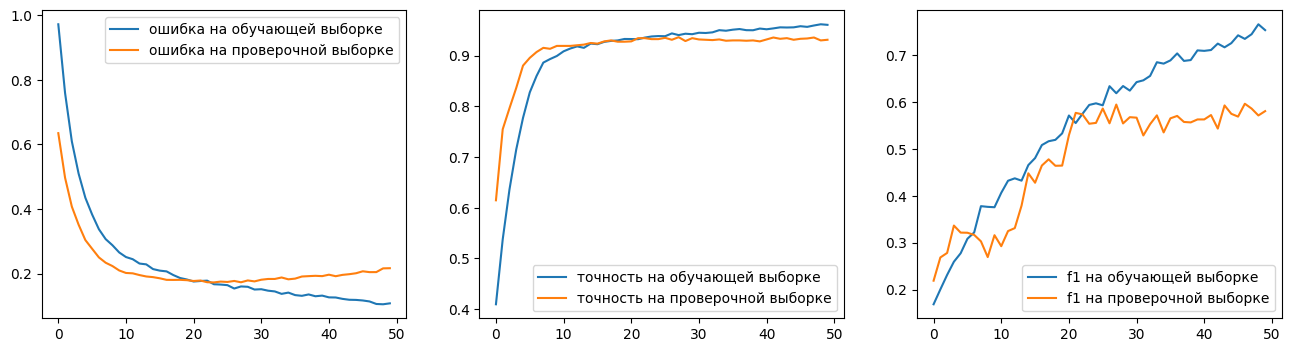

лучшая средняя точность на проверочной выборке:  0.9427
лучшая средняя precision на проверочной выборке:  0.8653
лучший средний recall на проверочной выборке:  0.8534
лучший средний f1 на проверочной выборке:  0.5962
          pred_0  pred_1
actual_0  1400.0    34.0
actual_1    56.0    81.0
calc_accuracy: 0.942711648631445
calc_precision: 0.7043478260869566
calc_recall: 0.5912408759124088


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, False]}
lr = 0.0001
batch = 10
epochs = 50
output_bias = float(target_binary.sum()/len(target_binary))
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9429
best_test_precision 0.8571
best_test_recall 0.75
best_test_f1 0.6885
          pred_0  pred_1
actual_0     278       9
actual_1       9      19
calc_accuracy: 0.9429
calc_precision: 0.6786
calc_recall: 0.6786


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.949
best_test_precision 0.8571
best_test_recall 0.5926
best_test_f1 0.6522
          pred_0  pred_1
actual_0     284       3
actual_1      13      14
calc_accuracy: 0.949
calc_precision: 0.8235
calc_recall: 0.5185


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9395
best_test_precision 1.0
best_test_recall 0.6296
best_test_f1 0.6038
          pred_0  pred_1
actual_0     282       5
actual_1      14      13
calc_accuracy: 0.9395
calc_precision: 0.7222
calc_recall: 0.4815


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9459
best_test_precision 1.0
best_test_recall 0.5185
best_test_f1 0.6222
    

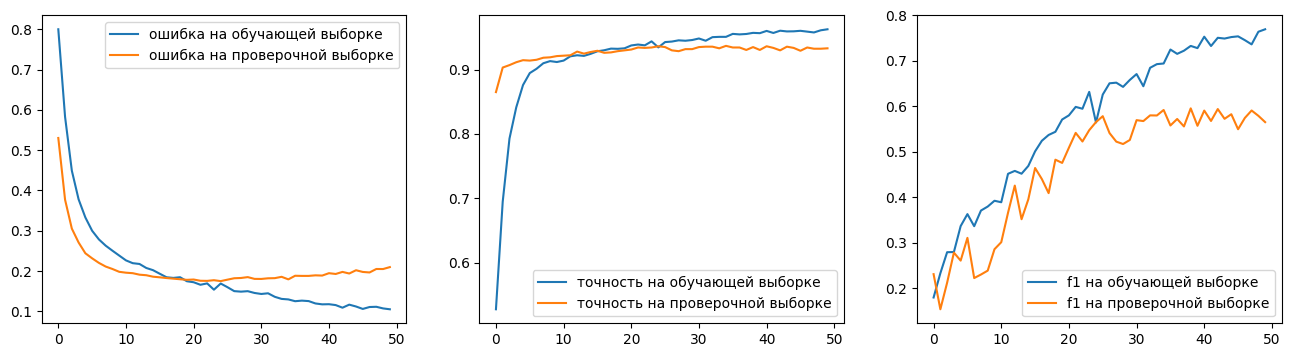

лучшая средняя точность на проверочной выборке:  0.944
лучшая средняя precision на проверочной выборке:  0.8873
лучший средний recall на проверочной выборке:  0.6267
лучший средний f1 на проверочной выборке:  0.5957
          pred_0  pred_1
actual_0  1406.0    28.0
actual_1    60.0    77.0
calc_accuracy: 0.9439847231063018
calc_precision: 0.7333333333333333
calc_recall: 0.5620437956204379


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, False]}
lr = 0.0001
batch = 10
epochs = 50
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9333
best_test_precision 0.625
best_test_recall 1.0
best_test_f1 0.6567
          pred_0  pred_1
actual_0     274      13
actual_1       8      20
calc_accuracy: 0.9333
calc_precision: 0.6061
calc_recall: 0.7143


10/10 [==============================] - 0s 5ms/step
best_test_acc 0.9459
best_test_precision 0.6818
best_test_recall 0.8519
best_test_f1 0.7018
          pred_0  pred_1
actual_0     277      10
actual_1       7      20
calc_accuracy: 0.9459
calc_precision: 0.6667
calc_recall: 0.7407


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9395
best_test_precision 0.6842
best_test_recall 1.0
best_test_f1 0.6122
          pred_0  pred_1
actual_0     280       7
actual_1      12      15
calc_accuracy: 0.9395
calc_precision: 0.6818
calc_recall: 0.5556


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9395
best_test_precision 0.7
best_test_recall 0.9259
best_test_f1 0.6415
    

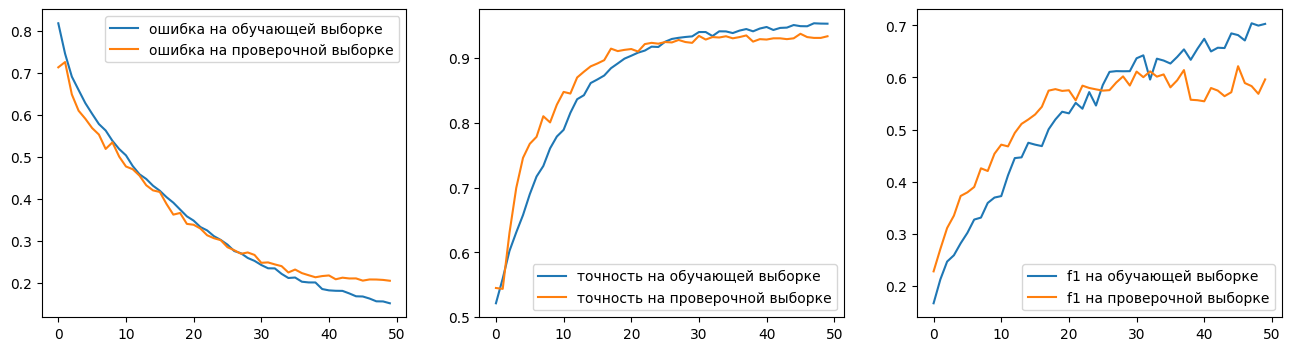

лучшая средняя точность на проверочной выборке:  0.9408
лучшая средняя precision на проверочной выборке:  0.7007
лучший средний recall на проверочной выборке:  0.9056
лучший средний f1 на проверочной выборке:  0.6216
          pred_0  pred_1
actual_0  1390.0    44.0
actual_1    49.0    88.0
calc_accuracy: 0.9408020369191598
calc_precision: 0.6666666666666666
calc_recall: 0.6423357664233577


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, True]}
lr = 0.0001
batch = 10
epochs = 50
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9397
best_test_precision 0.6818
best_test_recall 0.8214
best_test_f1 0.6667
          pred_0  pred_1
actual_0     277      10
actual_1       9      19
calc_accuracy: 0.9397
calc_precision: 0.6552
calc_recall: 0.6786


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9427
best_test_precision 0.8
best_test_recall 0.8519
best_test_f1 0.678
          pred_0  pred_1
actual_0     281       6
actual_1      12      15
calc_accuracy: 0.9427
calc_precision: 0.7143
calc_recall: 0.5556


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.949
best_test_precision 0.7778
best_test_recall 1.0
best_test_f1 0.6667
          pred_0  pred_1
actual_0     282       5
actual_1      11      16
calc_accuracy: 0.949
calc_precision: 0.7619
calc_recall: 0.5926


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9427
best_test_precision 0.7368
best_test_recall 0.963
best_test_f1 0.6122
    

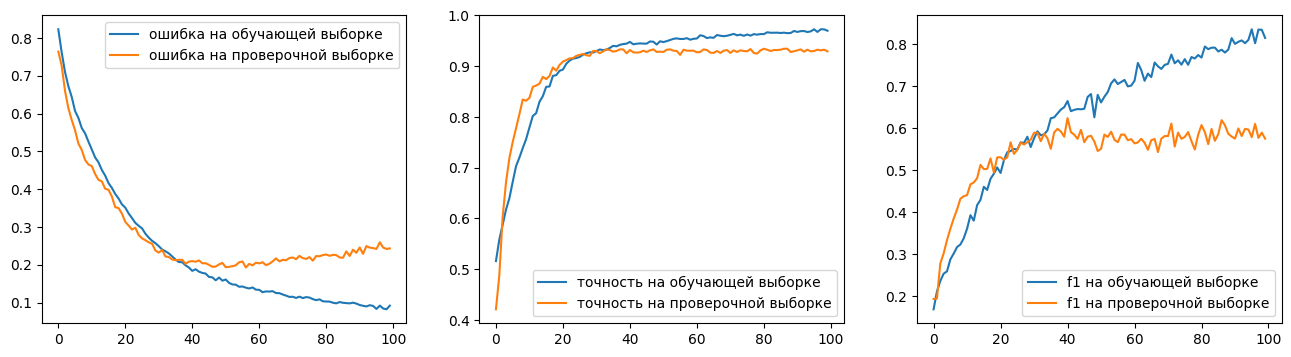

лучшая средняя точность на проверочной выборке:  0.9453
лучшая средняя precision на проверочной выборке:  0.7677
лучший средний recall на проверочной выборке:  0.9201
лучший средний f1 на проверочной выборке:  0.6244
          pred_0  pred_1
actual_0  1405.0    29.0
actual_1    57.0    80.0
calc_accuracy: 0.9452577975811585
calc_precision: 0.7339449541284404
calc_recall: 0.583941605839416


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, True]}
lr = 0.0001
batch = 10
epochs = 100
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.946
best_test_precision 0.6897
best_test_recall 0.8929
best_test_f1 0.7097
          pred_0  pred_1
actual_0     278       9
actual_1       8      20
calc_accuracy: 0.946
calc_precision: 0.6897
calc_recall: 0.7143


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9363
best_test_precision 0.6842
best_test_recall 0.8889
best_test_f1 0.6462
          pred_0  pred_1
actual_0     279       8
actual_1      12      15
calc_accuracy: 0.9363
calc_precision: 0.6522
calc_recall: 0.5556


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.949
best_test_precision 0.7619
best_test_recall 0.963
best_test_f1 0.6667
          pred_0  pred_1
actual_0     282       5
actual_1      11      16
calc_accuracy: 0.949
calc_precision: 0.7619
calc_recall: 0.5926


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9459
best_test_precision 0.8125
best_test_recall 0.7778
best_test_f1 0.6087

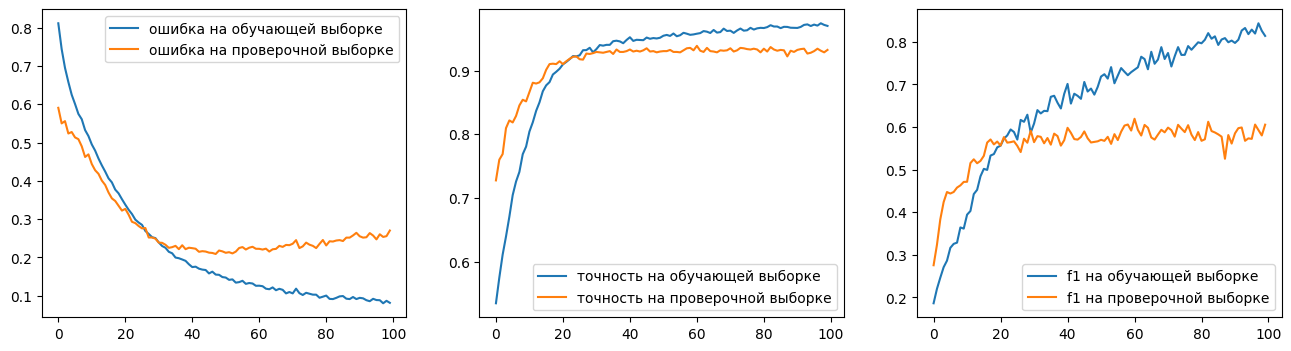

лучшая средняя точность на проверочной выборке:  0.9465
лучшая средняя precision на проверочной выборке:  0.7597
лучший средний recall на проверочной выборке:  0.8616
лучший средний f1 на проверочной выборке:  0.6195
          pred_0  pred_1
actual_0  1406.0    28.0
actual_1    56.0    81.0
calc_accuracy: 0.9465308720560153
calc_precision: 0.7431192660550459
calc_recall: 0.5912408759124088


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, True]}
lr = 0.0001
batch = 10
epochs = 100
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9365
best_test_precision 0.6207
best_test_recall 0.9286
best_test_f1 0.6774
          pred_0  pred_1
actual_0     274      13
actual_1       7      21
calc_accuracy: 0.9365
calc_precision: 0.6176
calc_recall: 0.75


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9459
best_test_precision 0.7143
best_test_recall 0.8889
best_test_f1 0.6792
          pred_0  pred_1
actual_0     279       8
actual_1       9      18
calc_accuracy: 0.9459
calc_precision: 0.6923
calc_recall: 0.6667


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9459
best_test_precision 0.7778
best_test_recall 0.8519
best_test_f1 0.6531
          pred_0  pred_1
actual_0     282       5
actual_1      12      15
calc_accuracy: 0.9459
calc_precision: 0.75
calc_recall: 0.5556


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9459
best_test_precision 0.7778
best_test_recall 0.8889
best_test_f1 0.627

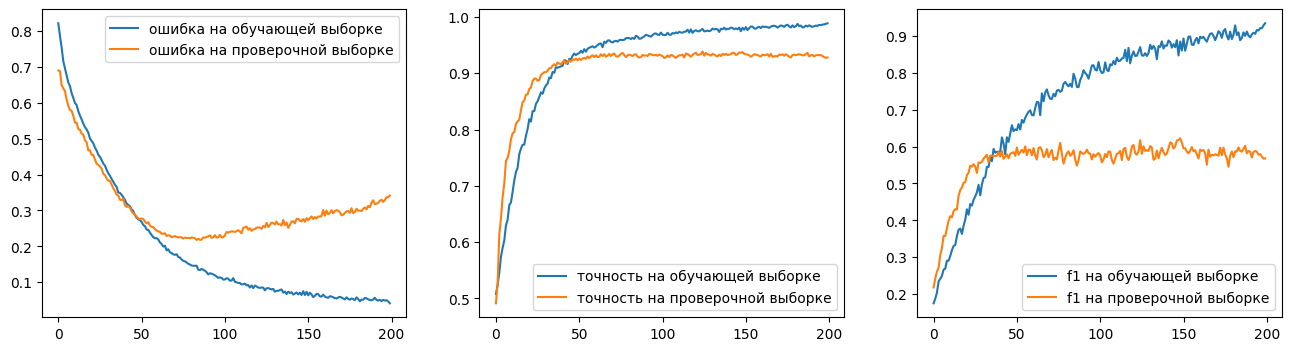

лучшая средняя точность на проверочной выборке:  0.9446
лучшая средняя precision на проверочной выборке:  0.7381
лучший средний recall на проверочной выборке:  0.8831
лучший средний f1 на проверочной выборке:  0.6224
          pred_0  pred_1
actual_0  1400.0    34.0
actual_1    53.0    84.0
calc_accuracy: 0.9446212603437301
calc_precision: 0.711864406779661
calc_recall: 0.6131386861313869


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, True]}
lr = 0.00005
batch = 10
epochs = 200
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 5ms/step
best_test_acc 0.9333
best_test_precision 0.64
best_test_recall 0.8571
best_test_f1 0.6765
          pred_0  pred_1
actual_0     273      14
actual_1       7      21
calc_accuracy: 0.9333
calc_precision: 0.6
calc_recall: 0.75


10/10 [==============================] - 0s 5ms/step
best_test_acc 0.9395
best_test_precision 0.7059
best_test_recall 0.8889
best_test_f1 0.6885
          pred_0  pred_1
actual_0     277      10
actual_1       9      18
calc_accuracy: 0.9395
calc_precision: 0.6429
calc_recall: 0.6667


10/10 [==============================] - 0s 5ms/step
best_test_acc 0.9427
best_test_precision 0.8
best_test_recall 0.9259
best_test_f1 0.6296
          pred_0  pred_1
actual_0     282       5
actual_1      13      14
calc_accuracy: 0.9427
calc_precision: 0.7368
calc_recall: 0.5185


10/10 [==============================] - 0s 5ms/step
best_test_acc 0.949
best_test_precision 0.7895
best_test_recall 0.7778
best_test_f1 0.6522
     

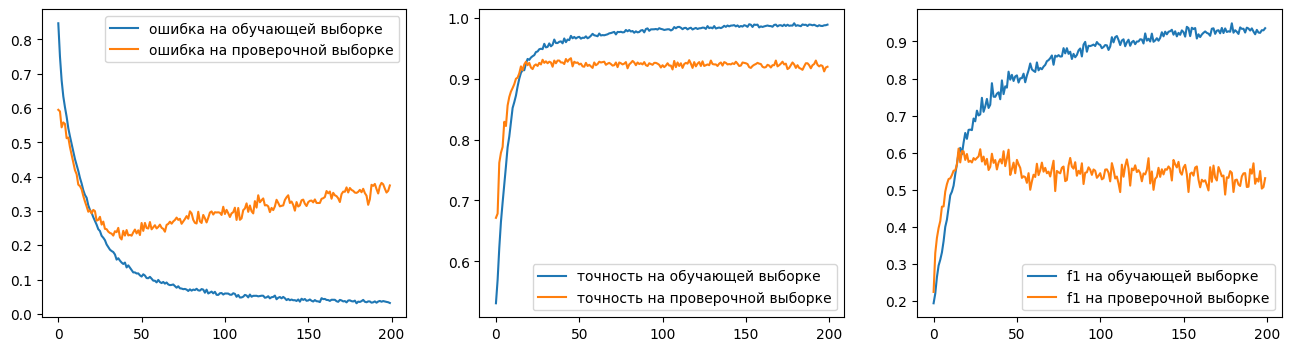

лучшая средняя точность на проверочной выборке:  0.9421
лучшая средняя precision на проверочной выборке:  0.7349
лучший средний recall на проверочной выборке:  0.8899
лучший средний f1 на проверочной выборке:  0.6111
          pred_0  pred_1
actual_0  1395.0    39.0
actual_1    52.0    85.0
calc_accuracy: 0.9420751113940166
calc_precision: 0.6854838709677419
calc_recall: 0.6204379562043796


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [1000, 'relu', 0.25, True],
          1: [500, 'relu', 0.1, True],
          2: [100, 'relu', 0.1, True],
          3: [10, 'relu', 0, True]}
lr = 0.0001
batch = 10
epochs = 200
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 6ms/step
best_test_acc 0.9365
best_test_precision 0.6333
best_test_recall 0.9286
best_test_f1 0.6575
          pred_0  pred_1
actual_0     276      11
actual_1       9      19
calc_accuracy: 0.9365
calc_precision: 0.6333
calc_recall: 0.6786


10/10 [==============================] - 0s 6ms/step
best_test_acc 0.9427
best_test_precision 0.7
best_test_recall 0.7778
best_test_f1 0.6885
          pred_0  pred_1
actual_0     280       7
actual_1      11      16
calc_accuracy: 0.9427
calc_precision: 0.6957
calc_recall: 0.5926


10/10 [==============================] - 0s 5ms/step
best_test_acc 0.9331
best_test_precision 0.6875
best_test_recall 0.9259
best_test_f1 0.5714
          pred_0  pred_1
actual_0     279       8
actual_1      13      14
calc_accuracy: 0.9331
calc_precision: 0.6364
calc_recall: 0.5185


10/10 [==============================] - 0s 7ms/step
best_test_acc 0.9427
best_test_precision 0.6842
best_test_recall 0.8148
best_test_f1 0.67

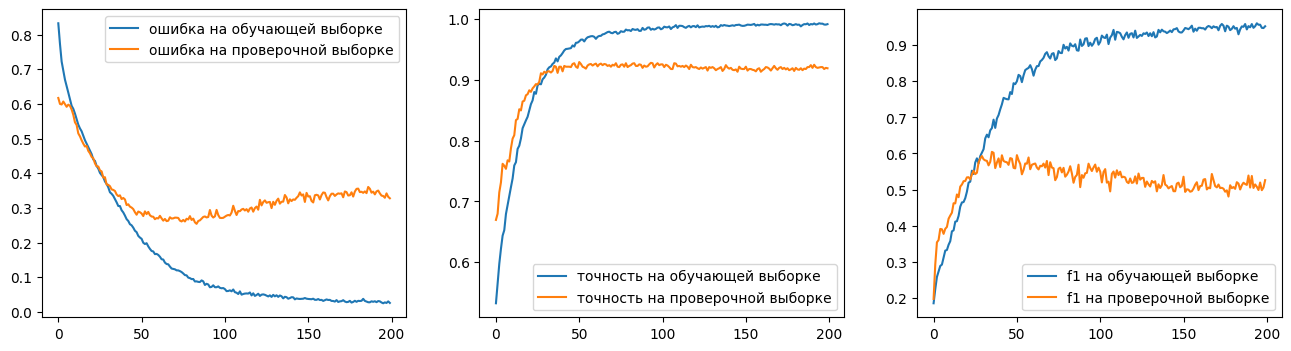

лучшая средняя точность на проверочной выборке:  0.9395
лучшая средняя precision на проверочной выборке:  0.6827
лучший средний recall на проверочной выборке:  0.8894
лучший средний f1 на проверочной выборке:  0.6042
          pred_0  pred_1
actual_0  1391.0    43.0
actual_1    52.0    85.0
calc_accuracy: 0.939528962444303
calc_precision: 0.6640625
calc_recall: 0.6204379562043796


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [1000, 'relu', 0.25, True],
          1: [500, 'relu', 0.1, True],
          2: [100, 'relu', 0.1, True],
          3: [10, 'relu', 0, True]}
lr = 0.00005
batch = 10
epochs = 200
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9365
best_test_precision 0.6061
best_test_recall 0.8571
best_test_f1 0.697
          pred_0  pred_1
actual_0     272      15
actual_1       5      23
calc_accuracy: 0.9365
calc_precision: 0.6053
calc_recall: 0.8214


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9268
best_test_precision 1.0
best_test_recall 0.4815
best_test_f1 0.4898
          pred_0  pred_1
actual_0     287       0
actual_1      23       4
calc_accuracy: 0.9268
calc_precision: 1.0
calc_recall: 0.1481


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9363
best_test_precision 0.8333
best_test_recall 0.6667
best_test_f1 0.5532
          pred_0  pred_1
actual_0     283       4
actual_1      16      11
calc_accuracy: 0.9363
calc_precision: 0.7333
calc_recall: 0.4074


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9363
best_test_precision 1.0
best_test_recall 0.4444
best_test_f1 0.5217
    

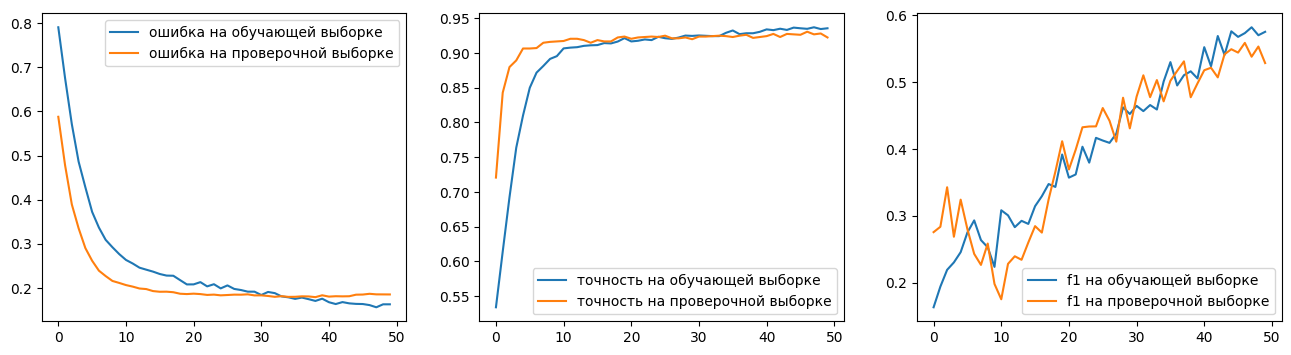

лучшая средняя точность на проверочной выборке:  0.9357
лучшая средняя precision на проверочной выборке:  0.8545
лучший средний recall на проверочной выборке:  0.6542
лучший средний f1 на проверочной выборке:  0.5589
          pred_0  pred_1
actual_0  1411.0    23.0
actual_1    78.0    59.0
calc_accuracy: 0.9357097390197326
calc_precision: 0.7195121951219512
calc_recall: 0.4306569343065693


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.5, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, False]}
lr = 0.0001
batch = 10
epochs = 50
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9397
best_test_precision 1.0
best_test_recall 0.8214
best_test_f1 0.697
          pred_0  pred_1
actual_0     276      11
actual_1       8      20
calc_accuracy: 0.9397
calc_precision: 0.6452
calc_recall: 0.7143


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9395
best_test_precision 0.8571
best_test_recall 0.7407
best_test_f1 0.6667
          pred_0  pred_1
actual_0     281       6
actual_1      13      14
calc_accuracy: 0.9395
calc_precision: 0.7
calc_recall: 0.5185


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9427
best_test_precision 0.75
best_test_recall 0.6296
best_test_f1 0.6538
          pred_0  pred_1
actual_0     282       5
actual_1      13      14
calc_accuracy: 0.9427
calc_precision: 0.7368
calc_recall: 0.5185


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9459
best_test_precision 1.0
best_test_recall 0.6667
best_test_f1 0.6667
      

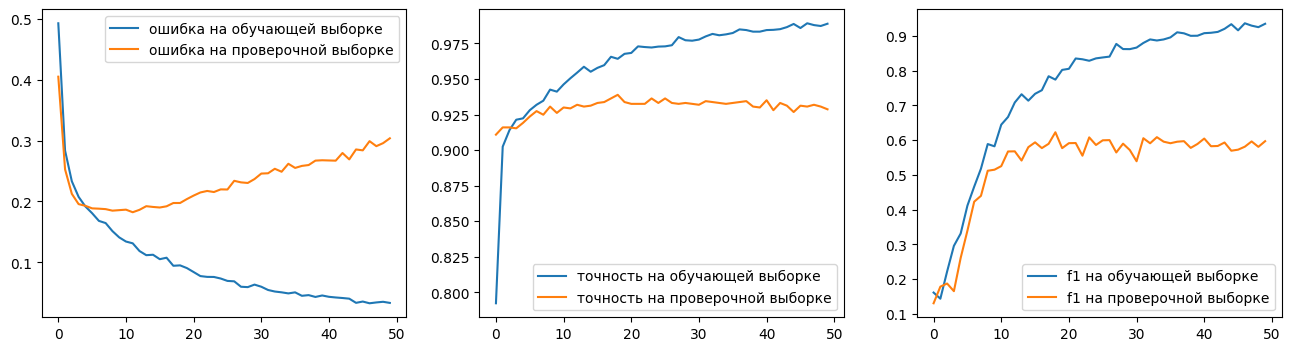

лучшая средняя точность на проверочной выборке:  0.9414
лучшая средняя precision на проверочной выборке:  0.9214
лучший средний recall на проверочной выборке:  0.6931
лучший средний f1 на проверочной выборке:  0.6227
          pred_0  pred_1
actual_0  1400.0    34.0
actual_1    58.0    79.0
calc_accuracy: 0.9414385741565882
calc_precision: 0.6991150442477876
calc_recall: 0.5766423357664233


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0, False],
          2: [10, 'relu', 0, False]}
lr = 0.0001
batch = 10
epochs = 50
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9397
best_test_precision 1.0
best_test_recall 0.8214
best_test_f1 0.6885
          pred_0  pred_1
actual_0     275      12
actual_1       7      21
calc_accuracy: 0.9397
calc_precision: 0.6364
calc_recall: 0.75


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9459
best_test_precision 1.0
best_test_recall 0.6667
best_test_f1 0.6316
          pred_0  pred_1
actual_0     285       2
actual_1      15      12
calc_accuracy: 0.9459
calc_precision: 0.8571
calc_recall: 0.4444


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9395
best_test_precision 1.0
best_test_recall 0.5556
best_test_f1 0.5833
          pred_0  pred_1
actual_0     282       5
actual_1      14      13
calc_accuracy: 0.9395
calc_precision: 0.7222
calc_recall: 0.4815


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9395
best_test_precision 1.0
best_test_recall 0.6296
best_test_f1 0.6182
        

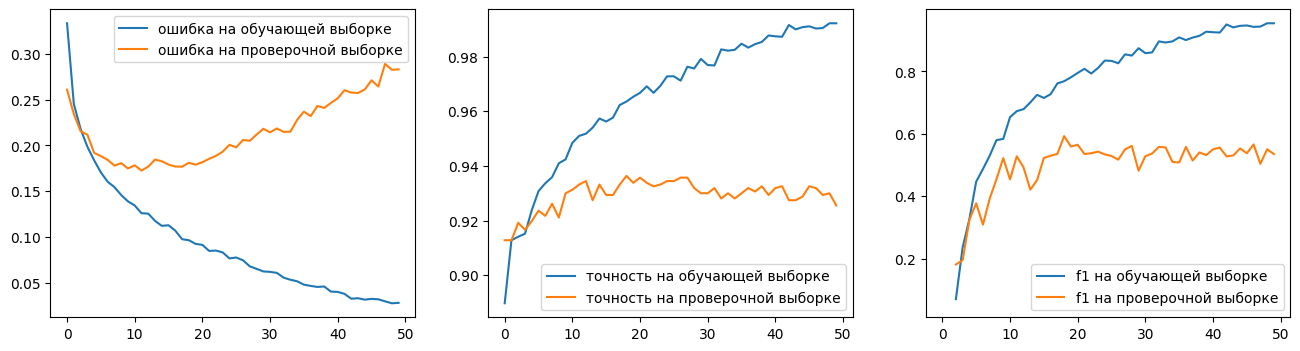

лучшая средняя точность на проверочной выборке:  0.9414
лучшая средняя precision на проверочной выборке:  1.0
лучший средний recall на проверочной выборке:  0.6489
лучший средний f1 на проверочной выборке:  0.5927
          pred_0  pred_1
actual_0  1407.0    27.0
actual_1    65.0    72.0
calc_accuracy: 0.9414385741565882
calc_precision: 0.7272727272727273
calc_recall: 0.5255474452554745


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, False],
          1: [50, 'relu', 0, False],
          2: [10, 'relu', 0, False]}
lr = 0.0001
batch = 10
epochs = 50
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9397
best_test_precision 0.75
best_test_recall 0.7143
best_test_f1 0.6667
          pred_0  pred_1
actual_0     277      10
actual_1       9      19
calc_accuracy: 0.9397
calc_precision: 0.6552
calc_recall: 0.6786


10/10 [==============================] - 0s 5ms/step
best_test_acc 0.9427
best_test_precision 0.8462
best_test_recall 0.5926
best_test_f1 0.5818
          pred_0  pred_1
actual_0     284       3
actual_1      15      12
calc_accuracy: 0.9427
calc_precision: 0.8
calc_recall: 0.4444


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9459
best_test_precision 1.0
best_test_recall 0.5185
best_test_f1 0.6047
          pred_0  pred_1
actual_0     284       3
actual_1      14      13
calc_accuracy: 0.9459
calc_precision: 0.8125
calc_recall: 0.4815


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9427
best_test_precision 1.0
best_test_recall 0.6296
best_test_f1 0.5965
     

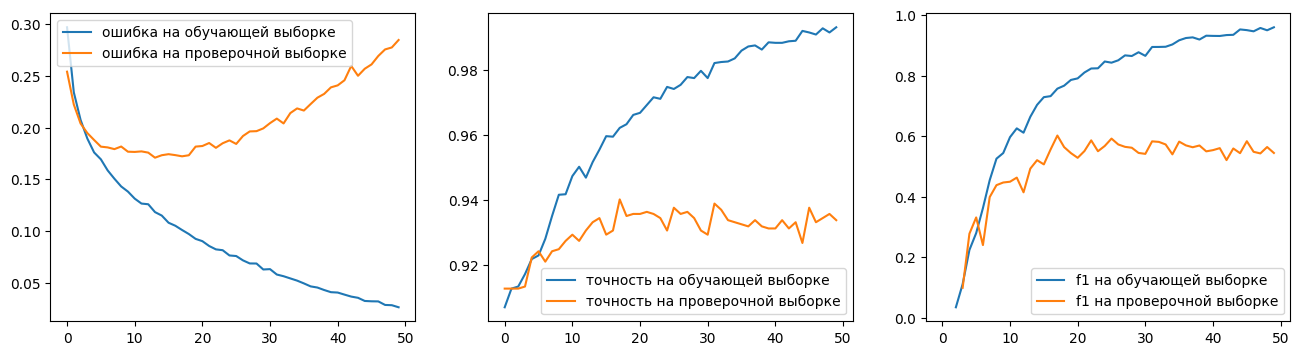

лучшая средняя точность на проверочной выборке:  0.9434
лучшая средняя precision на проверочной выборке:  0.8792
лучший средний recall на проверочной выборке:  0.6267
лучший средний f1 на проверочной выборке:  0.6023
          pred_0  pred_1
actual_0  1409.0    25.0
actual_1    64.0    73.0
calc_accuracy: 0.9433481858688734
calc_precision: 0.7448979591836735
calc_recall: 0.5328467153284672


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.1, False],
          1: [50, 'relu', 0, False],
          2: [10, 'relu', 0, False]}
lr = 0.00005
batch = 5
epochs = 50
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 5ms/step
best_test_acc 0.9397
best_test_precision 1.0
best_test_recall 0.8214
best_test_f1 0.6667
          pred_0  pred_1
actual_0     277      10
actual_1       9      19
calc_accuracy: 0.9397
calc_precision: 0.6552
calc_recall: 0.6786


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9459
best_test_precision 0.7222
best_test_recall 0.7037
best_test_f1 0.6909
          pred_0  pred_1
actual_0     278       9
actual_1       8      19
calc_accuracy: 0.9459
calc_precision: 0.6786
calc_recall: 0.7037


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9427
best_test_precision 0.8
best_test_recall 1.0
best_test_f1 0.6415
          pred_0  pred_1
actual_0     281       6
actual_1      12      15
calc_accuracy: 0.9427
calc_precision: 0.7143
calc_recall: 0.5556


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9459
best_test_precision 0.875
best_test_recall 0.6667
best_test_f1 0.625
     

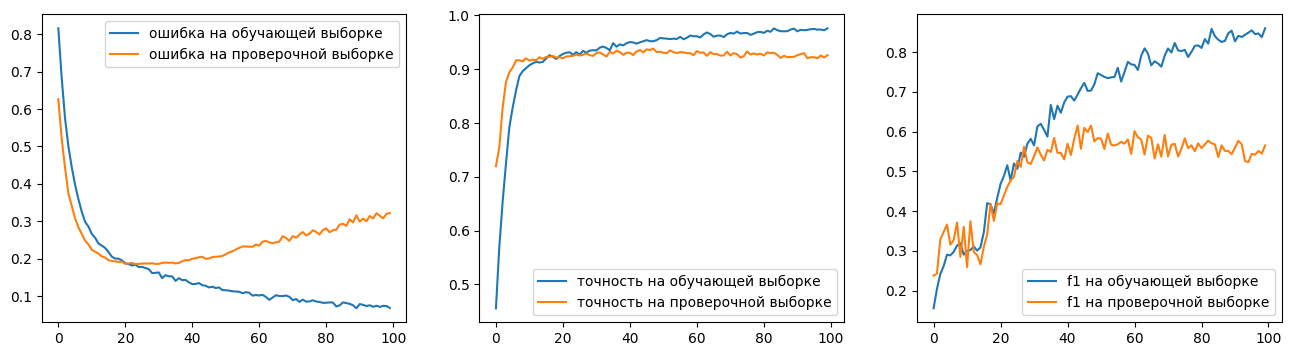

лучшая средняя точность на проверочной выборке:  0.944
лучшая средняя precision на проверочной выборке:  0.8794
лучший средний recall на проверочной выборке:  0.7669
лучший средний f1 на проверочной выборке:  0.615
          pred_0  pred_1
actual_0  1400.0    34.0
actual_1    54.0    83.0
calc_accuracy: 0.9439847231063018
calc_precision: 0.7094017094017094
calc_recall: 0.6058394160583942


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [500, 'relu', 0.25, True],
          2: [50, 'relu', 0.25, True],
          3: [10, 'relu', 0, False]}
lr = 0.0001
batch = 10
epochs = 100
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9365
best_test_precision 0.7143
best_test_recall 0.7143
best_test_f1 0.6667
          pred_0  pred_1
actual_0     279       8
actual_1      12      16
calc_accuracy: 0.9365
calc_precision: 0.6667
calc_recall: 0.5714


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9427
best_test_precision 0.8
best_test_recall 0.5926
best_test_f1 0.6038
          pred_0  pred_1
actual_0     284       3
actual_1      15      12
calc_accuracy: 0.9427
calc_precision: 0.8
calc_recall: 0.4444


10/10 [==============================] - 0s 2ms/step
best_test_acc 0.9363
best_test_precision 0.7
best_test_recall 0.9259
best_test_f1 0.5882
          pred_0  pred_1
actual_0     281       6
actual_1      14      13
calc_accuracy: 0.9363
calc_precision: 0.6842
calc_recall: 0.4815


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9331
best_test_precision 0.875
best_test_recall 0.7778
best_test_f1 0.5333
    

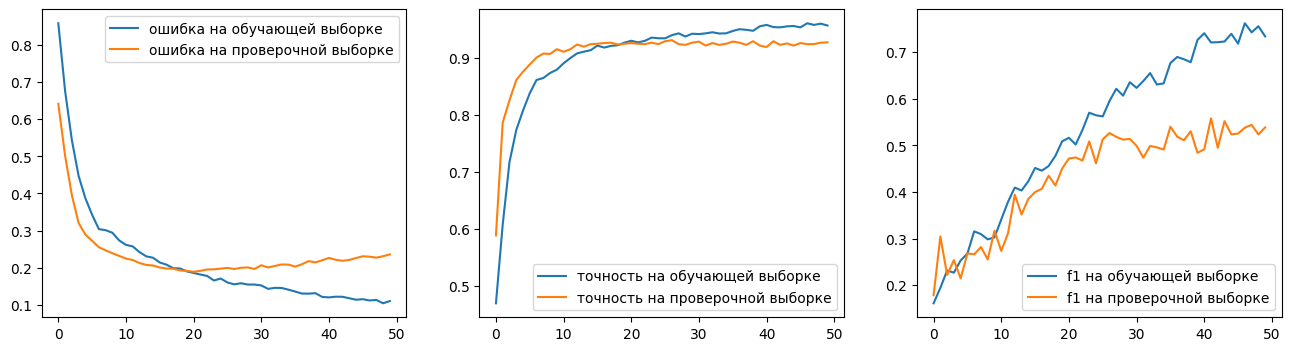

лучшая средняя точность на проверочной выборке:  0.9376
лучшая средняя precision на проверочной выборке:  0.7845
лучший средний recall на проверочной выборке:  0.7664
лучший средний f1 на проверочной выборке:  0.5578
          pred_0  pred_1
actual_0  1412.0    22.0
actual_1    76.0    61.0
calc_accuracy: 0.9376193507320179
calc_precision: 0.7349397590361446
calc_recall: 0.44525547445255476


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [200, 'relu', 0.25, True],
          1: [200, 'relu', 0.25, True],
          2: [10, 'relu', 0, False]}
lr = 0.0001
batch = 10
epochs = 50
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 7ms/step
best_test_acc 0.9397
best_test_precision 0.6452
best_test_recall 0.9643
best_test_f1 0.6875
          pred_0  pred_1
actual_0     276      11
actual_1       8      20
calc_accuracy: 0.9397
calc_precision: 0.6452
calc_recall: 0.7143


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9363
best_test_precision 0.6207
best_test_recall 0.8889
best_test_f1 0.6429
          pred_0  pred_1
actual_0     276      11
actual_1       9      18
calc_accuracy: 0.9363
calc_precision: 0.6207
calc_recall: 0.6667


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9395
best_test_precision 0.6842
best_test_recall 1.0
best_test_f1 0.6415
          pred_0  pred_1
actual_0     278       9
actual_1      10      17
calc_accuracy: 0.9395
calc_precision: 0.6538
calc_recall: 0.6296


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9363
best_test_precision 0.6522
best_test_recall 0.7407
best_test_f1 0.6


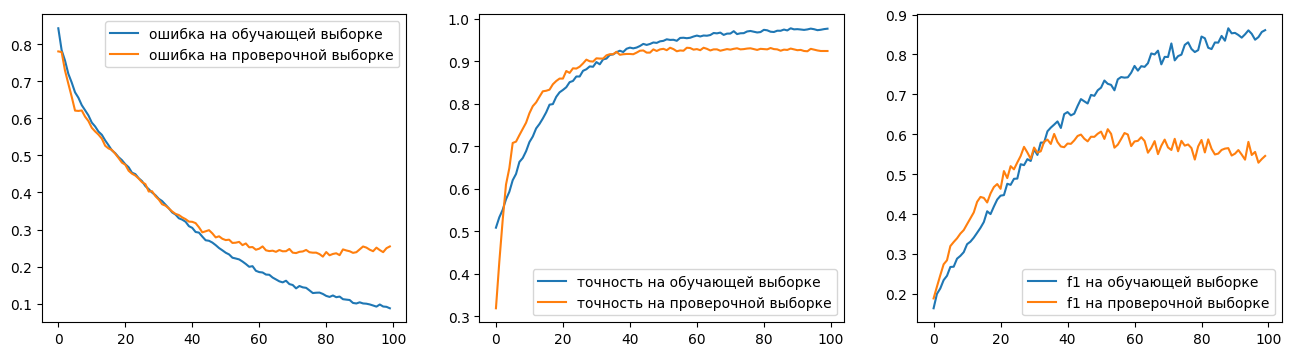

лучшая средняя точность на проверочной выборке:  0.9408
лучшая средняя precision на проверочной выборке:  0.6824
лучший средний recall на проверочной выборке:  0.9188
лучший средний f1 на проверочной выборке:  0.6126
          pred_0  pred_1
actual_0  1391.0    43.0
actual_1    50.0    87.0
calc_accuracy: 0.9408020369191598
calc_precision: 0.6692307692307692
calc_recall: 0.635036496350365


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [500, 'relu', 0.1, True],
          2: [50, 'relu', 0.1, True],
          3: [10, 'relu', 0, True]}
lr = 0.00005
batch = 10
epochs = 100
output_bias = None
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

#### свод результатов

In [330]:
[(key, np.round(np.mean(results[key]['acc'].iloc[:,:5].max()),4)) for key in sorted(results, key = lambda x: np.mean(results[x]['acc'].iloc[:,:5].max()), reverse=True)]

[(6, 0.9465),
 (5, 0.9453),
 (7, 0.9446),
 (14, 0.944),
 (3, 0.944),
 (13, 0.9434),
 (2, 0.9427),
 (8, 0.9421),
 (1, 0.9421),
 (11, 0.9414),
 (12, 0.9414),
 (4, 0.9408),
 (16, 0.9408),
 (9, 0.9395),
 (19, 0.9383),
 (20, 0.9383),
 (15, 0.9376),
 (10, 0.9357),
 (18, 0.9351),
 (17, 0.9287)]

In [329]:
[(key, np.round(np.mean(results[key]['recall'].iloc[:,:5].max()),4)) for key in sorted(results, key = lambda x: np.mean(results[x]['recall'].iloc[:,:5].max()), reverse=True)]

[(17, 0.9484),
 (18, 0.9344),
 (5, 0.9201),
 (16, 0.9188),
 (4, 0.9056),
 (8, 0.8899),
 (9, 0.8894),
 (7, 0.8831),
 (6, 0.8616),
 (2, 0.8534),
 (20, 0.8463),
 (19, 0.7675),
 (14, 0.7669),
 (15, 0.7664),
 (11, 0.6931),
 (1, 0.6635),
 (10, 0.6542),
 (12, 0.6489),
 (3, 0.6267),
 (13, 0.6267)]

In [ ]:
results[6].keys()

dict_keys(['layers', 'lr', 'batch', 'epochs', 'metric_to_monitor', 'bias', 'acc', 'precision', 'recall', 'f1', 'confusion_matrix'])

In [ ]:
 for key in ['layers', 'lr', 'batch', 'epochs', 'metric_to_monitor', 'bias']: 
  print(key, results[6][key])

layers {0: [500, 'relu', 0.25, True], 1: [50, 'relu', 0.25, True], 2: [10, 'relu', 0, True]}
lr 0.0001
batch 10
epochs 100
metric_to_monitor val_accuracy
bias None


###### другая функция потерь (focal loss)

In [325]:
def focal_loss_custom(alpha, gamma):
   def binary_focal_loss(y_true, y_pred):
      fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      focal_loss = fl(y_true, y_pred)
      return focal_loss
   return binary_focal_loss

In [326]:
focal_loss_custom(alpha=0.2, gamma=2.0)

<function __main__.focal_loss_custom.<locals>.binary_focal_loss(y_true, y_pred)>

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9365
best_test_precision 0.875
best_test_recall 0.7857
best_test_f1 0.6296
          pred_0  pred_1
actual_0     282       5
actual_1      15      13
calc_accuracy: 0.9365
calc_precision: 0.7222
calc_recall: 0.4643


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9363
best_test_precision 1.0
best_test_recall 0.6667
best_test_f1 0.5
          pred_0  pred_1
actual_0     284       3
actual_1      17      10
calc_accuracy: 0.9363
calc_precision: 0.7692
calc_recall: 0.3704


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9363
best_test_precision 1.0
best_test_recall 0.8889
best_test_f1 0.5306
          pred_0  pred_1
actual_0     285       2
actual_1      18       9
calc_accuracy: 0.9363
calc_precision: 0.8182
calc_recall: 0.3333


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9395
best_test_precision 1.0
best_test_recall 0.8889
best_test_f1 0.5366
       

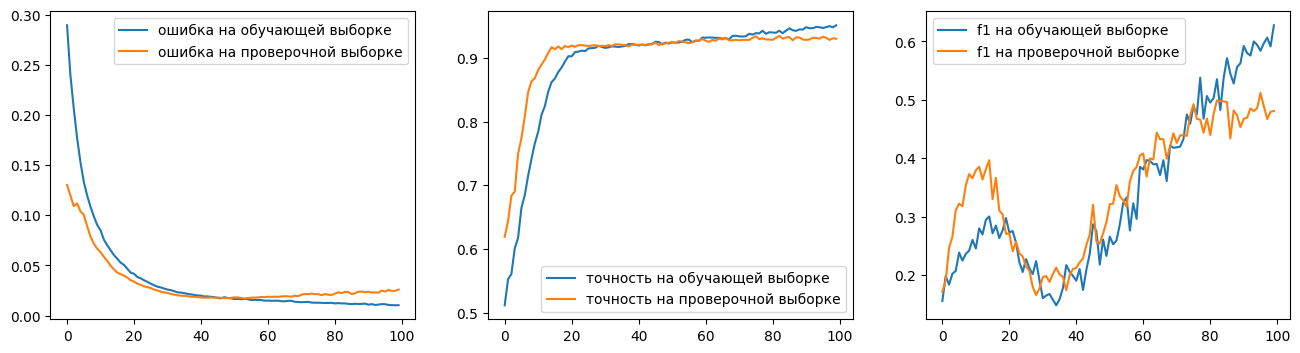

лучшая средняя точность на проверочной выборке:  0.9383
лучшая средняя precision на проверочной выборке:  0.9375
лучший средний recall на проверочной выборке:  0.7675
лучший средний f1 на проверочной выборке:  0.5119
          pred_0  pred_1
actual_0  1418.0    16.0
actual_1    81.0    56.0
calc_accuracy: 0.9382558879694463
calc_precision: 0.7777777777777778
calc_recall: 0.40875912408759124


In [327]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, True]}
lr = 0.0001
batch = 10
epochs = 100
output_bias = None
class_weight = None
metric_to_monitor = 'val_accuracy'
loss = focal_loss_custom(alpha=0.2, gamma=2.0)
res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, class_weight = class_weight, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias, loss=loss)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9397
best_test_precision 0.7222
best_test_recall 0.8214
best_test_f1 0.6984
          pred_0  pred_1
actual_0     276      11
actual_1       8      20
calc_accuracy: 0.9397
calc_precision: 0.6452
calc_recall: 0.7143


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9395
best_test_precision 0.7059
best_test_recall 0.8148
best_test_f1 0.678
          pred_0  pred_1
actual_0     280       7
actual_1      12      15
calc_accuracy: 0.9395
calc_precision: 0.6818
calc_recall: 0.5556


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9331
best_test_precision 0.7143
best_test_recall 0.7407
best_test_f1 0.5769
          pred_0  pred_1
actual_0     283       4
actual_1      17      10
calc_accuracy: 0.9331
calc_precision: 0.7143
calc_recall: 0.3704


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9363
best_test_precision 0.7143
best_test_recall 0.9259
best_test_f1 0.

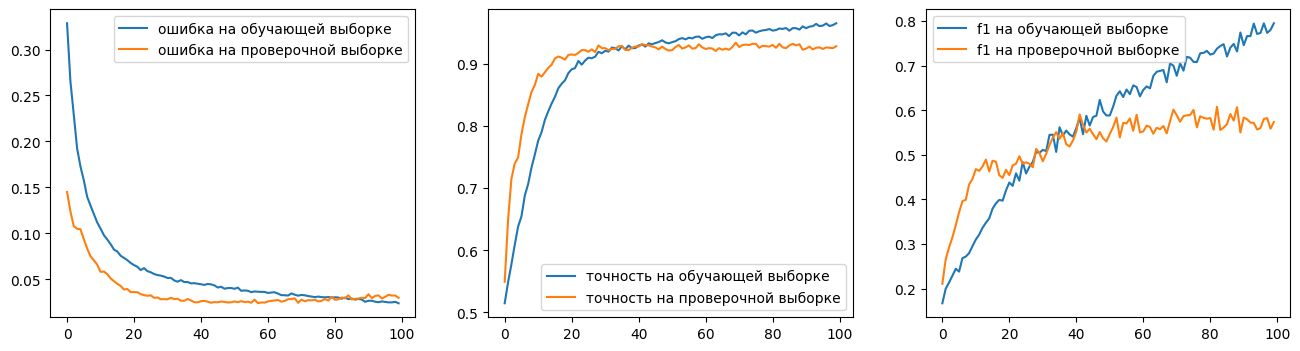

лучшая средняя точность на проверочной выборке:  0.9383
лучшая средняя precision на проверочной выборке:  0.7213
лучший средний recall на проверочной выборке:  0.8463
лучший средний f1 на проверочной выборке:  0.608
          pred_0  pred_1
actual_0  1401.0    33.0
actual_1    64.0    73.0
calc_accuracy: 0.9382558879694463
calc_precision: 0.6886792452830188
calc_recall: 0.5328467153284672


In [328]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, True]}
lr = 0.0001
batch = 10
epochs = 100
output_bias = None
class_weight = {0:1, 1:5}
metric_to_monitor = 'val_accuracy'
loss = focal_loss_custom(alpha=0.2, gamma=2.0)
res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, class_weight = class_weight, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias, loss=loss)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

###### веса для классов

10/10 [==============================] - 1s 12ms/step
best_test_acc 0.9302
best_test_precision 0.5789
best_test_recall 0.9643
best_test_f1 0.6857
          pred_0  pred_1
actual_0     270      17
actual_1       5      23
calc_accuracy: 0.9302
calc_precision: 0.575
calc_recall: 0.8214


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9331
best_test_precision 0.6
best_test_recall 0.8519
best_test_f1 0.6452
          pred_0  pred_1
actual_0     275      12
actual_1       9      18
calc_accuracy: 0.9331
calc_precision: 0.6
calc_recall: 0.6667


10/10 [==============================] - 1s 5ms/step
best_test_acc 0.9236
best_test_precision 0.5517
best_test_recall 1.0
best_test_f1 0.6118
          pred_0  pred_1
actual_0     272      15
actual_1       9      18
calc_accuracy: 0.9236
calc_precision: 0.5455
calc_recall: 0.6667


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9204
best_test_precision 0.5238
best_test_recall 0.9259
best_test_f1 0.6377
   

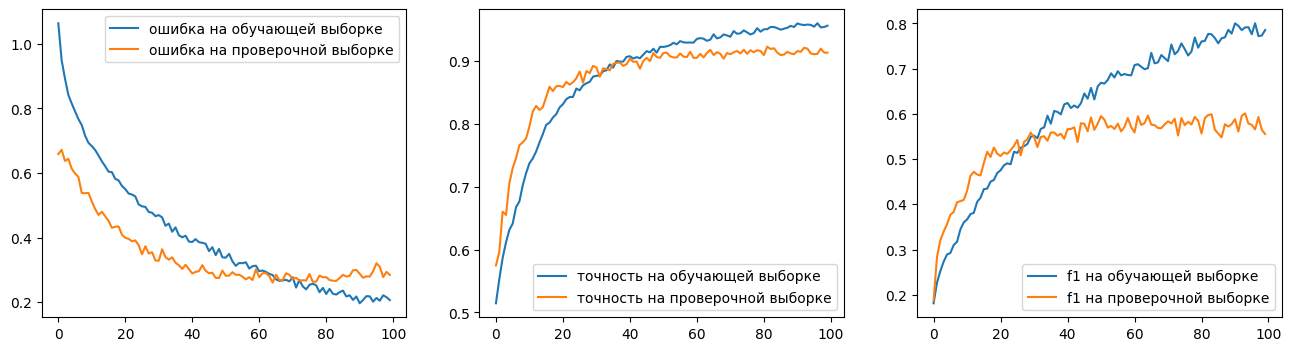

лучшая средняя точность на проверочной выборке:  0.9287
лучшая средняя precision на проверочной выборке:  0.5842
лучший средний recall на проверочной выборке:  0.9484
лучший средний f1 на проверочной выборке:  0.601
          pred_0  pred_1
actual_0  1361.0    73.0
actual_1    39.0    98.0
calc_accuracy: 0.9287078294080203
calc_precision: 0.5730994152046783
calc_recall: 0.7153284671532847


In [312]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, True]}
lr = 0.0001
batch = 10
epochs = 100
output_bias = None
class_weight = {0:1, 1:5}
metric_to_monitor = 'val_accuracy'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, class_weight = class_weight, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

10/10 [==============================] - 1s 8ms/step
best_test_acc 0.9365
best_test_precision 0.5952
best_test_recall 1.0
best_test_f1 0.7143
          pred_0  pred_1
actual_0     220      67
actual_1       0      28
calc_accuracy: 0.7873
calc_precision: 0.2947
calc_recall: 1.0


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9331
best_test_precision 0.6
best_test_recall 1.0
best_test_f1 0.6452
          pred_0  pred_1
actual_0     123     164
actual_1       0      27
calc_accuracy: 0.4777
calc_precision: 0.1414
calc_recall: 1.0


10/10 [==============================] - 0s 4ms/step
best_test_acc 0.9331
best_test_precision 0.6154
best_test_recall 0.8889
best_test_f1 0.6441
          pred_0  pred_1
actual_0     185     102
actual_1       3      24
calc_accuracy: 0.6656
calc_precision: 0.1905
calc_recall: 0.8889


10/10 [==============================] - 0s 3ms/step
best_test_acc 0.9395
best_test_precision 0.6333
best_test_recall 0.9259
best_test_f1 0.6667
         

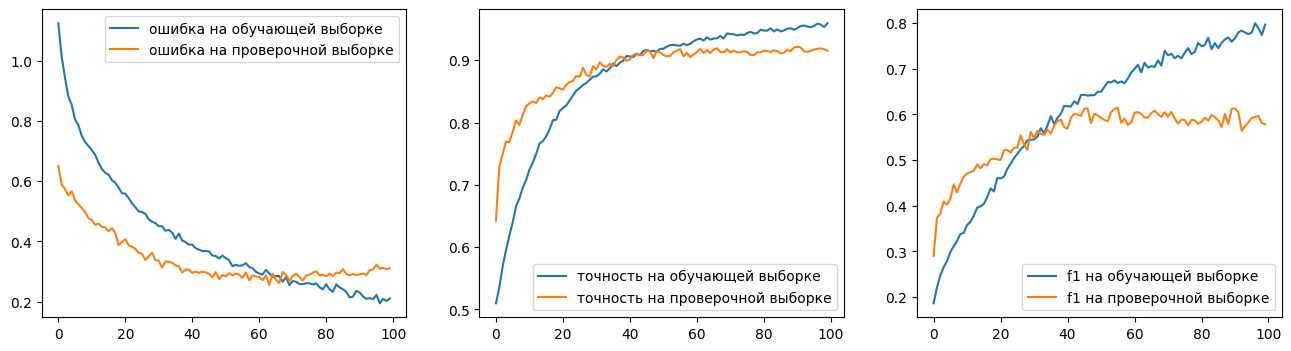

лучшая средняя точность на проверочной выборке:  0.9351
лучшая средняя precision на проверочной выборке:  0.6114
лучший средний recall на проверочной выборке:  0.9344
лучший средний f1 на проверочной выборке:  0.6148
          pred_0  pred_1
actual_0   962.0   472.0
actual_1     9.0   128.0
calc_accuracy: 0.6938255887969447
calc_precision: 0.21333333333333335
calc_recall: 0.9343065693430657


In [315]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
layers = {0: [500, 'relu', 0.25, True],
          1: [50, 'relu', 0.25, True],
          2: [10, 'relu', 0, True]}
lr = 0.0001
batch = 10
epochs = 100
output_bias = target_binary.sum()/len(target_binary)
class_weight = {0:1, 1:5}
metric_to_monitor = 'val_recall'

res = evaluate_nn_new(cv, layers=layers, lr = lr , batch=batch, epochs=epochs, class_weight = class_weight, metric_to_monitor = metric_to_monitor, plots=True, output_bias = output_bias)

n = len(results.keys())+1
results[n] = dict()
results[n]['layers'] = layers
results[n]['lr'] = lr
results[n]['batch'] = batch
results[n]['epochs'] = epochs
results[n]['metric_to_monitor'] = metric_to_monitor
results[n]['bias'] = output_bias
results[n]['acc'] = res['history_test_acc']
results[n]['precision'] = res['history_test_precision']
results[n]['recall'] = res['history_test_recall']
results[n]['f1'] = res['history_test_f1']
results[n]['confusion_matrix'] = res['confusion_matrix']

# Конец

# Дальнейшие планы:

*   строить ML и DL модели по более широкому набору признаков
*   пробовать более сложные архитектуры нейронок
*   (?) обработка текстовых полей (напр. профессия)






